In [1]:
from ROOT import TFile,TTree,TH2F,gROOT,gStyle,TCanvas
import array
import matplotlib.pyplot as plt
import numpy as np
from root_pandas import read_root 
import pandas as pd

import scipy.special as spc
import scipy.stats   as stat
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.special import wofz

Welcome to JupyROOT 6.18/04


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.18/04 is currently active but you installed root_numpy against ROOT 6.05/02. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
from iminuit import Minuit
from pprint import pprint

# Formating

In [3]:
def BinFormat(Bins,ranges = None,Type='ranges', Print=False):
    bins = []
    if type(Bins) is int:
        try:
            step = int((ranges[1]-ranges[0])/Bins)
            if step*Bins+ranges[0] != ranges[1] and Print:
                print('Last bin will be omited')
        except:
            if Print:
                print('Please provide a range')
        
        if Type=='ranges':
            for i in range(Bins):
                bins.append([i*step+ranges[0],(i+1)*step+ranges[0]])
        elif Type == 'edges':
            for i in range(Bins+1):
                bins.append(i*step+ranges[0])
                
    else:
        if Type == 'ranges':
            if type(Bins[0]) is np.ndarray or type(Bins[0]) is list:
                bins = Bins
            else:
                for i in np.arange(len(Bins)-1):
                    bins.append([Bins[i],Bins[i+1]])
        elif Type == 'edges':
            if type(Bins[0]) is int or type(Bins[0]) is float or type(Bins[0]) is np.int64:
                bins = Bins
            else:
                for b in Bins:
                    bins.append(b[0])
                bins.append(Bins[-1][1])
            bins = array.array("f",bins)

    return bins

In [4]:
def BinIndex(Data,Low,Max,Abs = False):
    if Abs:
        return np.logical_and(np.abs(Data) >= Low, np.abs(Data) <  Max)
    else:
        return np.logical_and(np.array(Data) >= Low, np.array(Data) <  Max)

# Template & Fitting

In [5]:
def Exp(x,*arg):
    lamb,x0 = arg
    return np.exp(-lamb*(x-x0))

In [6]:
def RooCMSShape(x,*arg):
    alpha, beta, peak, gamma = arg
    
    erf = spc.erfc((alpha - x)*beta)
    u = (x-peak)*gamma
    
    u = np.exp(-u)   
    #u[u <- 70] = u[u <- 70]*0 + 1e20
    #u[u > 70]  = u[u > 70]*0
    #ind  =  np.logical_and(u>=-70, u<=70)
    #u[ind]     = np.exp(-u[ind])
    
    return erf*u

In [7]:
def G(x, *arg):
    alpha, mean = arg
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha* np.exp(-((x-mean) / alpha)**2 * np.log(2))

In [8]:
def L(x, *arg):
    gamma, mean = arg
    """ Return Lorentzian line shape at x with HWHM gamma """
    return gamma / np.pi / ((x-mean)**2 + gamma**2)

In [9]:
def Voigt(x, *arg):
    alpha, gamma, mean = arg
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz(((x-mean) + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)

In [10]:
def NLL(DATA,Temp,*arg):
    Model = Temp(*arg)
    return np.sum(Model) - np.sum(DATA*np.log(Model))

def CHI2(DATA,Temp,*arg):
    Model = Temp(*arg)
    DATA[DATA==0] = 1
    SIGMA_2 = (1/DATA + 1/Model)**(-1)
    return np.sum((Model-DATA)**2/SIGMA_2)

In [11]:
def Template(Nsig,Nbkg,Sig,Bkg):
    return Nsig * (Sig/np.sum(Sig)) + Nbkg * (Bkg/np.sum(Bkg))

# FIT

In [12]:
def GoodGuess(i,j,Ni,Nj,tries,p0):
    if   len(p0) == 4:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4]

        ####################################
        if j == Nj-1 or j == Nj-2:
            #p0 = [1e5,   1e3, 1e5,   1e3]
            #p0 = [1e6,   1e6, 1e6,   1e6]
            p0 = [1e2,   2e2, 1e2,   2e2]
        else:
            p0 = [np.random.rand()*1e4,   np.random.rand()*1e3, np.random.rand()*1e3,   np.random.rand()*1e3]
        ####################################
        if tries == 100:
            print('Reach Maximum tries')
            return False
    elif len(p0) == 12:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*60, np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10,
                np.random.rand()*60, np.random.rand()*10, np.random.rand()*200,  np.random.rand()*10
                ]

        ####################################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                    #1e5,   1e5, 1e5,   1e5,
                    1e2,   2e2, 1e2,   2e2,
                    1, -0.1, 1, 0.1,
                    1, -0.1, 1, 0.1
                    ]
        else:
            p0 = [
                np.random.rand()*1e4,   np.random.rand()*1e3, np.random.rand()*1e3,   np.random.rand()*1e3,
                np.random.rand()*60, -np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10,
                np.random.rand()*60, -np.random.rand()*10, np.random.rand()*200,   np.random.rand()*10
                ]
        ####################################
        if tries == 1000:
            print('Reach Maximum tries')
            return False
    elif len(p0) == 14:
        ####################################
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                ]

        ####################################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                5e3,   13e3, 5,   13,
                2, 2, 87,
                0.03, 0,
                2, 2, 87,
                0.03, 0,
                ]
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                np.random.rand()*3, np.random.rand()*3, np.random.rand()*120,
                np.random.rand()*0.05, np.random.rand()*3,
                ]
    elif len(p0) == 18:
        if i == 2 or i == 7:
            return False
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                # Pass
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*30,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,   np.random.rand()*10,
                #Fail
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*60,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,  np.random.rand()*10
                ]
        ###########################
        if j == Nj-1 or j == Nj-2:
            p0 = [
                    2e4,   5e3, 1e4,   1e3,
                    #Pass
                    1, 1, 20,
                    1, -2, 100,   -0.03,
                    # Fail
                    1, 1, 50,
                    1e2, 1e2, 100,   -0.03,
                    ]
        else:
            p0 = [
                np.random.rand()*1e6,   np.random.rand()*1e4, np.random.rand()*1e5,   np.random.rand()*1e4,
                # Pass
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*30,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,   np.random.rand()*10,
                #Fail
                np.random.rand()*2,   np.random.rand()*2, np.random.rand()*60,
                np.random.rand()*1e5, np.random.rand()*1e5, np.random.rand()*200,  np.random.rand()*10
                ]          

    return p0

# Main Functionality

In [13]:
def Plot(ax,
         Var,
         ranges, bins, color,
         DataMC='mc',
         tempType='KDE'
        ):
    
        
        if type(bins) is np.ndarray or type(bins) is list:
            hist = np.histogram(
                                Var,
                                range    = ranges,
                                bins     = bins,
                                )
            hist = ax.hist(
                            bins[:-1],
                            histtype = 'step',
                            range    = ranges,
                            weights  = hist[0]/np.diff(bins),
                            bins     = bins,
                            color    = color,
                            label    = 'HIST', 
                            )
        else:
            hist = ax.hist(
                            Var,
                            histtype = 'step',
                            range    = ranges,
                            bins     = bins,
                            color    = color,
                            label    = 'HIST', 
                            #density  = True,
                            )
        
        xc = (hist[1][:-1]+hist[1][1:])/2
        hist[0][np.isnan(hist[0])] = 0
        
        #######
        if   tempType == 'KDE':
            try:
                kde       = stat.gaussian_kde(dataset = Var)    
                template  = kde(xc)
                ratio     = np.sum(template)/np.sum(hist[0])
            except:
                template = xc*0
                ratio    = 1
        elif tempType == 'HIST':
                template = hist[0]
                ratio    = 1
            
        
        ax.plot(xc,template/ratio,'k--',label = 'KDE')
        ax.grid(linestyle = '--')
        ax.legend()
        
        return template, ratio

In [14]:
def EffGrid(sample,
            part         = 'dilepton',
            variable     = 'M',
            DataMC       = 'mc',
            samples      = '',
            ProbeType    = 'Pass',
            IDPass       = True,
            ptBins       = array.array("f",[0,20,35,50,90,150,500]), 
            etaBins      = array.array("f",[-2.5,-2,-1.566,-1.4442,-1.0,0,1.0,1.4442,1.566,2,2.5]),
            Abs          = False, 
            isConv       = False,
            ranges       = [60,120],
            bins         =  60, # Should be ranges[1]-ranges[0]
            tempType     = 'KDE',
            BinEBEE      = None,
           ):
    #### Array Outputs
    template,ratios = {},{}
    
    ### Eta Bin formating
    etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
    etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
    etaNBin,ptNBin = len(etaBins),len(ptBins)

    ### Ploting variable
    if ProbeType == "Pass":
        color = 'C0'
    else:
        color = 'C1' 
    
    figx, figy = etaNBin, ptNBin

    fig = plt.figure(figsize=(figy*3,figx*4))
    for j in np.arange(ptNBin):
        if j in BinEBEE:
            etaBINS = etaBinsEBEE
        else:
            etaBINS = etaBins

        template[j],ratios[j] = {},{}
        for i in np.arange(len(etaBINS)):                 
            VAL = sample[part+variable]
            if IDPass:
                if ProbeType == "Pass":
                    Ind = sample["ProbeIDPass"] == True
                    Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                    Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                    Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
                    if isConv:
                        Ind = np.logical_and(Ind,sample["ProbeIsConv"]    == True)
                    
                else:
                    if isConv:
                        Ind = sample["ProbeIDPass"] == True
                        Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                        Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                        Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)

                        Ind = np.logical_and(Ind,sample["ProbeIsConv"]    == False)
                    else:
                        Ind = sample["ProbeIDPass"] == False
                        Ind = np.logical_or(Ind,sample["ProbeISOPass"]   == False)
                        Ind = np.logical_or(Ind,sample["ProbeWorstPass"] == False)
                        Ind = np.logical_or(Ind,sample["ProbeSigPass"]   == False)


            else:
                if ProbeType == "Pass":
                    Ind = sample["ProbeIDPass"] == True
                else:
                    Ind = sample["ProbeIDPass"] == False    
            
            
            Var = np.array(VAL[Ind])
            Pt  = sample['leptonTwoPt'][Ind]
            Eta = sample['leptonTwoEta'][Ind]

            ptInd  = BinIndex(Pt , ptBins [j][0], ptBins [j][1], Abs = Abs)
            etaInd = BinIndex(Eta, etaBINS[i][0], etaBINS[i][1], Abs = Abs)
            Ind    = np.logical_and(ptInd,etaInd)


            ij = ptNBin*i + (j+1)     
            plt.subplot(etaNBin, ptNBin, ij)
            ax = plt.gca()

            TEMP, RATIO = Plot(
                                ax       = ax,
                                Var      = Var[Ind],
                                ranges   = ranges,
                                bins     = bins,
                                color    = color,
                                DataMC   = DataMC,
                                tempType = tempType,
                                )
                    
            template[j][i] = TEMP
            ratios[j][i]   = RATIO
            
        

            if j == 0:
                ax.set_ylabel('Eta ['+str(round(etaBINS[i][0],2))+','+str(round(etaBINS[i][1],2))+']'  )        
            if i == 0:
                ax.set_title('Pt ['+str(ptBins[j][0])+','+str(ptBins[j][1])+']' )
                
    

    
    plt.tight_layout()
    plt.show()
    #fig.savefig('/home/jcordero/CMS/MEH/zee/'+'zee_'+DataMC+'/'+samples+'_'+ProbeType+'_PeakMap.png')
    if isConv:
        fig.savefig(figpath+DataMC+samples+'_'+ProbeType+'_PeakMap_isConv.png')
    else:
        fig.savefig(figpath+DataMC+samples+'_'+ProbeType+'_PeakMap.png')
    
    return template,ratios

In [15]:
def EffMC(
            sample,
            part      = 'dilepton',
            variable  = 'M',
            ptBins    = array.array("f",[0,20,35,50,90,150,500]), 
            etaBins   = array.array("f",[-2.5,-2,-1.566,-1.4442,-1.0,0,1.0,1.4442,1.566,2,2.5]),
            Abs       = False, 
            isConv    = False,
            ranges    = [60,120],
            bins      =  60, # Should be ranges[1]-ranges[0]
            BinEBEE   = None,
            ProbeType = 'Pass',
            ):
    #### Array Outputs
    Yield = {}
    
    ### Eta Bin formating
    etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
    etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
    etaNBin,ptNBin = len(etaBins),len(ptBins)
    
    for j in np.arange(ptNBin):
        Yield[j] = {}
        if j in BinEBEE:
            etaBINS = etaBinsEBEE
        else:
            etaBINS = etaBins

        #template[j],ratios[j] = {},{}
        for i in np.arange(len(etaBINS)):                 
            VAL = sample[part+variable]
            if ProbeType == "Pass":
                Ind = sample["ProbeIDPass"] == True
                Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
                if isConv:
                    Ind = np.logical_and(Ind,sample["ProbeIsConv"]   == True)
            else:
                if isConv:
                    Ind = sample["ProbeIDPass"] == True
                    Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
                    Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
                    Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
                
                    Ind = np.logical_and(Ind,sample["ProbeIsConv"] == False)
                else:
                    Ind = sample["ProbeIDPass"] == False
                    Ind = np.logical_or(Ind,sample["ProbeISOPass"]   == False)
                    Ind = np.logical_or(Ind,sample["ProbeWorstPass"] == False)
                    Ind = np.logical_or(Ind,sample["ProbeSigPass"]   == False)
                
        
            
            
            Var = np.array(VAL[Ind])
            Pt  = sample['leptonTwoPt'][Ind]
            Eta = sample['leptonTwoEta'][Ind]

            ptInd  = BinIndex(Pt , ptBins [j][0], ptBins [j][1],Abs=Abs)
            etaInd = BinIndex(Eta, etaBINS[i][0], etaBINS[i][1],Abs=Abs)
            Ind    = np.logical_and(ptInd,etaInd)
            
            Yield[j][i] = np.sum(Ind)
            
    return Yield

# Extract Data

In [16]:
selection = 'ee'

#era = '2016'
era = '2017'

if era == "2016":
    period = "legacy"
    run = ['C','D','E','G']
elif era == "2017":
    period = "rereco"
    run = ['B','C','D','E','F']
    run = ['B','D','E','F']
    #run = ['D']

#NewOld = 'New/'
#NewOld = 'TagProbe/'
#NewOld = 'TagProbe_noTrig/'
NewOld = 'EfficiencyCorrection/files_zee/CorrShower/'

#path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/files_zee/"+NewOld+"SingleElectron/"
path = "/home/jcordero/CMS/data_"+era+"/"+period+"/SMP_ZG/Files/ee/"+NewOld+"SingleElectron/"
figpath = '/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/'+era+'/'+period+'/'+selection+'/Eff_SF_csv/'


files = [path+"output_Electron_"+era+r+"_v.root" for r in run]

var = ["dileptonM",
       "leptonOnePt","leptonOneEta",
       "leptonTwoPt","leptonTwoEta",
       "vetoDY","genIsoPass",
       "ProbeIDPass","ProbeISOPass","ProbeWorstPass","ProbeSigPass","ProbeIsConv"
       #"ProbePass",
       #"TagFromZ","ProbeFromZ",
      ]

In [17]:
files

['/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/EfficiencyCorrection/files_zee/CorrShower/SingleElectron/output_Electron_2017B_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/EfficiencyCorrection/files_zee/CorrShower/SingleElectron/output_Electron_2017D_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/EfficiencyCorrection/files_zee/CorrShower/SingleElectron/output_Electron_2017E_v.root',
 '/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/ee/EfficiencyCorrection/files_zee/CorrShower/SingleElectron/output_Electron_2017F_v.root']

In [18]:
Data = {}
###############
for i in np.arange(len(run)):
    print('-----------')
    print(files[i].split('/')[-1])
    
    #df = read_root(files[i],columns= var)
    #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    
    if i == 0:
        df = read_root(files[i],columns= var)
        #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    else:
        df = df.append(read_root(files[i],columns= var))
        #print(len(df.ProbeIDPass),np.sum(df.ProbeIDPass == False),np.sum(df.ProbeIDPass == True),np.sum(df.ProbeIDPass == False)/(np.sum(df.ProbeIDPass == True)+np.sum(df.ProbeIDPass == False)))
    

-----------
output_Electron_2017B_v.root
-----------
output_Electron_2017D_v.root
-----------
output_Electron_2017E_v.root
-----------
output_Electron_2017F_v.root


# Extract MC

In [19]:
MC = {}
samples = ["DYJets","WJets"]
#samples = ["DYJets"]


var = ["dileptonM",
       "leptonOnePt","leptonOneEta",
       "leptonTwoPt","leptonTwoEta",
       "vetoDY","genIsoPass",
       "ProbeIDPass","ProbeISOPass","ProbeWorstPass","ProbeSigPass","ProbeIsConv",
      ]

dfMC = {}
for s in samples:
    #path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/files_zee/"+NewOld+s+"/"
    path = "/home/jcordero/CMS/data_"+era+"/"+period+"/SMP_ZG/Files/ee/"+NewOld+s+"/"
    fileName = "output_"+s+"_v_0.root"
    dfMC[s] = read_root(path+fileName,columns = var)

#################
S = "DYJets"
#S = "WJets"
sample = dfMC[S]    

In [20]:

tempType = 'HIST'
#tempType = 'KDE'

#Abs = True
Abs = False

#isConv = True
isConv = False

#################
binsSelected = "Plots"
#binsSelected = "Optimized"
#binsSelected = "Hien"

if binsSelected == "Optimized":
    ptBins  = array.array('f',[15, 20,  35,  50,  90,  150,  1500])
elif binsSelected == "Hien":
    ptBins  = array.array('f',[15,20, 35,  50,  65, 90,  130,  1000]) # Hien Binning
elif binsSelected == "Plots":
    ptBins = array.array('f',[15,20,25,30,35,45,55, 65,  75,  85,  95,  120,  1000])

ptBins = BinFormat(ptBins)
#################
if Abs:
    etaBins = array.array("f",[0,1.4442,1.566,2.5])
else:
    etaBins = array.array("f",[-2.5,-1.566,-1.4442,0,1.4442,1.566,2.5])

etaBins = BinFormat(etaBins)
etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
#################
BinEBEE = [len(ptBins)-1]
#################

normalBin = True
#normalBin = False

ranges = [60,120]
if normalBin:
    bins   = int((ranges[1] - ranges[0] )/2)
    step = (ranges[-1]-ranges[0])/float(bins)
    bins = [ranges[0]+step*i for i in range(bins)]
else:
    bins = [60,65,70,75,80,82,84,86,87,88,89,90,91,92,93,94,96,98,100,105,110,115,120]
weight = np.diff(bins)
binMult = 2
xc = (np.array(bins[:-1])+np.array(bins[1:]))/binMult
x = xc




    

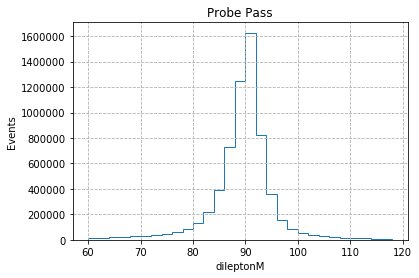

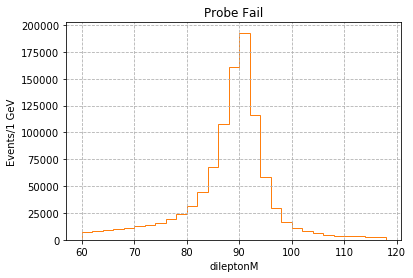

In [21]:
part = "dilepton"
var  = "M"


ProbeType = "Pass"
#ProbeType = "Fail"
VAR = part+var
if ProbeType == "Pass":
    Ind = sample["ProbeIDPass"]                       == True
    Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
    Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
    Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
else:
    Ind = sample["ProbeIDPass"]                       == False
    Ind = np.logical_or(Ind,sample["ProbeISOPass"]    == False)
    Ind = np.logical_or(Ind,sample["ProbeWorstPass"]  == False)
    Ind = np.logical_or(Ind,sample["ProbeSigPass"]    == False)

###############################
Pass = np.histogram(
                np.array(sample[VAR][Ind]),
                range    = ranges,
                bins     = bins,
                )

plt.figure()
plt.hist(
        bins[:-1],
        weights = Pass[0]/weight,
        range    = ranges,
        bins  = bins,
        histtype = 'step',
        color    = 'C0',
        )
plt.grid(linestyle = '--')
plt.ylabel(r'Events')
plt.xlabel(part+var)
plt.title('Probe '+ProbeType  )
plt.show()
###############################

#ProbeType = "Pass"
ProbeType = "Fail"
VAR = part+var
if ProbeType == "Pass":
    Ind = sample["ProbeIDPass"]                       == True
    Ind = np.logical_and(Ind,sample["ProbeISOPass"]   == True)
    Ind = np.logical_and(Ind,sample["ProbeWorstPass"] == True)
    Ind = np.logical_and(Ind,sample["ProbeSigPass"]   == True)
    if isConv:
        Ind = np.logical_and(Ind,sample["ProbeIsConv"] == True)
else:
    Ind = sample["ProbeIDPass"]                       == False
    Ind = np.logical_or(Ind,sample["ProbeISOPass"]    == False)
    Ind = np.logical_or(Ind,sample["ProbeWorstPass"]  == False)
    Ind = np.logical_or(Ind,sample["ProbeSigPass"]    == False)
    if isConv:
        Ind = np.logical_or(Ind,sample["ProbeIsConv"] == False)
    
Fail = np.histogram(
                np.array(sample[VAR][Ind]),
                range    = ranges,
                bins     = bins,
                )
plt.figure()
plt.hist(
        bins[:-1],
        weights  = Fail[0]/weight,
        range    = ranges,
        bins     = bins,
        histtype = 'step',
        color    = 'C1',
        )

plt.grid(linestyle = '--')
plt.ylabel(r'Events/1 GeV')
plt.xlabel(part+var)
plt.title('Probe '+ProbeType  )
plt.show()

###############################

# MC EFF

In [22]:
PassMC = EffMC(
                sample    = dfMC['DYJets'],
                part      = 'dilepton',
                variable  = 'M',
                ptBins    = ptBins,
                etaBins   = etaBins,
                Abs       = Abs, 
                isConv    = isConv,
                ranges    = ranges,
                bins      = bins,
                BinEBEE   = BinEBEE,
                ProbeType = 'Pass',
                )

FailMC = EffMC(
                sample    = dfMC['DYJets'],
                part      = 'dilepton',
                variable  = 'M',
                ptBins    = ptBins,
                etaBins   = etaBins,
                Abs       = Abs,
                isConv    = isConv,
                ranges    = ranges,
                bins      = bins,
                BinEBEE   = BinEBEE,
                ProbeType = 'Fail',
                )

In [23]:
print(
    np.sum(dfMC['DYJets'].ProbeIsConv == True),
    np.sum(dfMC['DYJets'].ProbeIsConv == False),
    np.sum(dfMC['DYJets'].ProbeIsConv == True)/float(np.sum(dfMC['DYJets'].ProbeIsConv == False)+np.sum(dfMC['DYJets'].ProbeIsConv == True)),
    
    )

13806537 871869 0.9406019291195515


In [24]:
effMC,effMCStat = {},{}
for j in  PassMC:
    effMC[j], effMCStat[j] = {},{}
    for i in  PassMC[j]:
        if PassMC[j][i] + FailMC[j][i] != 0:
            effMC[j][i] = float(PassMC[j][i])/(PassMC[j][i] + FailMC[j][i])
            effMCStat[j][i] = effMC[j][i]*np.sqrt(1/float(PassMC[j][i]) + 1/float(PassMC[j][i] + FailMC[j][i]))
        else:
            effMC[j][i] = 0
            effMCStat[j][i] = 0

In [25]:
if isConv:
    fileOut = TFile(figpath+binsSelected+"/isConv/"+"eff_photon_mc.root","recreate")
else:
    fileOut = TFile(figpath+binsSelected+"/ID/"+"eff_photon_mc.root","recreate")
tree = TTree("eff_photon","eff_photon")

gStyle.SetOptStat(0)
#################################################

ptBins, etaBins = BinFormat(ptBins,Type='edges'),BinFormat(etaBins,Type='edges')

ptNBins,etaNBins = len(ptBins)-2, len(etaBins)-1
histDraw = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1
hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)

ptNBins,etaNBins = len(ptBins)-2, len(etaBins)-1
statDraw = TH2F("EGamma_eff_draw_stat","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1
stat2d = TH2F("EGamma_eff_stat","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)



etaBins = BinFormat(etaBins)
#################################################
tree.Branch("eff",hist2d,"TH2F")


for j in range(ptNBins):
    hist2d.GetZaxis().SetRangeUser(0.6,1.1)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, effMC[j][i])
            histDraw.SetBinContent(int(j)+1, int(i)+1, effMC[j][i])
            
            stat2d.SetBinContent(int(j)+1, int(i)+1, effMCStat[j][i])
            statDraw.SetBinContent(int(j)+1, int(i)+1, effMCStat[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = effMC[j][0]
                EFFStat = effMCStat[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = effMC[j][1]
                EFFStat = effMCStat[j][1]
                I = 2
            else:
                EFF = 0
                EFFStat = 0
            #print(j,i,I,eff[j][I])
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            histDraw.SetBinContent(int(j)+1, int(i)+1, EFF)
            
            stat2d.SetBinContent(int(j)+1, int(i)+1, EFFStat)
            statDraw.SetBinContent(int(j)+1, int(i)+1, EFFStat)
            tree.Fill()
hist2d.GetZaxis().SetRangeUser(0.6,0.95)
    
fileOut.Write()


0

SysError in <TFile::TFile>: file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/eff_photon_mc.root can not be opened (No such file or directory)
Warning in <TROOT::Append>: Replacing existing TH1: EGamma_eff (Potential memory leak).
Warning in <TFile::Write>: file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/eff_photon_mc.root not opened in write mode


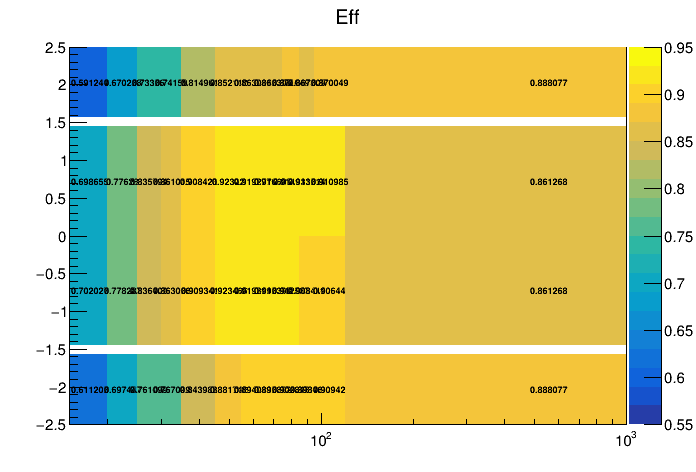

In [26]:
c = TCanvas()
if isConv:
    hist2d.GetZaxis().SetRangeUser(0.93,0.955)
else:
    hist2d.GetZaxis().SetRangeUser(0.55,0.95)
hist2d.Draw("COLZ text")
c.SetLogx()
c.Draw()


python ERROR: cannot open image file "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_mc_photonID.png" for writing. Please check permissions.
Error in <TASImage::WriteImage>: error writing file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_mc_photonID.png


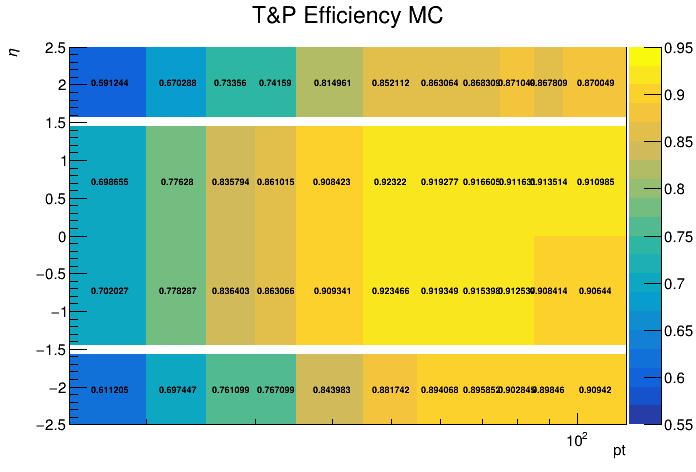

In [27]:
c = TCanvas()
histDraw.SetTitle("T&P Efficiency MC")
if isConv:
    histDraw.GetZaxis().SetRangeUser(0.93,0.955)
else:
    histDraw.GetZaxis().SetRangeUser(0.55,0.95)
    
histDraw.GetXaxis().SetTitle('pt')
histDraw.GetYaxis().SetTitle(r'\eta')

statDraw.SetBarOffset(-0.15)
statDraw.Draw("text same")

histDraw.Draw("COLZ text")
c.SetLogx()
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"EFF_mc_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"EFF_mc_photonID.png")
c.Draw()


python ERROR: cannot open image file "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_UNC_mc_photonID.png" for writing. Please check permissions.
Error in <TASImage::WriteImage>: error writing file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_UNC_mc_photonID.png


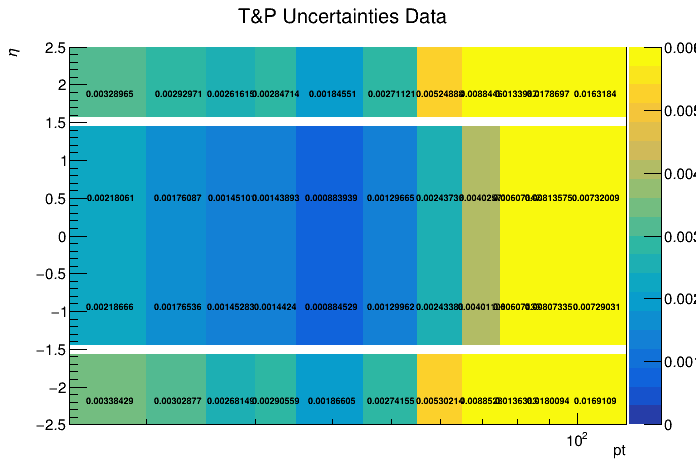

In [28]:
c = TCanvas()
statDraw.SetTitle("T&P Uncertainties Data")
if isConv:
    statDraw.GetZaxis().SetRangeUser(0.0005,0.01)
else:
    statDraw.GetZaxis().SetRangeUser(0,0.006)

statDraw.GetXaxis().SetTitle('pt')
statDraw.GetYaxis().SetTitle(r'\eta')
statDraw.Draw("colz text")
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"EFF_UNC_mc_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"EFF_UNC_mc_photonID.png")
c.SetLogx()
c.Draw()

In [29]:
fileOut.Close()

# MC PASS

------------------------ DYJets ------------------------


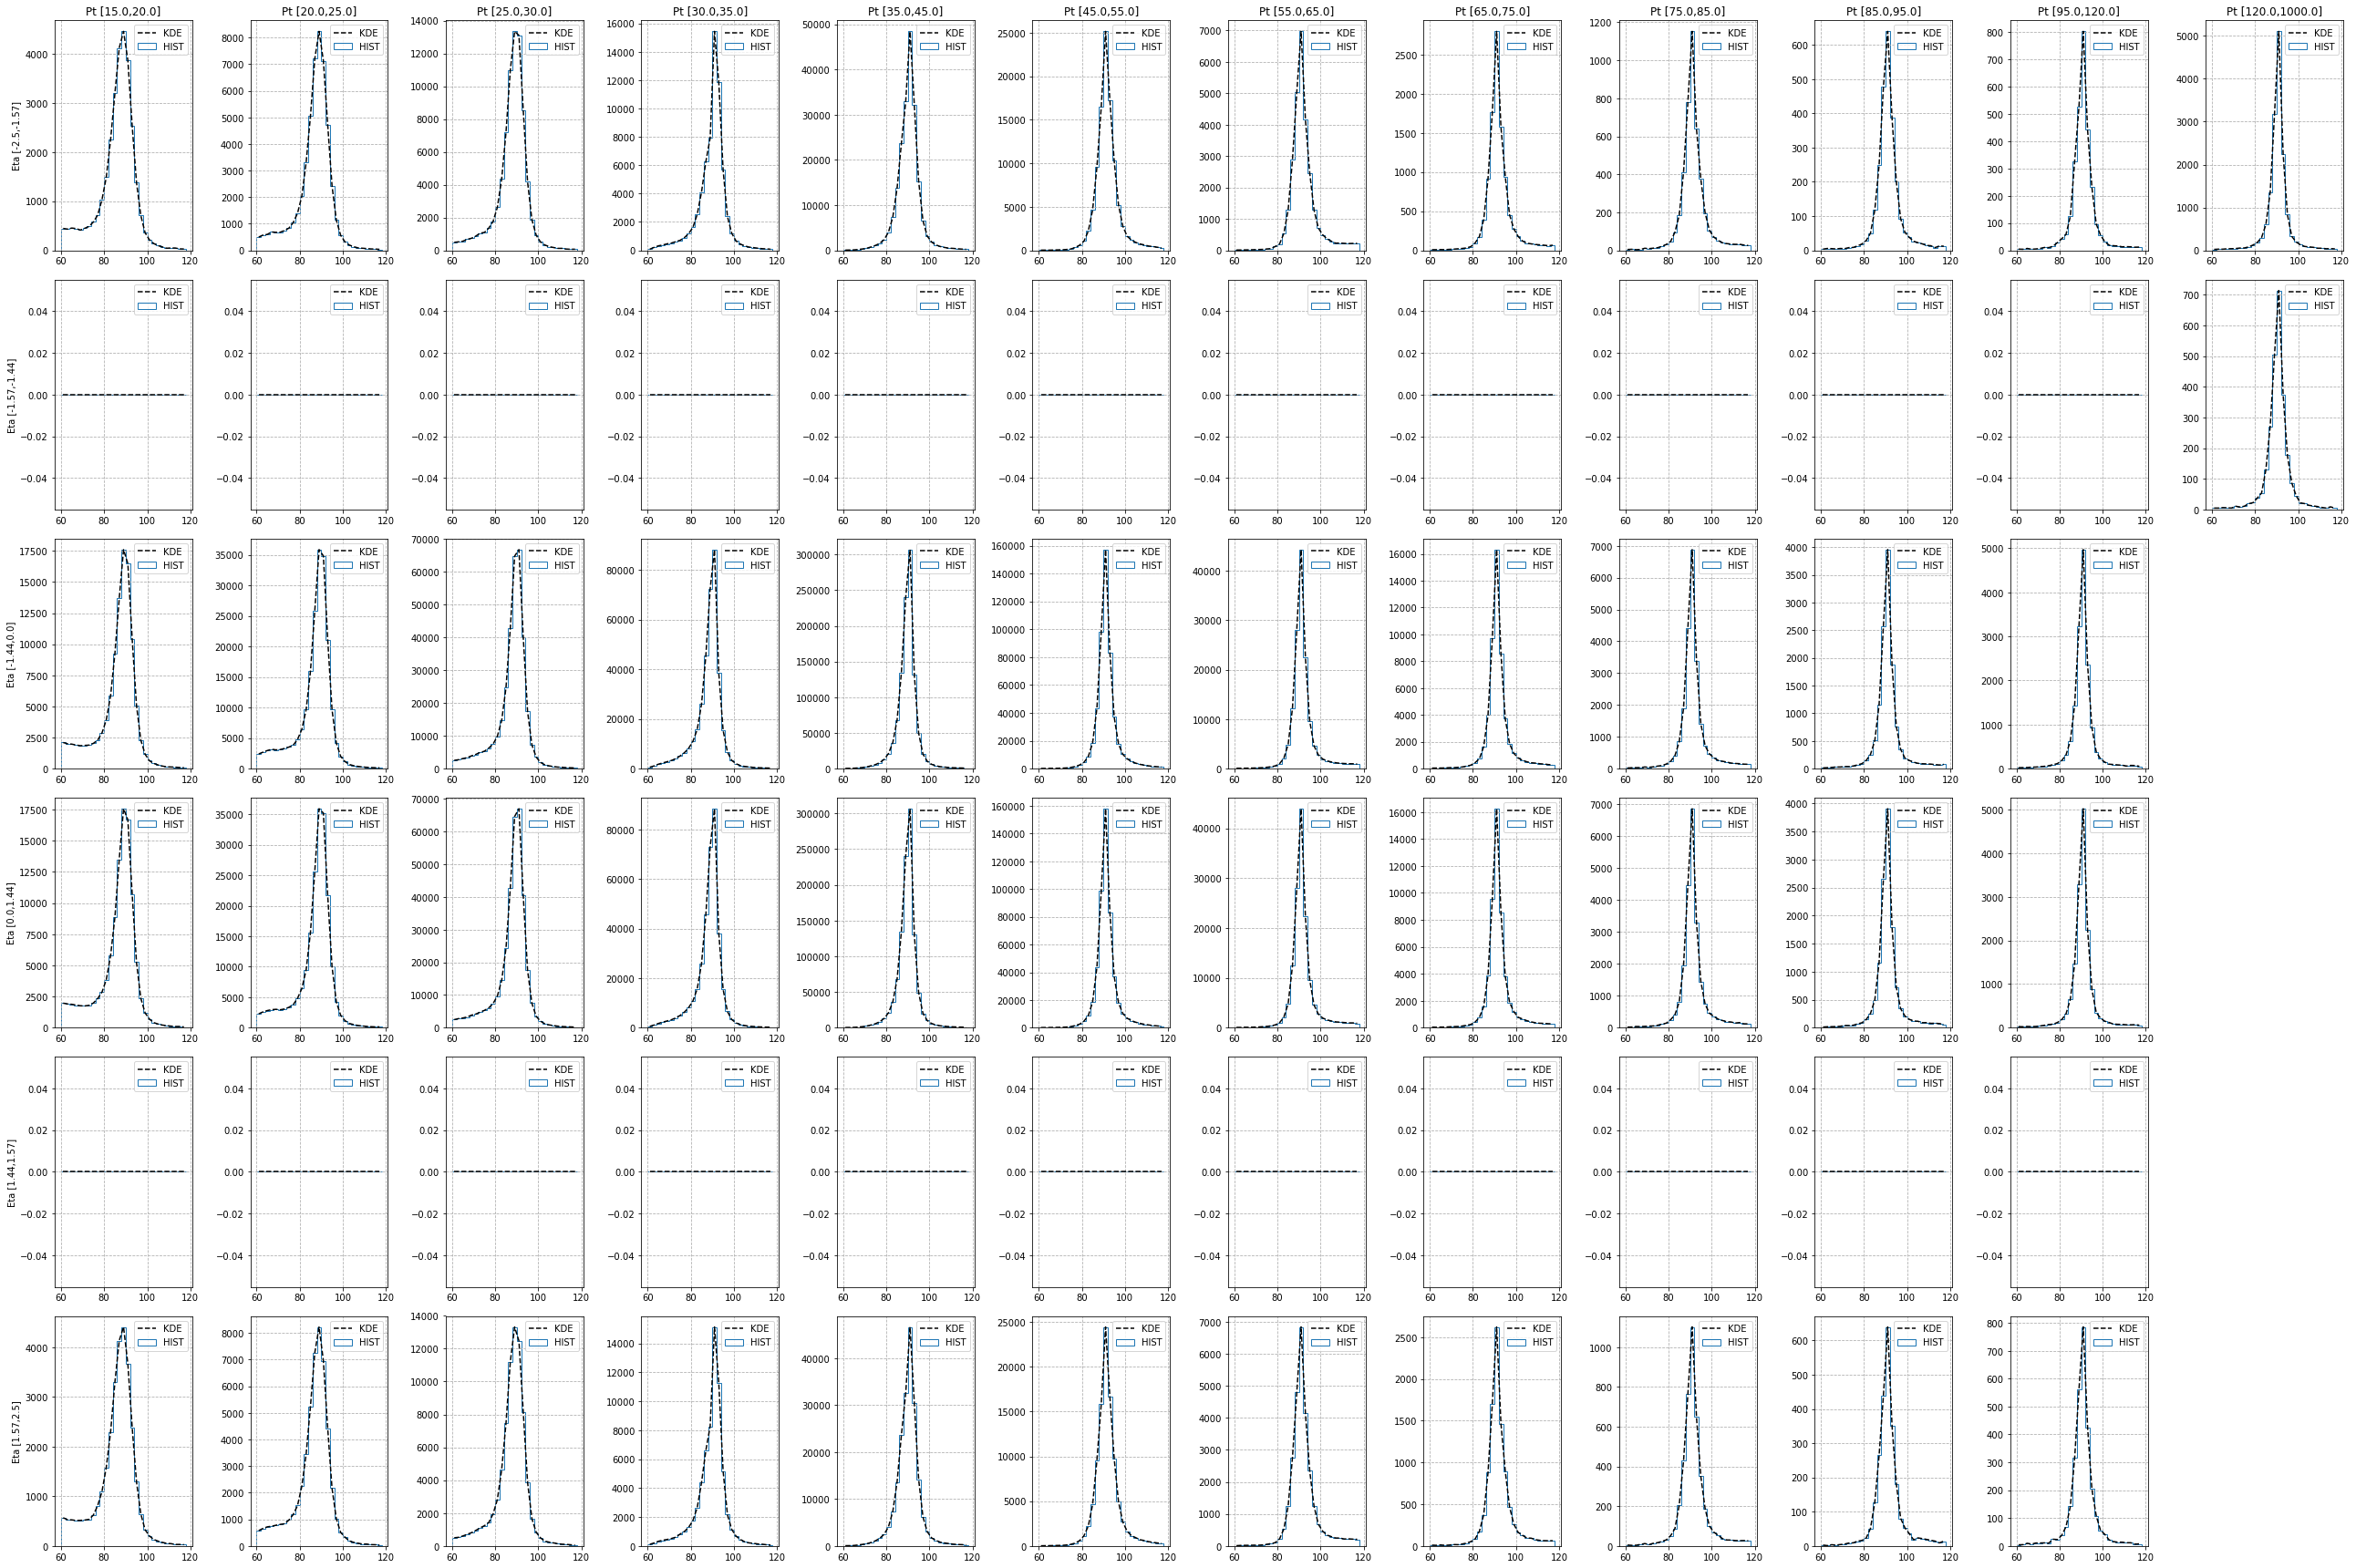

------------------------ WJets ------------------------


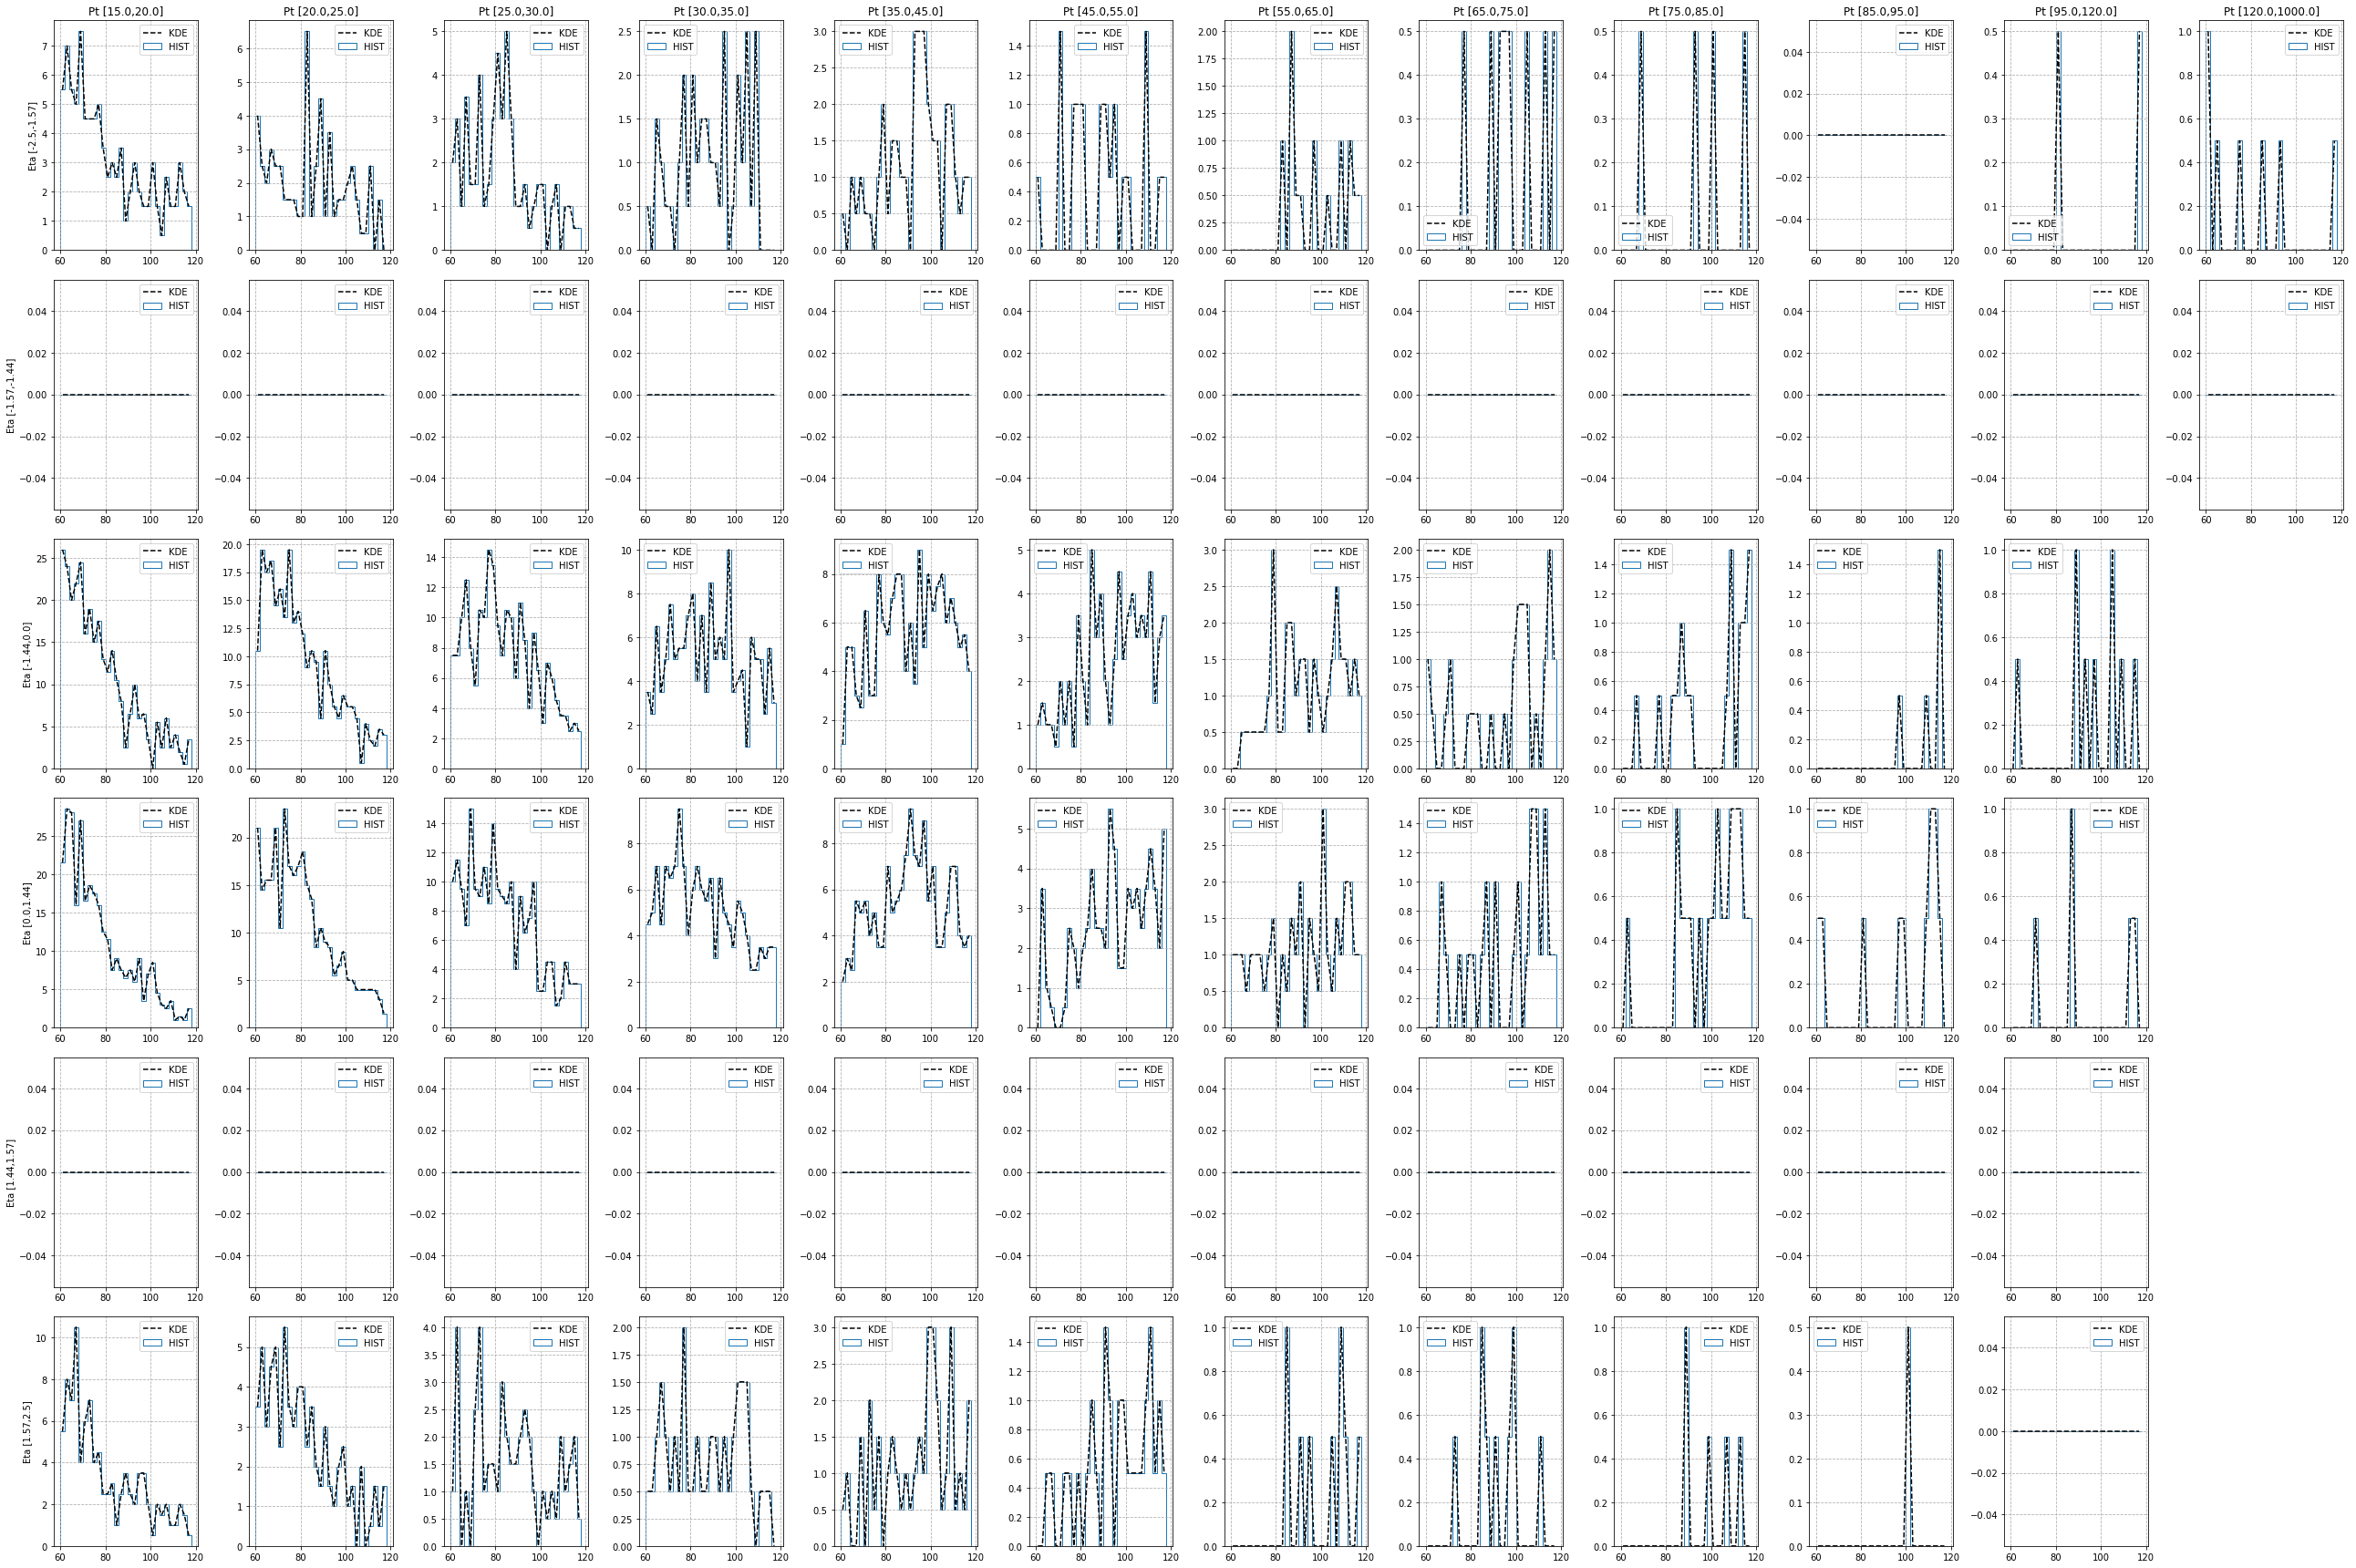

In [30]:
IDPass = False
PassFail = 'Pass'
MC[PassFail] = {}


S = 'DYJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Pass',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    Abs         = Abs,
                    isConv      = isConv,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )



S = 'WJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Pass',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    Abs         = Abs,
                    isConv      = isConv,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )




# MC Fail

------------------------ WJets ------------------------


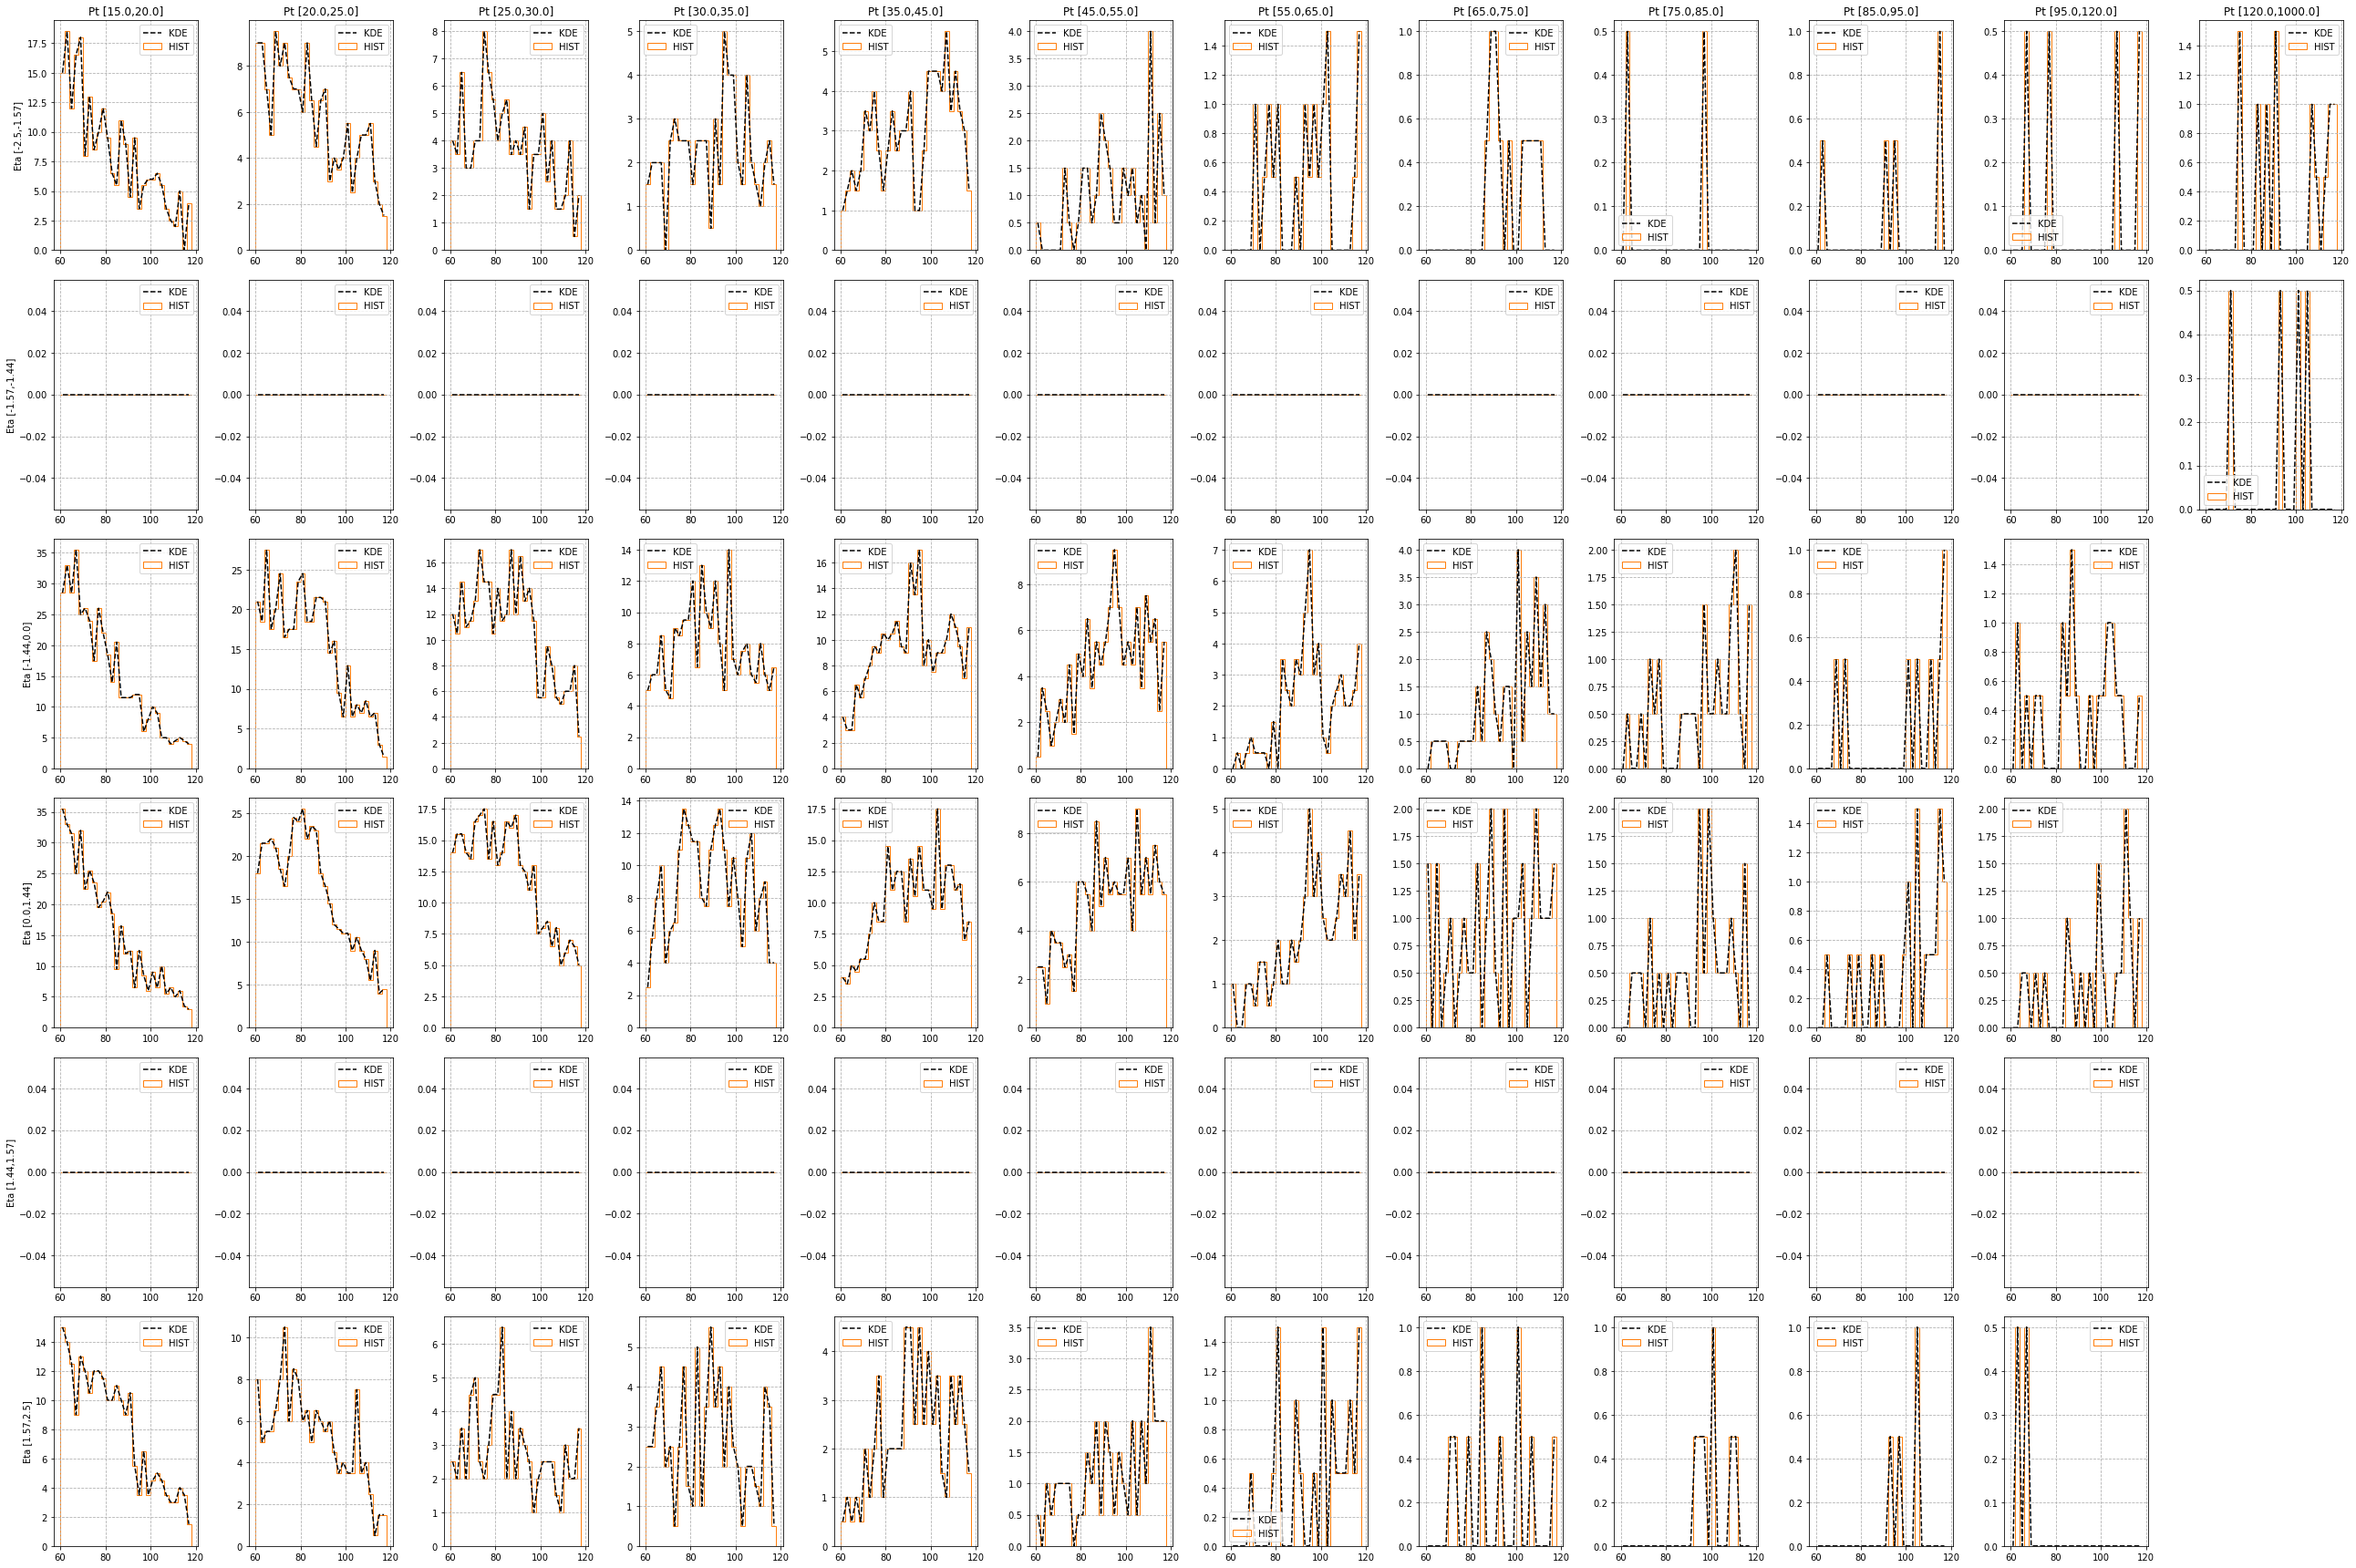

------------------------ DYJets ------------------------


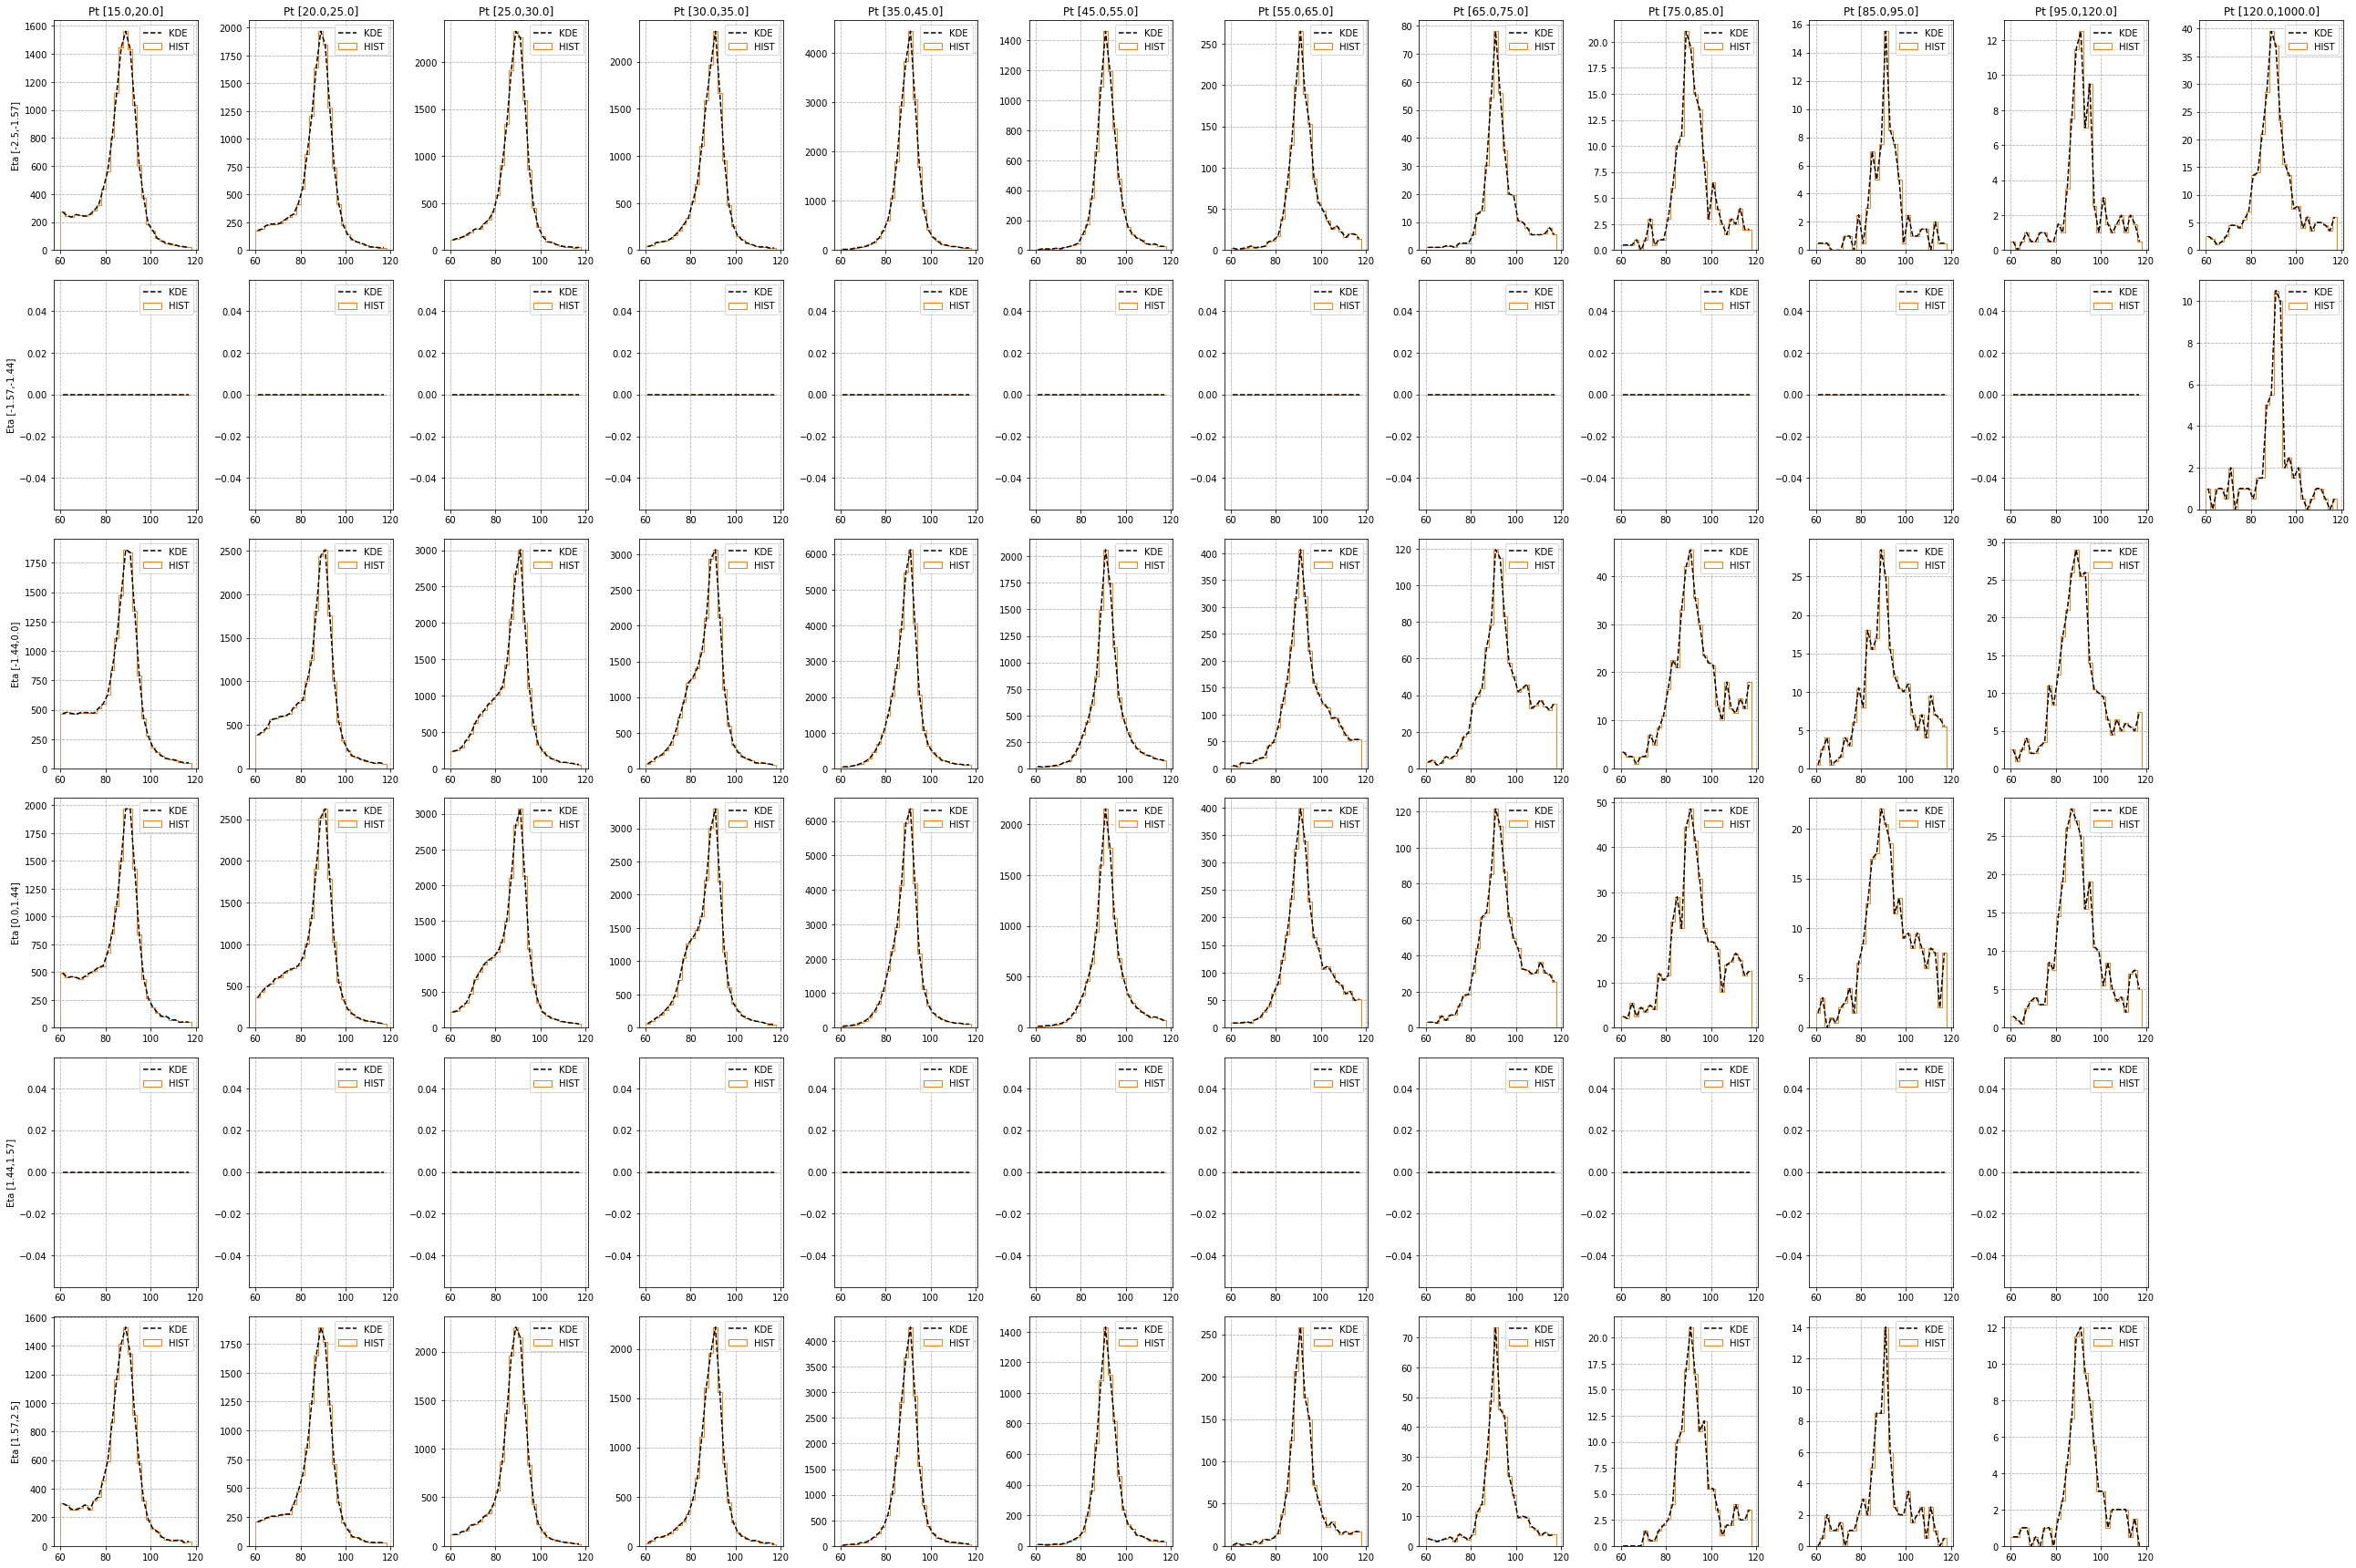

In [31]:
IDPass = False
PassFail = 'Fail'
MC[PassFail] = {}

S = 'WJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Fail',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    Abs         = Abs,
                    isConv      = isConv,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )

S = 'DYJets'
print('------------------------',S,'------------------------')
MC[PassFail][S] = EffGrid( 
                    sample      = dfMC[S],
                    part        = 'dilepton',
                    variable    = 'M',
                    DataMC      = 'mc',
                    samples     = S,
                    ProbeType   = 'Fail',
                    IDPass      = IDPass,
                    etaBins     = etaBins,
                    ptBins      = ptBins,
                    Abs         = Abs,
                    isConv      = isConv,
                    ranges      = ranges,
                    bins        = bins,
                    tempType    = tempType,
                    BinEBEE     = BinEBEE,
                  )

# DATA Pass

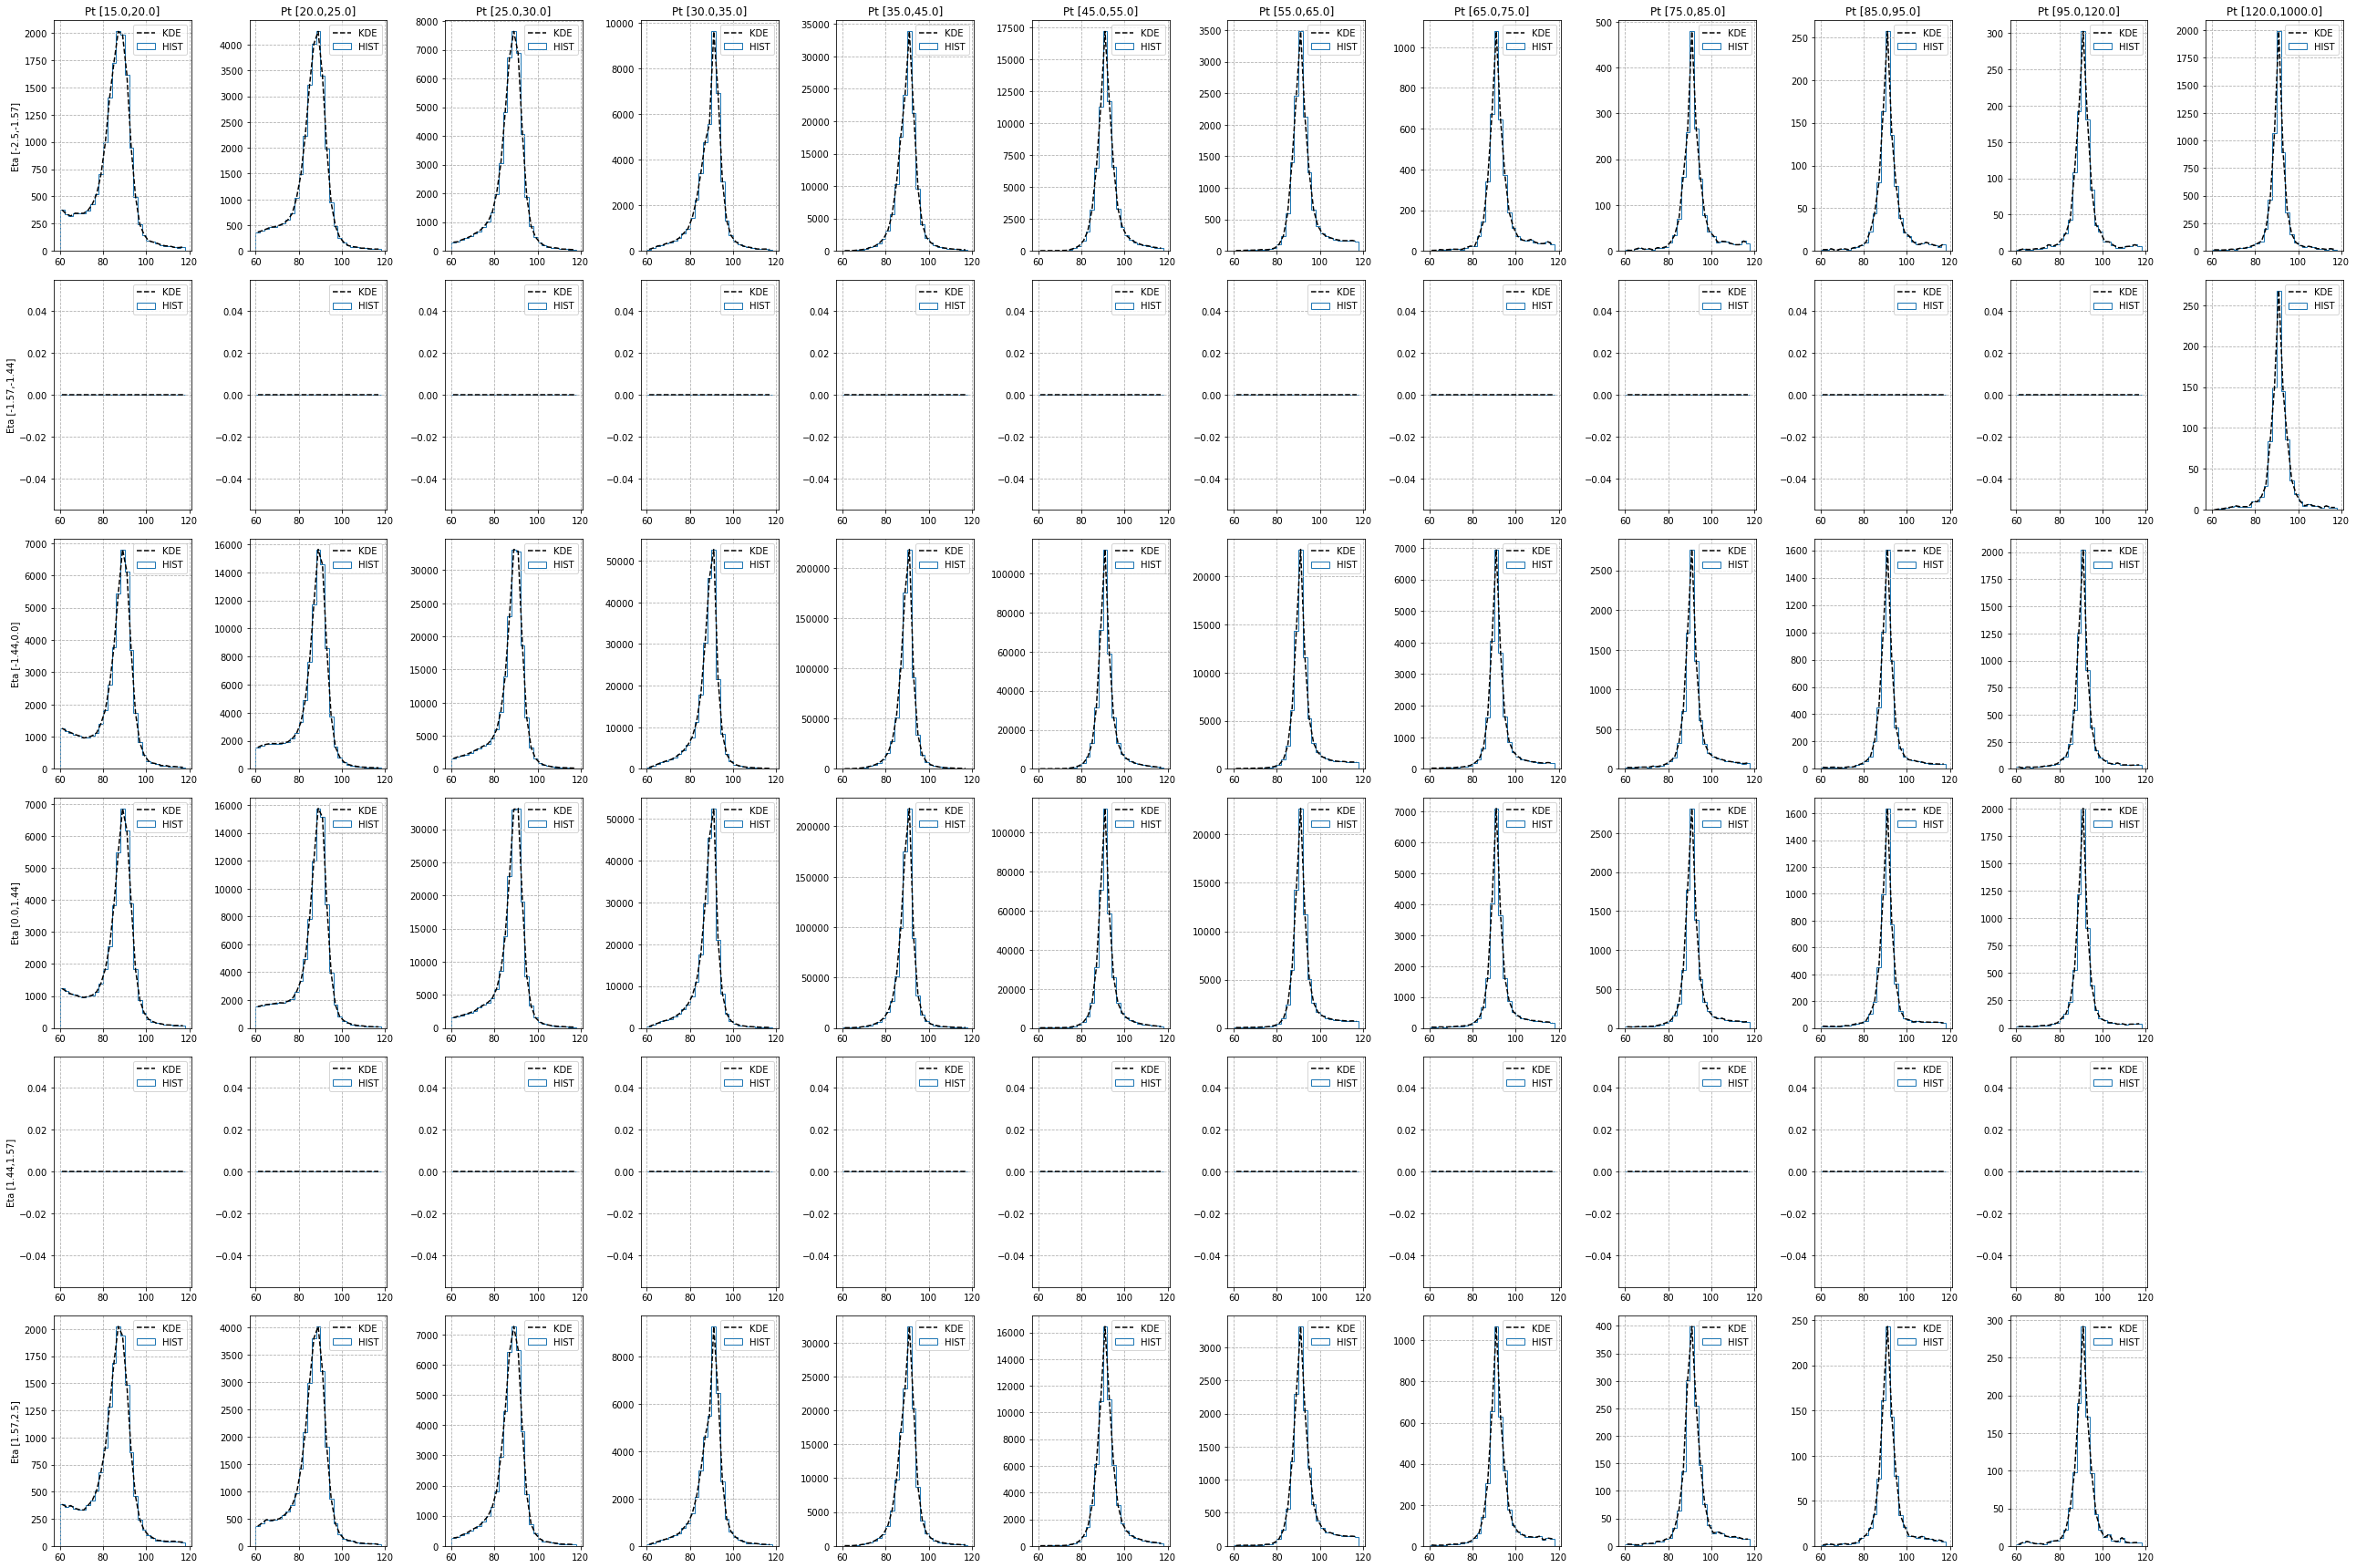

In [32]:
IDPass   = True
PassFail = 'Pass'
Data[PassFail] = EffGrid( 
                        sample       = df,
                        part         = 'dilepton',
                        variable     = 'M',
                        DataMC       = 'data',
                        samples      = '',
                        ProbeType    = 'Pass',
                        IDPass       = IDPass,
                        etaBins      = etaBins,
                        ptBins       = ptBins,
                        Abs          = Abs,
                        isConv       = isConv,
                        ranges       = ranges,
                        bins         = bins,
                        tempType     = tempType,
                        BinEBEE      = BinEBEE,
                        )

# DATA Fail

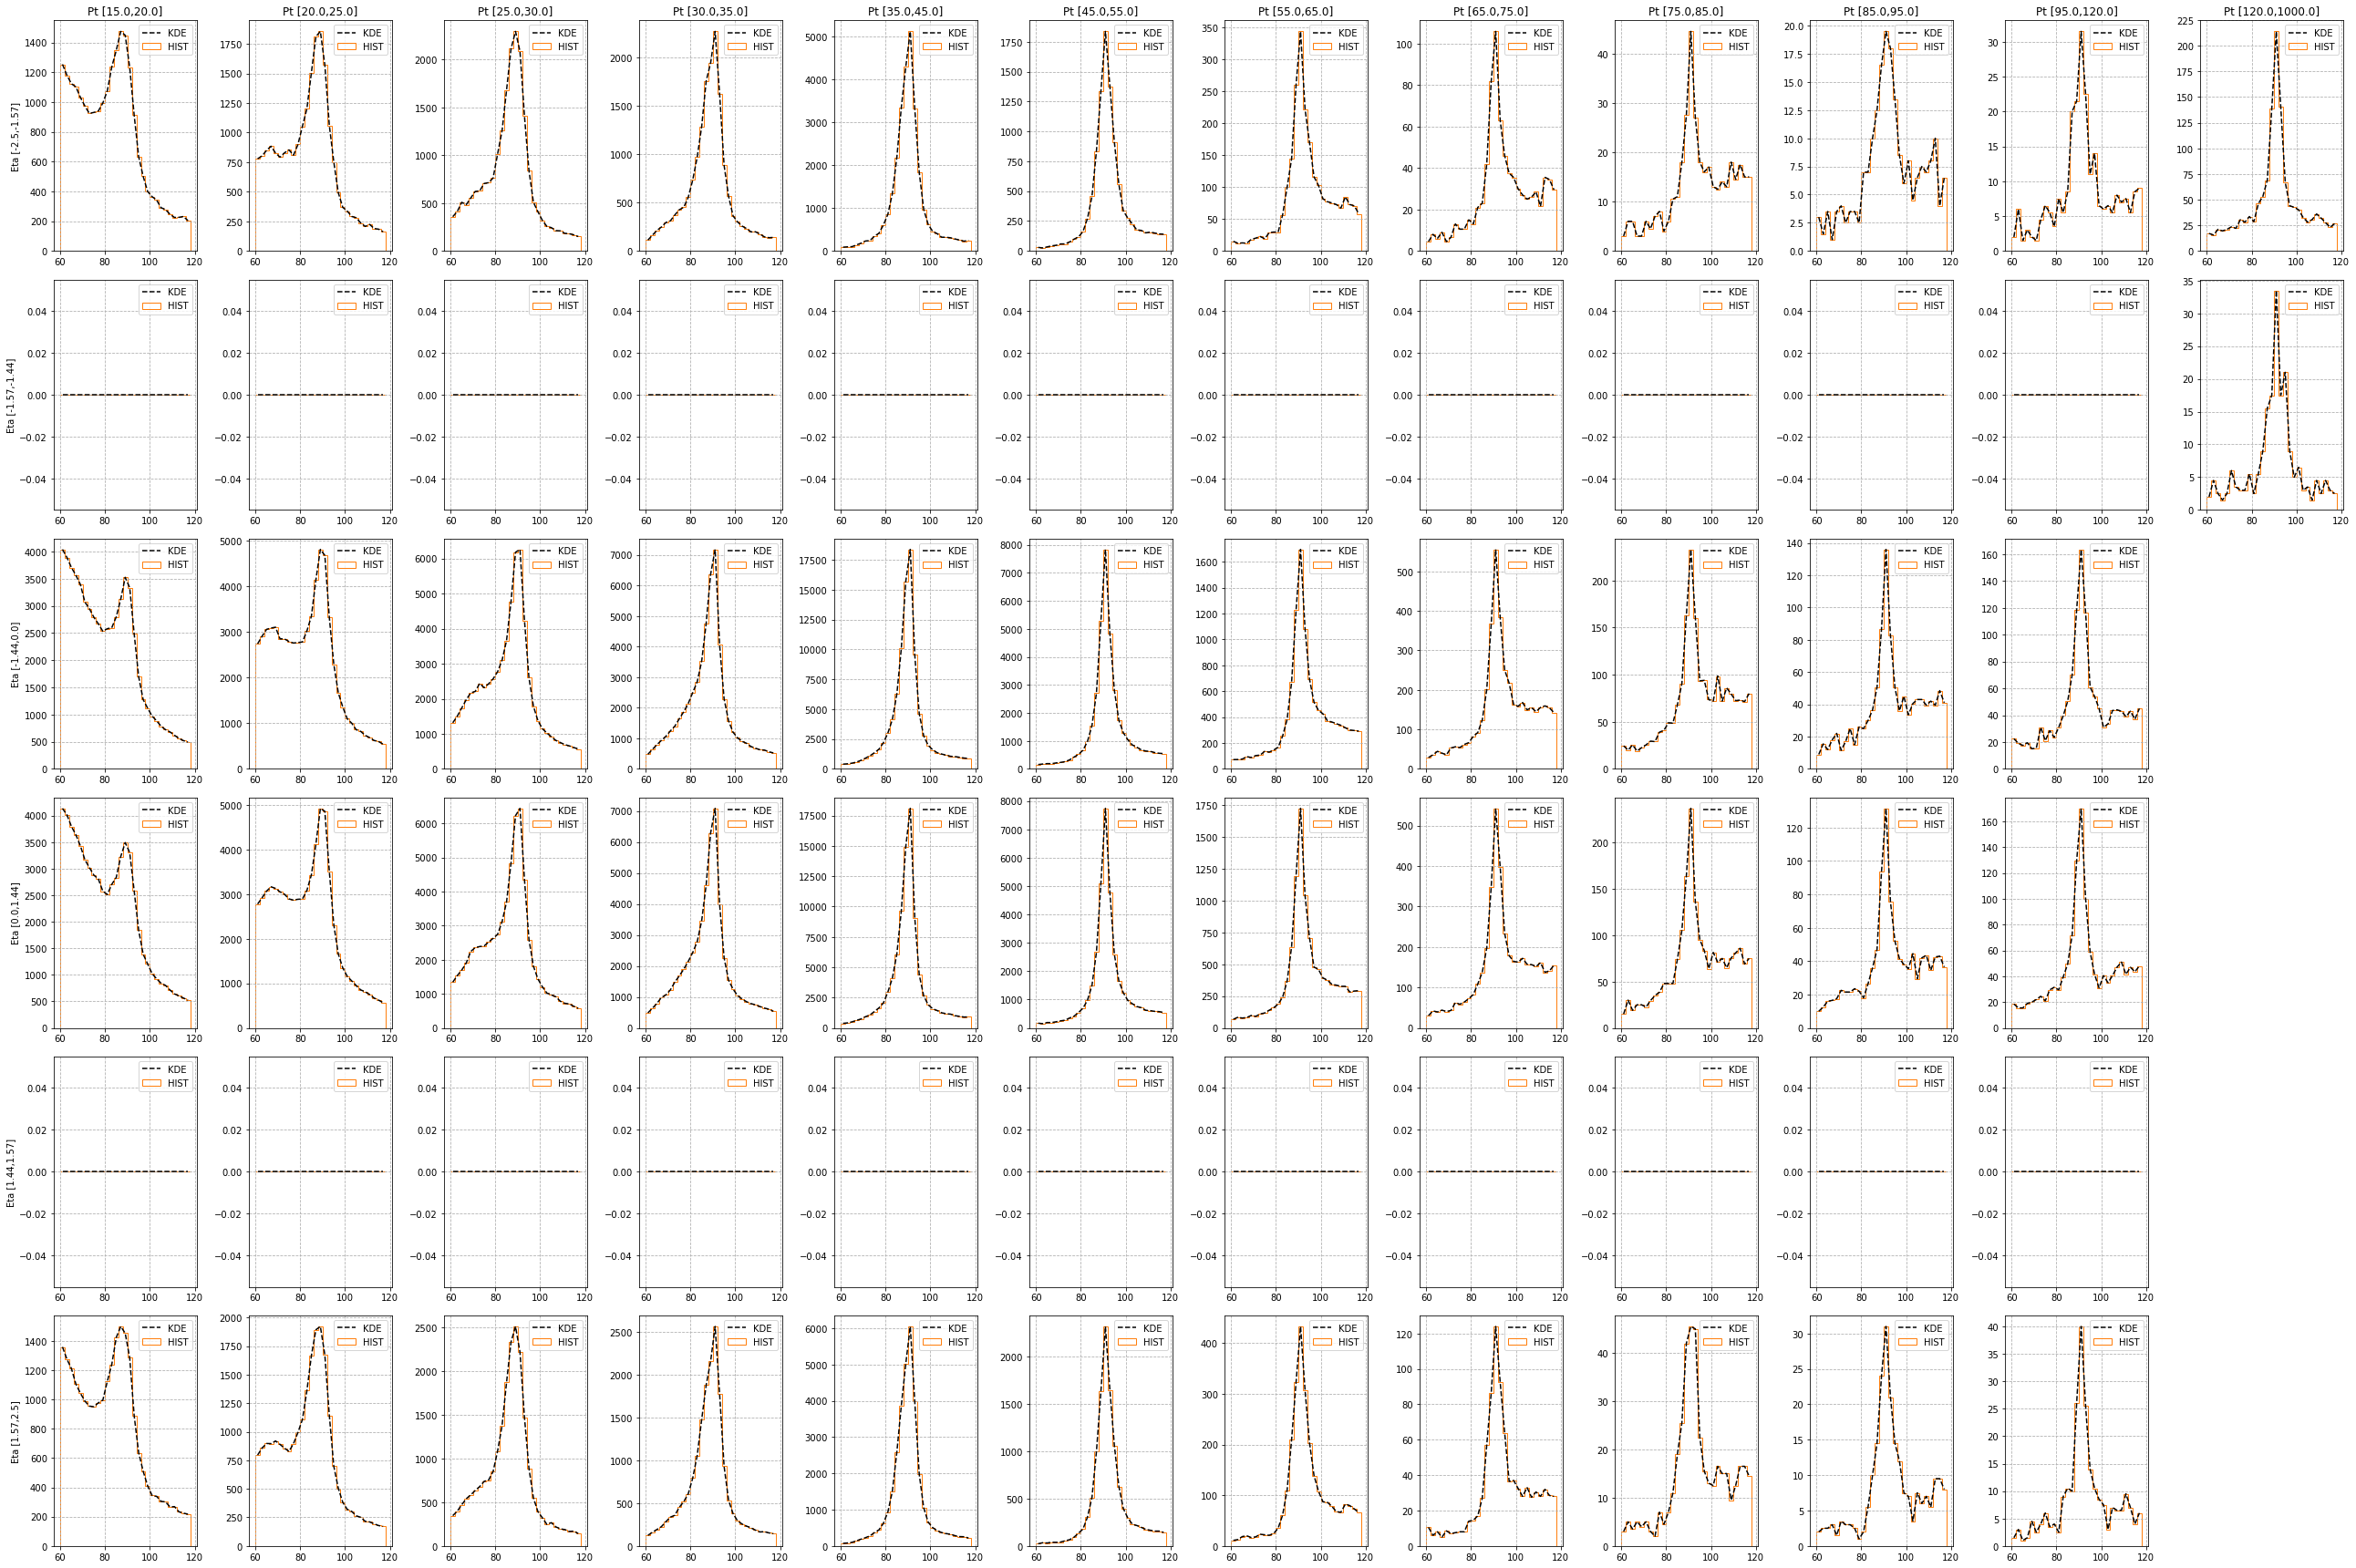

In [33]:
IDPass   = True
PassFail = 'Fail'
Data[PassFail] = EffGrid( 
                        sample      = df,
                        part        = 'dilepton',
                        variable    = 'M',
                        DataMC      = 'data',
                        samples     = '',
                        ProbeType   = 'Fail',
                        IDPass      = IDPass,
                        etaBins     = etaBins,
                        ptBins      = ptBins,
                        Abs         = Abs,
                        isConv      = isConv,
                        ranges      = ranges,
                        bins        = bins,
                        tempType    = tempType,
                        BinEBEE     = BinEBEE,    
                        )

# Fitting

In [34]:
def T(NSigPass, NBkgPass, NSigFail,NBkgFail, 
      alphaPass, betaPass, peakPass, gammaPass,
      alphaFail, betaFail, peakFail, gammaFail,
       MCPass, MCFail
     ):
    x = np.arange(0,len(MCPass))
    
    Pass = list(Template(NSigPass, NBkgPass, 
                         MCPass  , RooCMSShape(x,*(alphaPass, betaPass, peakPass, gammaPass)))) 
    
    Fail = list(Template(NSigFail, NBkgFail, 
                         MCFail, RooCMSShape(x,*(alphaFail, betaFail, peakFail, gammaFail))))
    Temp = np.array(Pass + Fail )
    return Temp

In [35]:
def PlotFitting(ax,
                NSig ,NBkg,
                DATA, SIG, BKG,
                eta, pt,
                color,
               ):
    TemplatePlot    = Template(NSig,NBkg, SIG, BKG)
    TemplatePlotBkg = NBkg*BKG/np.sum(BKG)
    DataPlot        = DATA
    #DataPlot        = Data[PassFail][0][IJ]/Data[PassFail][1][IJ] 

        
    ax.plot(xc,    TemplatePlot, color = color[0], linestyle='--', label=    'Fit')
    ax.plot(xc, TemplatePlotBkg, color = color[1], linestyle='--', label='Fit Bkg')
    ax.plot(xc,        DataPlot, color = color[2], linestyle= '-', label=   'Data')

    ax.legend()
    ax.grid(linestyle='--')

    if j == 0:
        ax.set_ylabel('Eta ['+str(round(eta[0],2))+','+str(round(eta[1],2))+']'  )        
    if i == 0:
        ax.set_title('Pt ['+str(pt[0])+','+str(pt[1])+']' )

# Fitting with RooCMSShape

In [36]:
########## TEMPLATES ################
def TVoigt_Test(
                  NSigPass,NBkgPass, NSigFail,NBkgFail, 
                  sigPass, GammaPass, meanPass,
                  lambdaPass, xPass,
                  sigFail, GammaFail, meanFail,
                  lambdaFail, xFail,
                  MCPass, MCFail
                 ):
    
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    #Temp = np.array(Pass + Fail )
    Temp = np.array(Pass)
    return Temp

def TVoigt_noSig(
                  NBkgPass,NBkgFail, 
                  sigPass, GammaPass, meanPass,
                  lambdaPass, xPass,
                  sigFail, GammaFail, meanFail,
                  lambdaFail, xFail,
                  MCPass, MCFail
                 ):
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(0, NBkgPass, Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(0, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    #Temp = np.array(Pass + Fail )
    Temp = np.array(Pass)
    return Temp

def TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, 
              sigPass, GammaPass, meanPass,
              alphaPass, betaPass, peakPass, gammaPass,
              sigFail, GammaFail, meanFail,
              alphaFail, betaFail, peakFail, gammaFail,
               MCPass, MCFail
             ):
    x = np.arange(0,len(MCPass))
    
    argPass      = alphaPass, betaPass, peakPass, gammaPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , RooCMSShape(x,*argPass))) 
    
    
    x = np.arange(len(MCPass),len(MCPass)*2)
    argFail      = alphaFail, betaFail, peakFail, gammaFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , RooCMSShape(x,*argFail)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp

def TVoigt_Exp(NSigPass, NBkgPass, NSigFail,NBkgFail, 
      sigPass, GammaPass, meanPass,
      lambdaPass, xPass,
      sigFail, GammaFail, meanFail,
      lambdaFail, xFail,
       MCPass, MCFail
     ):
    x = np.arange(0,len(MCPass))
    
    argPass = lambdaPass, xPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , Exp(x,*argPass))) 
    
    
    argFail = lambdaFail, xFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , Exp(x,*argPass)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp

def Voigt_CMS(
                xc,
                NSig, NBkg, 
                sig, Gamma, mean,
                alpha, beta, peak, gamma,
                ):
    x = xc
    arg      = alpha, beta, peak, gamma
    argVoigt = sig, Gamma, mean
    Temp = list(Template(NSig, NBkg, 
                         Voigt(x,*argVoigt) , RooCMSShape(x,*arg)))
    
    
    return np.array(Temp)

def Template(Nsig,Nbkg,Sig,Bkg):
    return Nsig * (Sig/np.sum(Sig)) + Nbkg * (Bkg/np.sum(Bkg))

########## METRIC ########
def NLL(DATA,Temp):
    return np.sum(Temp) - np.sum(DATA*np.log(Temp))

def CHI2(DATA,Temp):
    DATA[DATA==0] = 1
    SIGMA_2 = (1/DATA + 1/Temp)**(-1)
    return np.sum((Temp-DATA)**2/SIGMA_2)

def DIFFER(DATA,Temp,*arg):
    Model = Temp(*arg)
    return np.sum((Model-DATA)**2)


########## FITTING FUNCTIONS ########
def Fit(i,j,
        MC_PASS_S, MC_PASS_B,
        MC_FAIL_S, MC_FAIL_B,
        DATA_PASS, DATA_FAIL,
        Temp,
        p0, Bounded,
        Type   = '',
        Print  = False,
        TryMax = 20,
        ):

    ###############################
    
    DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))

    model  = lambda x0:CHI2(DATA=DATA,Temp=Temp,*x0)

    fitSucess = False
    tries = 0
    
    while not fitSucess:
        if Print:
            print('--- Start Fitting')
        fitResult = minimize(model,
                             p0,
                             #method = 'L-BFGS-B',
                             #method = 'SLSQP',
                             bounds = Bounded,
                             #tol = 1e-6,
                             #tol = 1e-10,
                            )
        fitSucess = fitResult.success
        FIT = fitResult.x

        p0 = GoodGuess(i,j,len(etaBINS),len(ptBins),tries,p0)
        if not p0:
            p0 = np.ones(len(Bounded))
            break;
        tries += 1
        
        if tries%10 == 0 and Print:
            print('Try: ' + str(tries))
        if tries > TryMax and Print :
            print("Maximum tries reached!")
            break
    return FIT

def Fit_Curve(i,j,
        MC_PASS_S, MC_PASS_B,
        MC_FAIL_S, MC_FAIL_B,
        DATA_PASS, DATA_FAIL,
        p0, Bounded,
        ):

    ###############################
    
    DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))
    x = np.arange(0,len(DATA))

    VV = lambda x,*x0 : Voigt_CMS_x(x,
                                    NSigPass  =  x0[0], NBkgPass  =  x0[1], NSigFail =  x0[2],  NBkgFail =  x0[3], 
                                    sigPass   =  x0[4], GammaPass =  x0[5], meanPass =  x0[6],
                                    alphaPass =  x0[7], betaPass  =  x0[8], peakPass =  x0[9], gammaPass = x0[10],
                                    sigFail   = x0[11], GammaFail = x0[12], meanFail = x0[13],
                                    alphaFail = x0[14], betaFail  = x0[15], peakFail = x0[16], gammaFail = x0[17],
                                    MCPass = MC_PASS_S[:len(DATA_PASS)], 
                                    MCFail = MC_FAIL_S[:len(DATA_PASS)])
    
    
    

    return FIT[0]

def Fit_Curve(
              DATA_PASS, DATA_FAIL,
              pPass,pFail,
              Bounded,
             ):
    
    VoigtCMS = lambda x,*x0 : Voigt_CMS(
                                        x,
                                        NSig  =  x0[0], NBkg  =  x0[1],
                                        sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                                        alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                                        )
    
    yerr = np.sqrt(DATA_PASS)
    yerr[yerr<1] = yerr[yerr<1]*0+2
    xFit = np.arange(0,len(DATA_PASS))
    Fits = curve_fit(
                    f     = VoigtCMS,
                    xdata = xFit,
                    ydata = DATA_PASS,
                    sigma = yerr,
                    p0    = pPass,
                    method = 'trf',
                    bounds = Bounded,
                    )

    FitsPass = Fits[0]
    FitsPassSig = np.sqrt(np.diag(Fits[1]))
    ############################
    yerr = np.sqrt(DATA_FAIL)
    yerr[yerr<1] = yerr[yerr<1]*0+2
    xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
    Fits = curve_fit(
                    f      = VoigtCMS,
                    xdata  = xFit,
                    ydata  = DATA_FAIL,
                    sigma  = yerr,
                    p0     = pFail,
                    #method = 'lm',
                    method = 'trf',
                    #method = 'dogbox',
                    bounds = Bounded,
                    )
    FitsFail = Fits[0]
    FitsFailSig = np.sqrt(np.diag(Fits[1]))
    
    return FitsPass, FitsFail, FitsPassSig, FitsFailSig

def Fit_Curve_CHI(
              DATA_PASS, DATA_FAIL,
              pPass,pFail,
              Bounded = [
                           [0,0,
                            0,0,10,
                            0,-0.2,-1000,-1],
                           [np.inf,np.inf,
                            3,3,48,
                            70,0.2,1000,1,
                            ]
                        ]  ,
              error =  [
                        1,1,
                        0.001,0.01,1,0.01,
                        0.001,0.001,0.001
                        ],
             ):
    
    ####################
    xFit = np.arange(0,len(DATA_PASS))
    
    chi2 =lambda NSig , NBkg , \
                 sig  , Gamma, mean, \
                 alpha, beta , peak, gamma : CHI2(  DATA_PASS,
                                                    Voigt_CMS(
                                                        xc = xFit, \
                                                        NSig=NSig , NBkg=NBkg , \
                                                        sig = sig  , Gamma  = Gamma, mean = mean, \
                                                        alpha = alpha, beta = beta , peak = peak, gamma = gamma,  
                                                        ) 
                                                    )    
    
    
    x0 = pPass
    mP = Minuit( chi2,
                NSig  =  x0[0], NBkg  =  x0[1],
                sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                error_NSig  =  error[0], error_NBkg  =  error[1],
                error_sig   =  error[2], error_Gamma =  error[3], error_mean =  error[4],
                error_alpha =  error[5], error_beta  =  error[6], error_peak =  error[7], error_gamma = error[8], 
                limit_NSig  =  (Bounded[0][0],Bounded[1][0]), limit_NBkg  =  (Bounded[0][1],Bounded[1][1]),
                limit_sig   =  (Bounded[0][2],Bounded[1][2]), limit_Gamma =  (Bounded[0][3],Bounded[1][3]), limit_mean =  (Bounded[0][4],Bounded[1][4]),
                limit_alpha =  (Bounded[0][5],Bounded[1][5]), limit_beta  =  (Bounded[0][6],Bounded[1][6]), limit_peak =  (Bounded[0][7],Bounded[1][7]), limit_gamma = (Bounded[0][8],Bounded[1][8]), 
                errordef = 0.5,
              )    
    
    mP.migrad()
    
    
    
    FitsPass    = mP.values.values()
    FitsPassSig = mP.errors.values()
    
    ################################################
    xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
    
    chi2 =lambda NSig , NBkg , \
                 sig  , Gamma, mean, \
                 alpha, beta , peak, gamma : CHI2(  DATA_FAIL,
                                                    Voigt_CMS(
                                                        xc = xFit, \
                                                        NSig=NSig , NBkg=NBkg , \
                                                        sig = sig  , Gamma  = Gamma, mean = mean, \
                                                        alpha = alpha, beta = beta , peak = peak, gamma = gamma,  
                                                        ) 
                                                    )   
    
    x0 = pFail
    mF = Minuit( chi2,
                NSig  =  x0[0], NBkg  =  x0[1],
                sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                error_NSig  =  error[0], error_NBkg  =  error[1],
                error_sig   =  error[2], error_Gamma =  error[3], error_mean =  error[4],
                error_alpha =  error[5], error_beta  =  error[6], error_peak =  error[7], error_gamma = error[8], 
                limit_NSig  =  (Bounded[0][0],Bounded[1][0]), limit_NBkg  =  (Bounded[0][1],Bounded[1][1]),
                limit_sig   =  (Bounded[0][2],Bounded[1][2]), limit_Gamma =  (Bounded[0][3],Bounded[1][3]), limit_mean =  (Bounded[0][4],Bounded[1][4]),
                limit_alpha =  (Bounded[0][5],Bounded[1][5]), limit_beta  =  (Bounded[0][6],Bounded[1][6]), limit_peak =  (Bounded[0][7],Bounded[1][7]), limit_gamma = (Bounded[0][8],Bounded[1][8]), 
                errordef = 0.5,
              )    
    
    mF.migrad()
    
    
    FitsFail    = mF.values.values()
    FitsFailSig = mF.errors.values()

    #print()
    #print("\/\/\/\/\/\/\/\/\\/\/\/\/\/\/\/\/\\/\/\/\/\/\/\/\/")
    #print(mP.get_param_states())
    #print(mF.get_param_states())
    #print("\/\/\/\/\/\/\/\/\\/\/\/\/\/\/\/\/\\/\/\/\/\/\/\/\/")
          
    return FitsPass, FitsFail, FitsPassSig, FitsFailSig,mP,mF


In [37]:
def SkipGap(i,j,binsSelect):
    gapFlag = False
    
    if     binsSelected == "Optimized":
        if (i == 1 or i == 4) and j != 5:
            gapFlag = True
    elif   binsSelected == "Plots":
        if (i == 1 or i == 4) and j != 11:
            gapFlag = True
    elif   binsSelected == "Hien":
        if (i == 1 or i == 4) and j != 6:
            gapFlag = True
    
    return gapFlag

def InitializeParams(i,j,binsSelected):
    if   binsSelected == "Optimized":
        if isConv:
            if   j == 0:
                if i != 5:
                    pPass = [
                            5e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            3e3,   3e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            5e4,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            3e5,   6e4, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   4e5, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            1e6,   5e3, 
                            0.1, 1.5, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            1e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            1e5,   1e4, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            3e4,   8e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                
                elif i == 5:
                    pPass = [
                            1e4,   5e3, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            5e3,   5e3, 
                            0.5, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                        
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.5,  1, 44,  
                            49,-0.1, 10, -0.09,  # RooCMS
                            ]  
                elif i == 2:
                    pPass = [
                            7e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  5e2,  
                            0.5,  1, 44,  
                            35,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  1, 44,  
                            48,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 5:
                    pPass = [1.22435554e+03, 3.20343246e+02, 9.22998413e-12,
                             1.10974344e+00, 1.50406031e+01, 1.40180622e+01,
                             6.13551539e-01, 1.00000028e+01, 5.95495234e-01]
                    pFail = [ 4.08455718e+02,  2.34193103e+02,  1.08171908e+00,
                             9.14064665e-01, 4.39415340e+01,  5.75583581e+01, 
                             -5.13886755e-01,  3.82617111e+03,-4.43517032e-02]
                else :
                    pPass = [
                            1e3,  100,  
                            0.5,  1, 15,  
                            15,0.1, 10,-0.09,
                            ] 

                    pFail = [
                            2e2,  1e2,  
                            0.1,  1, 44,  
                            45,0.01, 10, -0.09,  # RooCMS
                            ]                                        
            elif j == 5:
                if i == 0:
                    pPass = [
                            6e4,  1e2,  
                            0.1,  2, 15,  
                            1,1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  2, 44,  
                            35,  1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            2e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e1,  1e1,  
                            0.5,  1, 44,  
                            48,  -0.1, 10,0.1,
                            ]   
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            40,  3e1,  
                            1,  1, 44,  
                            35,  0.1, 1.15814356e+02,0.1,
                            ]  
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                else :
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 43,  
                            42,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
    elif binsSelected == "Plots" :
        if isConv:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            2e5,   1e3, 
                            0.1, 1, 14,       # Voigt
                            30,0.1, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            1e4,   3e3, 
                            1, 1, 44,           # Voigt
                            50,0.1, 20, -0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            2e5,  2e3,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            1e4,  2e3,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            8e5,  5e3,
                            0.1,  1, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            9e4,  2e3,
                            0.1,  1, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            4e5,  1e4,
                            0.1,  1, 15,  
                            15,-0.1, 100,-1,
                            ] 

                    pFail = [
                            4e4,  7e3,
                            0.1,  1, 44,  
                            60,0.1, 100,-1,
                            ] 
                elif i == 5 :
                    pPass = [
                            2e5,  4e3,
                            0.1,  2, 15,  
                            15,-0.1, 100,-1,
                            ] 

                    pFail = [
                            2e4,  3e3,  
                            0.1,  2, 44,  
                            65,-0.1, 100,-1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            9e3,  3e2,  
                            0.2,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            3e3,  3e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            9e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e5,  6e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            4e3,  6e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            1e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 6:
                if i == 0:
                    pPass = [
                            8e3,  3e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.2,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            3e4,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            8e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e4,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            3e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e3,  3e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 7:
                if i == 0:
                    pPass = [
                            3e3,  5e1,
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  5e1,
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            2e4,  2e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [8e2, 2e2,
                             1, 1, 44, 
                             60, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                elif i == 3:
                    pPass = [
                            1e4,  3e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [2e3, 3e2,
                             1, 1, 44, 
                             0.7044642032043633, 0.0038985980209962634, 1557.2502065025765, -0.015222050465143688
                            ]
                elif i == 5:
                    pPass = [
                            2e3,  6e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [2e2, 7e1,
                             1, 1, 44, 
                             70, 0.0038985980209962634, 700, -0.015222050465143688
                            ]
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 8:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  6e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            9e2,  7e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  7e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02, -0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 9:
                if i == 0:
                    pPass = [
                            5e2,  5e1,
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e1,  2e1,
                            0.1,  1, 44,  
                            50,-0.1, 1.15814356e+02,-0.1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            3e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            7e1,  1e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 10:
                if i == 0:
                    pPass = [
                            1e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.1,  1, 44,  
                            50,-0.1, 1.15814356e+02,0.1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            3e2,  1e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            3e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            3e2,  5e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 11:
                if   i == 0:
                    pPass = [
                            4e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,-0.05,
                            ] 

                    pFail = [
                            3e2,  5e1,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,-0.05,
                            ] 
                elif i == 1:
                    pPass = [
                            8e2,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e1,  1e1,  
                            0.1,  1, 44,  
                            10,  0.1, 40,-0.1,
                            ]  
                elif i == 2:
                    pPass = [
                            4e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e2,  
                            1,  1, 44,  
                            40,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]                      
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e5,  4e3,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            8e3,  4e3,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e5,  2e4,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e4,  1e4,
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e5,  2e4,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e4,  1e4,
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                elif i == 5 :
                    pPass = [
                            1e5,  4e3,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            1e4,  3e3,  
                            0.1,  2, 44,  
                            65,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            9e3,  3e2,  
                            0.2,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            3e3,  3e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            9e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e5,  6e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            4e3,  6e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            1e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 6:
                if i == 0:
                    pPass = [
                            5e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.2,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 7:
                if i == 0:
                    pPass = [
                            3e3,  5e1,
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  5e1,
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            3e4,  5e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [8e2, 8e2,
                             1, 1, 44, 
                             60, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                elif i == 3:
                    pPass = [
                            9e3,  3e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [2e3, 7e2,
                             1, 1, 44, 
                             0.7044642032043633, 0.0038985980209962634, 1557.2502065025765, 0.015222050465143688
                            ]
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [200, 70,
                             1, 1, 44, 
                             70, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 8:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  6e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            9e2,  7e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e2,  2e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02, -0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 9:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 10:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e2,  3e2,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            100,  8e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 11:
                if   i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            2e2,  5e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            8e2,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            8e1,  1e2,  
                            0.1,  1, 44,  
                            40,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 2:
                    pPass = [
                            4e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e2,  
                            1,  1, 44,  
                            40,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]                      
    elif binsSelected == "Hien":
        if isConv:
            if   j == 0:
                if i != 5:
                    pPass = [
                            5e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            3e3,   3e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            5e4,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            3e5,   6e4, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   4e5, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            1e6,   5e3, 
                            0.1, 1.5, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            1e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            1e5,   1e4, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            3e4,   8e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                
                elif i == 5:
                    pPass = [
                            1e4,   5e3, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            5e3,   5e3, 
                            0.5, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                        
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.5,  1, 44,  
                            49,-0.1, 10, -0.09,  # RooCMS
                            ]  
                elif i == 2:
                    pPass = [
                            7e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  5e2,  
                            0.5,  1, 44,  
                            35,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  1, 44,  
                            48,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 5:
                    pPass = [1.22435554e+03, 3.20343246e+02, 9.22998413e-12,
                             1.10974344e+00, 1.50406031e+01, 1.40180622e+01,
                             6.13551539e-01, 1.00000028e+01, 5.95495234e-01]
                    pFail = [ 4.08455718e+02,  2.34193103e+02,  1.08171908e+00,
                             9.14064665e-01, 4.39415340e+01,  5.75583581e+01, 
                             -5.13886755e-01,  3.82617111e+03,-4.43517032e-02]
                else :
                    pPass = [
                            1e3,  100,  
                            0.5,  1, 15,  
                            15,0.1, 10,-0.09,
                            ] 

                    pFail = [
                            2e2,  1e2,  
                            0.1,  1, 44,  
                            45,0.01, 10, -0.09,  # RooCMS
                            ]                                        
            elif j == 5:
                if i == 0:
                    pPass = [
                            6e4,  1e2,  
                            0.1,  2, 15,  
                            1,1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  2, 44,  
                            35,  1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            2e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e1,  1e1,  
                            0.5,  1, 44,  
                            48,  -0.1, 10,0.1,
                            ]   
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            40,  3e1,  
                            1,  1, 44,  
                            35,  0.1, 1.15814356e+02,0.1,
                            ]  
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                else :
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 43,  
                            42,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  

    #################################
    
    BoundedFit = [
                   [0,0,
                    0,0,10,
                    #0,-np.inf,-np.inf,-1],
                    #0,-0.9,-np.inf,-0.9],
                    0,-0.3,-np.inf,-0.9],
                   [np.inf,np.inf,
                    3,3,48,
                    #70,np.inf,np.inf,1,
                    #70, 0.9, np.inf,0.9,
                    70, 0.3, np.inf,0.9,
                   ]
                    ]
        
    return pPass, pFail, BoundedFit

In [38]:
pPass = [
        5e3,   5e3, 
        0.1, 1, 14,       # Voigt
        1,0.1, 0.01, 0.09,  # RooCMS
        ]
pFail = [
        1.5e3,   5e4, 
        1, 1.2, 43,       # Voigt
        30,0.1, 0.01, 0.09,  # RooCMS
        ]


fit = Fit_Curve_CHI(
                DATA_PASS = Data['Pass'][0][3][3],
                DATA_FAIL = Data['Fail'][0][3][3],
                pPass = pPass,pFail = pFail,
                )

#fit
m = fit[-1]

print("--")


--


In [39]:
def Voigt(x, *arg):
    alpha, gamma, mean = arg
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz(((x-mean) + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)

def Voigt_CMS(
                xc,
                NSig, NBkg, 
                sig, Gamma, mean,
                alpha, beta, peak, gamma,
                ):
    x = xc
    arg      = alpha, beta, peak, gamma
    argVoigt = sig, Gamma, mean
    Temp = list(Template(NSig, NBkg, 
                         Voigt(x,*argVoigt) , RooCMSShape(x,*arg)))
    
    '''
    print('| NSig ',NSig, ' | NBkg ',NBkg, '\n'
          '| sig ',sig,'  | Gamma ', Gamma, ' | mean ', mean,'\n'
          '| alpha ', alpha, '  |  beta ',beta, ' | peak ' , peak, ' | gamma ',gamma, '\n'
          '| TEMP ', Temp,'\n\n'
         )
    '''
    return np.array(Temp)
##################################################################

'''
VoigtCMS = lambda x,*x0 : Voigt_CMS(
                                        x,
                                        NSig  =  x0[0], NBkg  =  x0[1],
                                        sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                                        alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                                        )
xFit = np.arange(0,len(Data['Pass'][0][3][3]))
chi2 = lambda *x0 : CHI2(Data['Pass'][0][3][3],VoigtCMS(xFit,*x0))
chi2(pPass)                                        
'''         
xFit = np.arange(0,len(Data['Pass'][0][3][3]))
chi2 =lambda NSig , NBkg , \
             sig  , Gamma, mean, \
             alpha, beta , peak, gamma : CHI2(   Data['Pass'][0][3][3],
                                                Voigt_CMS(
                                                    xc = xFit, \
                                                    NSig=NSig , NBkg=NBkg , \
                                                    sig = sig  , Gamma  = Gamma, mean = mean, \
                                                    alpha = alpha, beta = beta , peak = peak, gamma = gamma,  
                                                    ) 
                                                )
print(chi2(*pPass) )

7165673.463474331


In [40]:
x0 = pPass

BoundedFit = [
               [0,0,
                0,0,10,
                0,-0.2,-1000,-1],
               [np.inf,np.inf,
                3,3,48,
                70,0.2,1000,1,
                ]
            ] 

'''
errorFit = [1,1,
            0.01,0.1,1,0.1,
            0.01,0.001,0.001
           ]
'''

errorFit = [1,1,
            0.001,0.01,1,0.01,
            0.001,0.001,0.001
           ]

m = Minuit( chi2,
            NSig  =  x0[0], NBkg  =  x0[1],
            sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
            alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
            error_NSig  =  errorFit[0], error_NBkg  =  errorFit[1],
            error_sig   =  errorFit[2], error_Gamma =  errorFit[3], error_mean =  errorFit[4],
            error_alpha =  errorFit[5], error_beta  =  errorFit[6], error_peak =  errorFit[7], error_gamma = errorFit[8], 
            limit_NSig  =  (BoundedFit[0][0],BoundedFit[1][0]), limit_NBkg  =  (BoundedFit[0][1],BoundedFit[1][1]),
            limit_sig   =  (BoundedFit[0][2],BoundedFit[1][2]), limit_Gamma =  (BoundedFit[0][3],BoundedFit[1][3]), limit_mean =  (BoundedFit[0][4],BoundedFit[1][4]),
            limit_alpha =  (BoundedFit[0][5],BoundedFit[1][5]), limit_beta  =  (BoundedFit[0][6],BoundedFit[1][6]), limit_peak =  (BoundedFit[0][7],BoundedFit[1][7]), limit_gamma = (BoundedFit[0][8],BoundedFit[1][8]), 
            errordef = 0.5,
          )
    
m.get_param_states()

-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | NSig  |  0.500E4  |  0.000E4  |            |            |    0    |         |       |
| 1 | NBkg  |  0.500E4  |  0.000E4  |            |            |    0    |         |       |
| 2 | sig   | 1.000E-1  | 0.010E-1  |            |            |    0    |    3    |       |
| 3 | Gamma |   1.000   |   0.010   |            |            |    0    |    3    |       |
| 4 | mean  |   14.0    |    1.0    |            |            |   10    |   48    |       |
| 5 | alpha |   1.000   |   0.010   |            |            |    0    |   70    |       |
| 6 | beta  | 1.000E-1  | 0.010E-1  |            |            |  -0.2   |   0.2   |       |
| 7 | peak  |  1.00E-2  |  0.10E-2  |            |            |  -1000  |  1000   |       |
| 8 | gamma | 0.900E-1  | 0.010E-1  |            |            |   -1    |    1    |       |
-------------------------------------------------------------------------------------------

In [41]:
'''
chi2(*x0)

chi2(NSig  =  x0[0], NBkg  =  x0[1],
    sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
    alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], )
'''
m.migrad()


------------------------------------------------------------------
| FCN = 7762                    |    Ncalls=1671 (1671 total)    |
| EDM = 1.4E-05 (Goal: 5E-06)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | NSig  |  1.679E5  |  0.004E5  |            |            |    0    |         |       |
| 1 | NBkg  |  0.567E5  |  0.004E5  |            |            |    0    |         |       |
| 2 | sig   |   1.294   |   0.005   |            |            |    0    |    3    |       |
| 3 | Gamma |   0.393   |   0.005   |            |            |    0    |    3    |       |
| 4 | mean  |  1.435E1  |  0.000E1  |            |            |   10    |   48    |       |
| 5 | alpha |   25.33   |   0.11    |            |            |    0    |   70    |       |
| 6 | beta  | 1.774E-1  | 0.005E-1  |            |            |  -0.2   |   0.2   |       |
| 7 | peak  |   0.007   |  841.471  |            |            |  -1000  |  1000   |       |
| 8 | gamma |   0.993   |   0.000   |            |            |   -1    |    1    |       |
-------------------------------------------------------------------------------------------

In [42]:
m.get_fmin()

------------------------------------------------------------------
| FCN = 7762                    |    Ncalls=1671 (1671 total)    |
| EDM = 1.4E-05 (Goal: 5E-06)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [43]:
pprint(m.get_fmin())

FMin(fval=7762.2500861298595, edm=1.3974092371615426e-05, tolerance=0.1, nfcn=1671, ncalls=1671, up=0.5, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False)


In [44]:
States = m.get_param_states()

pprint(m.get_param_states())

[Param(number=0, name='NSig', value=167868.44058388646, error=433.7759674668923, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None),
 Param(number=1, name='NBkg', value=56726.14911064174, error=401.0975123193675, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None),
 Param(number=2, name='sig', value=1.2941352651478055, error=0.004527588619006484, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.0, upper_limit=3.0),
 Param(number=3, name='Gamma', value=0.3928416803711159, error=0.004758678136925876, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=True, lower_limit=0.0, upper_limit=3.0),
 Param(number=4, name='mean', value=14.346228404963844, error=0.0023364333580326857, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True,

In [45]:
#m.hesse()

In [46]:
m.matrix(correlation=True)

--------------------------------------------------------------------------
|       |   NSig   NBkg    sig  Gamma   mean  alpha   beta   peak  gamma |
--------------------------------------------------------------------------
|  NSig |  1.000 -0.854 -0.121  0.633 -0.230 -0.609  0.456 -0.000 -0.823 |
|  NBkg | -0.854  1.000  0.139 -0.688  0.244  0.653 -0.505  0.000  0.601 |
|   sig | -0.121  0.139  1.000 -0.688 -0.285  0.357 -0.398  0.000 -0.102 |
| Gamma |  0.633 -0.688 -0.688  1.000 -0.015 -0.669  0.608 -0.000 -0.317 |
|  mean | -0.230  0.244 -0.285 -0.015  1.000 -0.133  0.216 -0.000  0.373 |
| alpha | -0.609  0.653  0.357 -0.669 -0.133  1.000 -0.975  0.000  0.052 |
|  beta |  0.456 -0.505 -0.398  0.608  0.216 -0.975  1.000 -0.000  0.125 |
|  peak | -0.000  0.000  0.000 -0.000 -0.000  0.000 -0.000  1.000  0.000 |
| gamma | -0.823  0.601 -0.102 -0.317  0.373  0.052  0.125  0.000  1.000 |
--------------------------------------------------------------------------

In [47]:
m.matrix()

--------------------------------------------------------------------------------------------
|       |     NSig     NBkg      sig    Gamma     mean    alpha     beta     peak    gamma |
--------------------------------------------------------------------------------------------
|  NSig |  0.188E6 -0.149E6 -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6 |
|  NBkg | -0.149E6  0.161E6  0.000E6 -0.000E6  0.000E6  0.000E6 -0.000E6  0.000E6  0.000E6 |
|   sig | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6 |
| Gamma |  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6 |
|  mean | -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 |
| alpha | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6  0.000E6 |
|  beta |  0.000E6 -0.000E6 -0.000E6  0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 |
|  peak | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  1.000E6  0.000E6 |
| gamma | -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6  0.000E6  0.000E6  0.000E6  0.000E6 |
--------------------------------------------------------------------------------------------

In [48]:
m.errors

<ErrorView of Minuit at 56119f7bc118>
  NSig: 433.7759674668923
  NBkg: 401.0975123193675
  sig: 0.004527588619006484
  Gamma: 0.004758678136925876
  mean: 0.0023364333580326857
  alpha: 0.10922972606430825
  beta: 0.0005337211097274086
  peak: 841.4709847895111
  gamma: 0.0003237175518521207

In [49]:
m.values

<ValueView of Minuit at 56119f7bc118>
  NSig: 167868.44058388646
  NBkg: 56726.14911064174
  sig: 1.2941352651478055
  Gamma: 0.3928416803711159
  mean: 14.346228404963844
  alpha: 25.326809116671427
  beta: 0.1774452099819005
  peak: 0.006610462705452846
  gamma: 0.9926748803909495

In [50]:
fit

([167868.44058388646,
  56726.14911064174,
  1.2941352651478055,
  0.3928416803711159,
  14.346228404963844,
  25.326809116671427,
  0.1774452099819005,
  0.006610462705452846,
  0.9926748803909495],
 [17145.221035145256,
  37700.62667583105,
  1.633903901855784,
  1.1063420296553161e-07,
  43.4092053472976,
  37.50917994772607,
  0.14507197322736426,
  -0.0276732624934084,
  0.10955252202544008],
 [433.7759674668923,
  401.0975123193675,
  0.004527588619006484,
  0.004758678136925876,
  0.0023364333580326857,
  0.10922972606430825,
  0.0005337211097274086,
  841.4709847895111,
  0.0003237175518521207],
 [136.8840337626807,
  155.54949596149163,
  0.01251290453903231,
  0.00019128375692292754,
  0.008946474384064373,
  0.14347233947352578,
  0.001298474932652699,
  1179.4372321432033,
  0.0017094909068757769],
 <iminuit._libiminuit.Minuit at 0x56119ea42d98>)

In [51]:
def assErr(k,N):
    a, b = 0.001,1
    steps = 1000
    beta = np.arange(a,b,step = (b-a)/steps)

    Beta  = spc.betainc(k+1,N-k+1,beta)
    Sols = [[100 if np.isnan(Bs-As-lamb) else np.abs(Bs-As-lamb) for Bs in Beta] for As in Beta]

    i = int(np.argmin(Sols)/steps)
    j = int(np.argmin(Sols)- i*steps)

    intLow, intHigh = beta[i],beta[j]
    print(np.argmin(Sols),np.min(Sols),Sols[i][j])
    print(i,j)


In [52]:
def OptYield(P0,model,index = 0,Ni=0,Nf=2e6,step=100,Plot=True):
    mod = []
    lambP = np.arange(Ni,Nf,step = step) #LAMB 0


    for p1 in lambP:
        P0[index] = p1
        mod.append(model(P0))
        
    if Plot:
        plt.figure()
        plt.plot(lambP,mod)
        ax = plt.gca()
        ax.set_yscale('log')

    return lambP[np.argmin(mod)]

 Plotting i0 j0
--- Fitting
Nsig:  10345.317656414163
eff:  0.6653054744766788  | deff  0.010267158375389124
--- Plotting Pass
--- Plotting Fail


 Plotting i1 j0
 Plotting i2 j0
--- Fitting
Nsig:  31199.915048941595
eff:  0.7952784772404223  | deff  0.012523637082336576
--- Plotting Pass
--- Plotting Fail


 Plotting i3 j0
--- Fitting


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


Nsig:  32360.57973474488
eff:  0.7981985451888571  | deff  0.006141152822325832
--- Plotting Pass
--- Plotting Fail


 Plotting i4 j0
 Plotting i5 j0
--- Fitting
Nsig:  9788.369374123416
eff:  0.645578885391066  | deff  0.00015228529031441947
--- Plotting Pass
--- Plotting Fail


 Plotting i0 j1
--- Fitting
Nsig:  22130.0306192332
eff:  0.7700894872746473  | deff  0.003006803363072279
--- Plotting Pass
--- Plotting Fail


 Plotting i1 j1
 Plotting i2 j1
--- Fitting
Nsig:  65850.81546694144
eff:  0.8052541093201859  | deff  0.008114032809502769
--- Plotting Pass
--- Plotting Fail


 Plotting i3 j1
--- Fitting
Nsig:  67850.61949276175
eff:  0.8304883989499967  | deff  3.355828417705983e-05
--- Plotting Pass
--- Plotting Fail


 Plotting i4 j1
 Plotting i5 j1
--- Fitting
Nsig:  18572.59129905731
eff:  0.7154930307395397  | deff  0.010560539448176164
--- Plotting Pass
--- Plotting Fail


 Plotting i0 j2
--- Fitting
Nsig:  36209.60863708453
eff:  0.8056042100924138  | deff  0.00755593587472

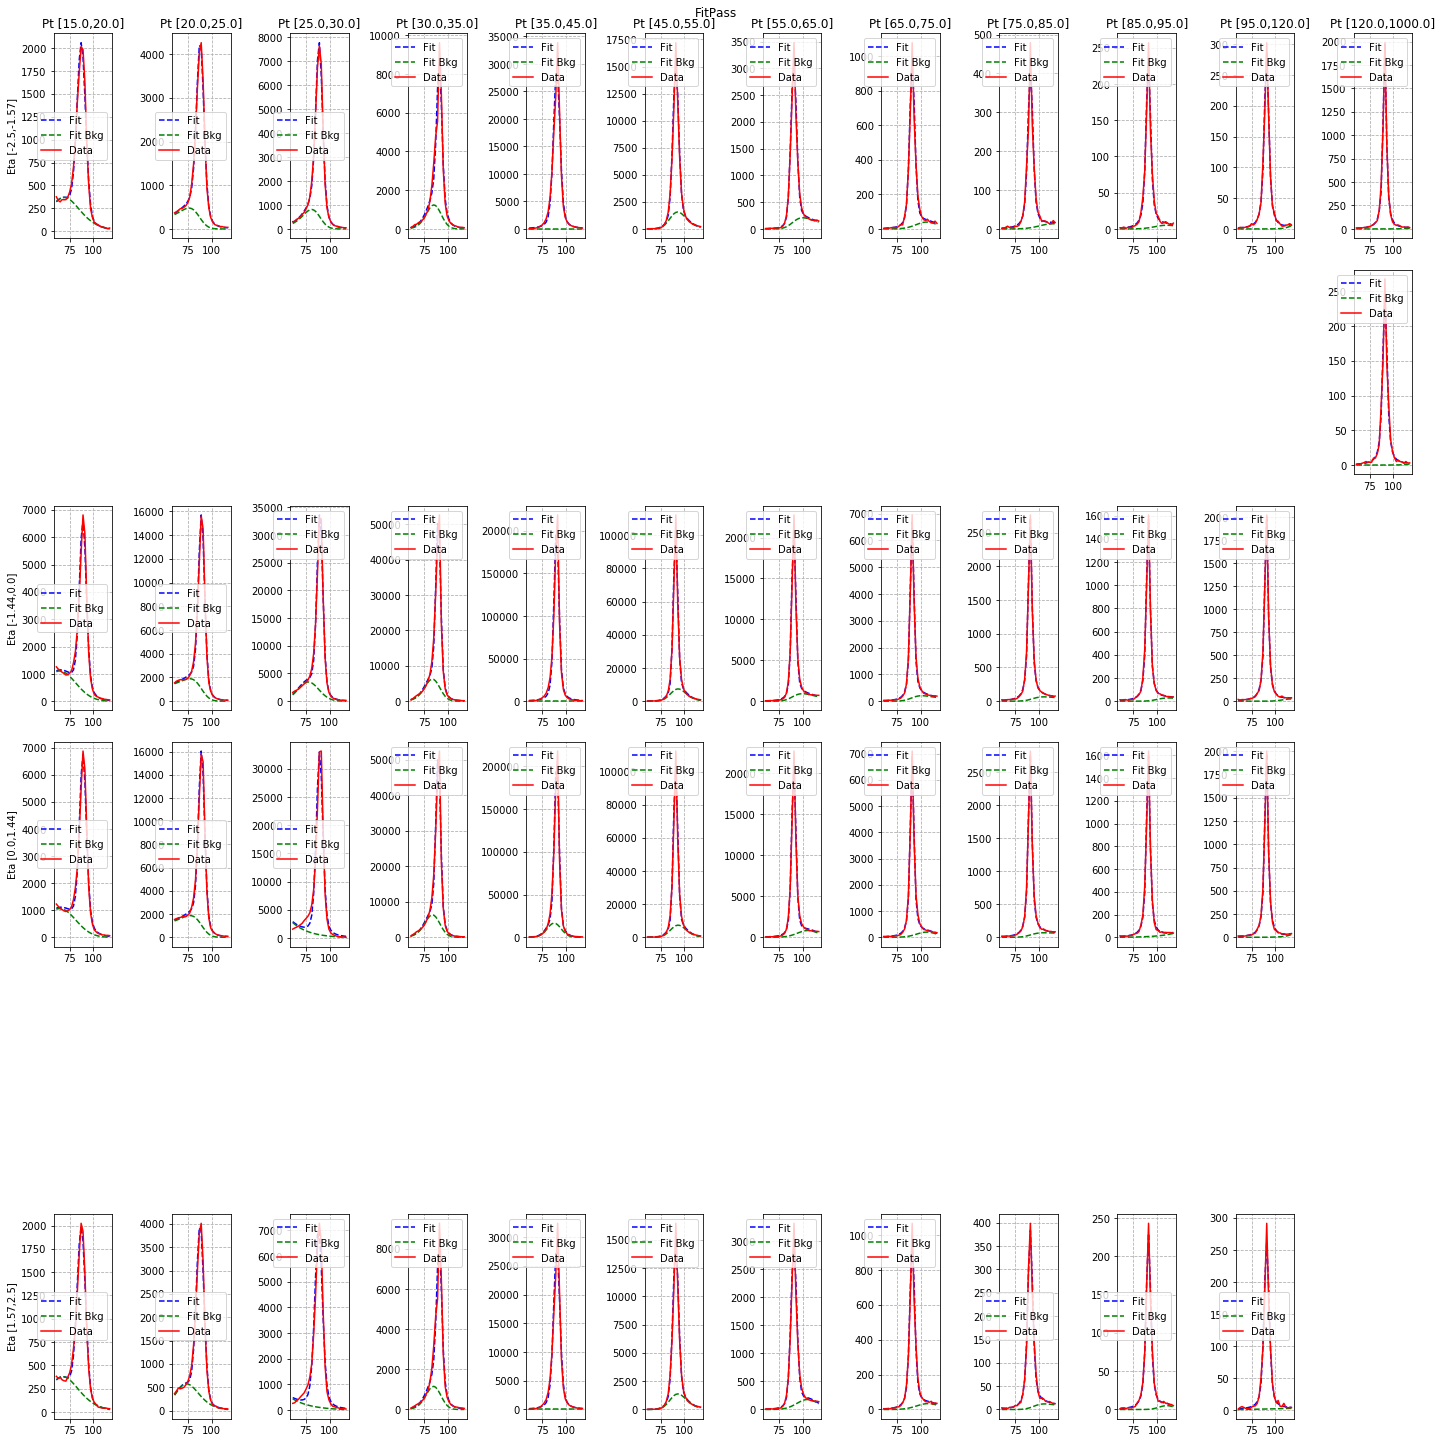

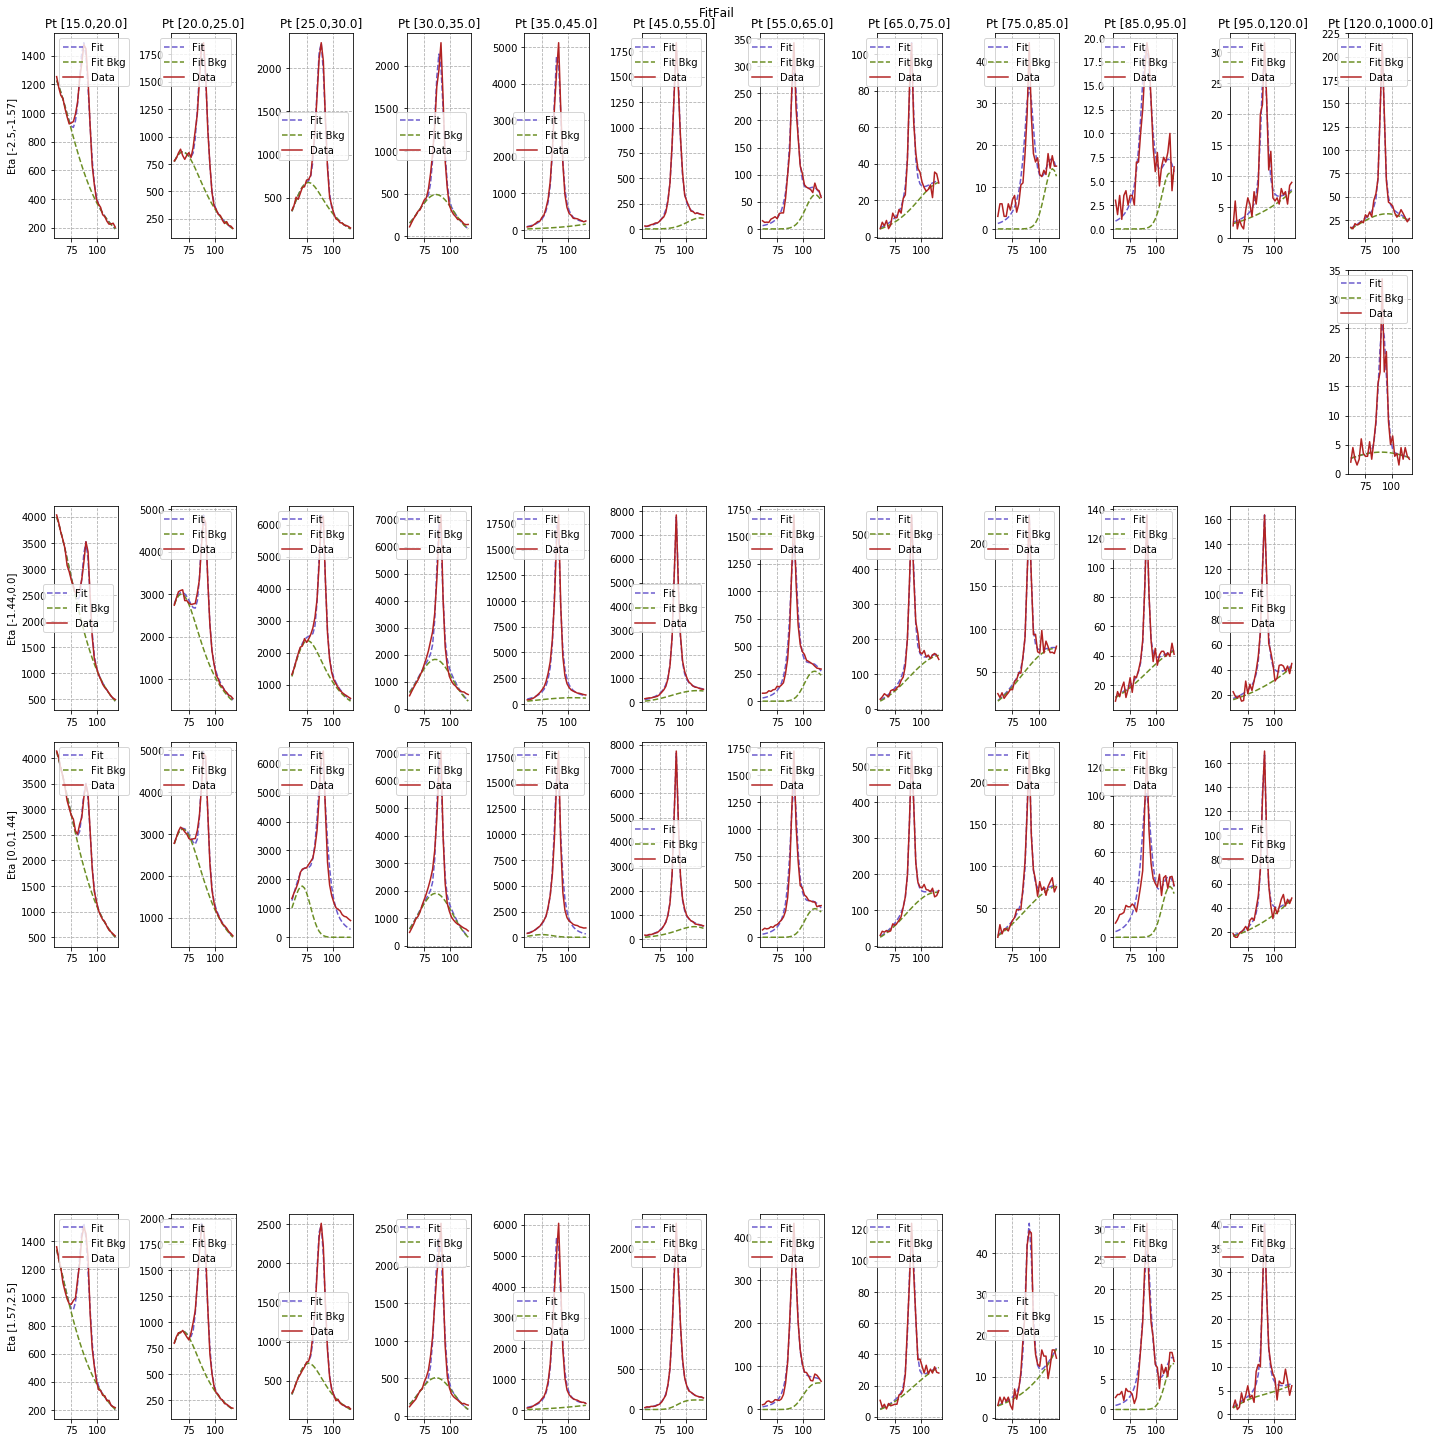

In [54]:
###################################

#FitType = 'Voigt_Exp'
#FitType = 'Voigt_CMS'
FitType = 'Voigt_Curve'

###################################      
    
etaBinsEBEE    = [[0,1.4442],[1.566,2.5]]
etaBins,ptBins = BinFormat(etaBins), BinFormat(ptBins)
etaNBin,ptNBin = len(etaBins),len(ptBins)

eff, effStat  = {}, {}

fit = []
fig  =  plt.figure(1,figsize=(20,20))
fig1 =  plt.figure(2,figsize=(20,20))

for j in np.arange(ptNBin):
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
    eff[j],effStat[j] = {},{}
    for i in np.arange(len(etaBINS)):
        
        #if j != 3 or i != 3:
        #    continue
            
            
        ij = ptNBin*i + (j+1)     
        IJ = i + (j*etaNBin)
        
        print(' Plotting i'+str(i)+' j'+str(j))
        

        
        if   FitType == 'MC_Exp':
            p0 = [
                    1e5,   1e3, 1e4,   1e3,
                    1, 0.2, 1,   0.2,
                    1, 0.2, 1,   0.2
                    ]

            Bounded = ((0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                       (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                       (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,      \
                                alphaPass, betaPass, peakPass, gammaPass,   \
                                alphaFail, betaFail, peakFail, gammaFail:   \
                                T(NSigPass, NBkgPass, NSigFail,NBkgFail,    \
                                  alphaPass, betaPass, peakPass, gammaPass, \
                                  alphaFail, betaFail, peakFail, gammaFail, \
                                  MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == 'Voigt_Exp':
            p0 = [
                    1e3,   1e5, 5e3,   1e5,
                    0.1, 0.1, 14,
                    0.03, 0,
                    0.1, 0.1, 14,
                    0.03, 0,
                    ]
            Bounded = (
                        (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                      )

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail,             \
                            sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                            sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                            TVoigt_Test(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                        sigPass, GammaPass, meanPass,          \
                                        lambdaPass, xPass,                     \
                                        sigFail, GammaFail, meanFail,          \
                                        lambdaFail, xFail,                     \
                                        MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == "Voigt_noSig":
            p0 = [
                    1e5,   1e5,
                    0.1, 0.1, 14,
                    0.03, 0,
                    0.1, 0.1, 14,
                    0.03, 0,
                    ]
            Bounded = (
                        (0,np.inf),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                        (0.01,4),(0.01,4),(0,40),
                        (-10,10),(0,np.inf),
                      )
            Temp = lambda   NBkgPass,NBkgFail,                                 \
                            sigPass, GammaPass, meanPass, lambdaPass, xPass,   \
                            sigFail, GammaFail, meanFail, lambdaFail, xFail:   \
                            TVoigt_noSig(NBkgPass,NBkgFail,                     \
                                        sigPass, GammaPass, meanPass,          \
                                        lambdaPass, xPass,                     \
                                        sigFail, GammaFail, meanFail,          \
                                        lambdaFail, xFail,                     \
                                        MCPass = MC_PASS_S, MCFail = MC_FAIL_S)    
        elif FitType == 'Voigt_CMS':   
            p0 = [
                    1e2,   2e2, 1e2,   4e2,
                    0.1, 2, 14,                 # Voigt
                    1,1, 0.01, 0.05, # RooCMS
                    0.1, 2, 43,                 # Voigt
                    1, 1, 0.01, 0.05, # RooCMS
                    ]

            Bounded = (
                        (0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),
                        (0.01,20),(0.01,20),(0,30),
                        (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                        (0.01,20),(0.01,20),(0,60),
                        (-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),
                      )

            Temp = lambda   NSigPass, NBkgPass, NSigFail,NBkgFail, \
                            sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                            sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail: \
                            TVoigt_CMS(NSigPass, NBkgPass, NSigFail,NBkgFail, \
                                       sigPass, GammaPass, meanPass, alphaPass, betaPass, peakPass, gammaPass, \
                                       sigFail, GammaFail, meanFail, alphaFail, betaFail, peakFail, gammaFail, \
                                       MCPass = MC_PASS_S, MCFail = MC_FAIL_S) 
        elif FitType == 'Voigt_x':
            p0 = [ 2.10010102e+04,  3.34421859e+03,  9.73858331e+03,  2.53360134e+04,
                    2.44107828e+00,  8.74878690e-01,  1.30304384e+01,  7.13139484e+00,
                   -1.30489487e+01,  1.99560639e+01,  4.61991664e-02,  2.34434414e+00,
                    9.74446121e-01,  4.20876696e+01,  3.00000000e+00,  3.00000000e+00,
                    1.97578463e+02,  7.12292034e-02]
            BoundedFit = [
                           [0,0,0,0,
                            0.01,0.01,0,
                            -np.inf,-np.inf,-np.inf,-np.inf,
                            0.01,0.01,30,
                            -np.inf,-np.inf,-np.inf,-np.inf],
                           [np.inf,np.inf,np.inf,np.inf,
                            5,5,30,
                            np.inf,np.inf,np.inf,np.inf,
                            5,5,60,
                            np.inf,np.inf,np.inf,np.inf,
                            ]
                          ]
        elif FitType == 'Voigt_Curve':
            if( SkipGap(i,j,binsSelected) ):
                eff[j][i] = 0
                effStat[j][i] = 0
                continue
    
            pPass,pFail, BoundedFit = InitializeParams(i,j,binsSelected)
            


                
        BoundedFit = [
                       [0,0,
                        0,0,10,
                        #-np.inf,-2,-np.inf,-2],
                        #0,-np.inf,-np.inf,-1],
                        0,-0.2,-np.inf,-1],
                       [np.inf,np.inf,
                        3,3,48,
                        #70,np.inf,np.inf,1,
                        70,0.2,np.inf,1,
                        ]
                    ]                

        ##################################################################

        ##################################################################
        print('--- Fitting')    
        #FitP, FitF,FitPSig, FitFSig = Fit_Curve(
        FitP, FitF,FitPSig, FitFSig,mP,mF = Fit_Curve_CHI(
                                                DATA_PASS = Data['Pass'][0][j][i],
                                                DATA_FAIL = Data['Fail'][0][j][i],
                                                pPass = pPass,pFail = pFail,
                                                Bounded = BoundedFit,
                                                )
        
        DATA = {"names" : mP.values.keys(),
                "values": mP.values.values(),
                "error" : mP.errors.values()
               }
        df = pd.DataFrame(DATA,columns=["names","values","error"])
        if isConv:
            df.to_csv(figpath+binsSelected+"/isConv/"+"FitValues_"+str(ptBins[j][0])+"_pt_"+str(ptBins[j][1])+"_"+str(etaBins[i][0])+"_eta_"+str(etaBins[i][1])+".csv")
        else:
            df.to_csv(figpath+binsSelected+"/ID/"+"FitValues_"+str(ptBins[j][0])+"_pt_"+str(ptBins[j][1])+"_"+str(etaBins[i][0])+"_eta_"+str(etaBins[i][1])+".csv")
            
        DATA = {"names" : mF.values.keys(),
                "values": mF.values.values(),
                "error" : mF.errors.values()
               }
        df = pd.DataFrame(DATA,columns=["names","values","error"])
        if isConv:
            df.to_csv(figpath+binsSelected+"/isConv/"+"FitValues_"+str(ptBins[j][0])+"_pt_"+str(ptBins[j][1])+"_"+str(etaBins[i][0])+"_eta_"+str(etaBins[i][1])+".csv")
        else:
            df.to_csv(figpath+binsSelected+"/ID/"+"FitValues_"+str(ptBins[j][0])+"_pt_"+str(ptBins[j][1])+"_"+str(etaBins[i][0])+"_eta_"+str(etaBins[i][1])+".csv")        
        ##################################################################
        
        ##################################################################
        PassFail = 'Pass'
        xs = np.arange(0,len(Data[PassFail][0][j][i]))

        if   FitType == 'MC_Exp':
            expParam = tuple(FIT[4:8])
            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = MC[PassFail]['DYJets'][0][j][i]/np.sum(MC[PassFail]['DYJets'][0][j][i])
            BKG = RooCMSShape(xc,*expParam)/np.sum(RooCMSShape(xc,*expParam))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_Exp':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:9]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = Exp  (xs, *argExp)  /np.sum(Exp  (xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_CMS':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:11]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_x':
            argVoigt = FIT[4:7]
            argExp   = FIT[7:11]

            NSig = FIT[0]
            NBkg = FIT[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))
            
            eff[j][i] = FIT[0]/(FIT[0]+FIT[2])
        elif FitType == 'Voigt_Curve':
            argVoigt = FitP[2:5]
            argExp   = FitP[5:9]

            NSig = FitP[0]
            NBkg = FitP[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))
            
            Num,dNum = FitP[0], FitPSig[0]
            Dem, dDem = (FitP[0]+FitF[0]), FitPSig[0]+FitFSig[0]
            
            eff[j][i] = Num/Dem
            effStat[j][i] = Num/Dem*np.sqrt((dNum/Num)**2 + (dDem/Dem)**2)
        
            print("Nsig: ",NSig)
            print("eff: ",eff[j][i]," | deff ",effStat[j][i])
                
        if np.isnan(eff[j][i]):
            eff[j][i] = 0.0
            
        plt.figure(1)
        ax = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['b','g','r']

        print('--- Plotting Pass')    
        PlotFitting(
                    ax,
                    NSig = NSig, NBkg = NBkg,
                    DATA = Data[PassFail][0][j][i],
                    SIG  = SIG,
                    BKG  = BKG,
                    eta  = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        '''
        ax.text(60,max(SIG)*0.5,
                 'NSig = '+str(round(NSig))+' +/- '+str(FitPSig[0]),
                 fontsize = 2)
        ax.text(60,max(SIG)*0.5,
                 'NBkg = '+str(round(NBkg))+' +/- '+str(FitPSig[1]),
                 fontsize = 2)
        '''
        
        
        ####################################################################################
        PassFail = 'Fail'
        xs = np.arange(len(Data[PassFail][0][j][i]),len(Data[PassFail][0][j][i])*2)

        if   FitType == 'MC_Exp':
            expParam = tuple(FIT[8:12])

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = MC[PassFail]['DYJets'][0][j][i]/np.sum(MC[PassFail]['DYJets'][0][j][i])
            BKG = RooCMSShape(xc,*expParam)/np.sum(RooCMSShape(xc,*expParam))   
        elif FitType == 'Voigt_Exp':
            argVoigt = FIT[9:12]
            argExp   = FIT[12:14]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = Exp  (xs, *argExp)  /np.sum(Exp  (xs, *argExp))
        elif FitType == 'Voigt_CMS':
            argVoigt = FIT[11:14]
            argExp   = FIT[14:18]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)/np.sum(RooCMSShape(xs, *argExp))   
        elif FitType == 'Voigt_x':
            argVoigt = FIT[11:14]
            argExp   = FIT[14:18]

            NSig = FIT[2]
            NBkg = FIT[3]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)/np.sum(RooCMSShape(xs, *argExp))  
        elif FitType == 'Voigt_Curve':
            argVoigt = FitF[2:5]
            argExp   = FitF[5:9]

            NSig = FitF[0]
            NBkg = FitF[1]

            SIG = Voigt(xs, *argVoigt)/np.sum(Voigt(xs, *argVoigt))
            BKG = RooCMSShape(xs, *argExp)  /np.sum(RooCMSShape(xs, *argExp))

        print('--- Plotting Fail')    
        plt.figure(2)
        ax1 = plt.subplot(len(etaBins),len(ptBins),ij)
        color = ['slateblue','olivedrab','firebrick']

        PlotFitting(
                    ax1,
                    NSig = NSig, NBkg = NBkg,
                    DATA = Data[PassFail][0][j][i],
                    SIG  = SIG,
                    BKG  = BKG,
                    eta  = etaBINS[i], pt = ptBins[j],
                    color = color,
                   )
        '''
        ax.text(60,max(SIG)*0.5,
                 'NSig = '+str(round(NSig))+' +/- '+str(FitFSig[0]),
                 fontsize = 2)
        ax.text(60,max(SIG)*0.5,
                 'NBkg = '+str(round(NBkg))+' +/- '+str(FitFSig[1]),
                 fontsize = 2)
        '''
        ####################################################################################
        print("\n")
        
fig.tight_layout()        
fig1.tight_layout()        

     
fig.suptitle("FitPass",y=1)
fig1.suptitle("FitFail",y=1) 

if isConv:
    fig .savefig(figpath+binsSelected+"/isConv/"+"FitPass.png")        
    fig1.savefig(figpath+binsSelected+"/isConv/"+"FitFail.png")     
else:
    fig .savefig(figpath+binsSelected+"/ID/"+"FitPass_Exp.png")        
    fig1.savefig(figpath+binsSelected+"/ID/"+"FitFail_Exp.png")     
plt.show()

In [55]:
path = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/python/Efficiency/zee/"
if isConv:
    fileOut = TFile(figpath+binsSelected+"/isConv/"+"eff_photon_data.root","recreate")
else:
    fileOut = TFile(figpath+binsSelected+"/ID/"+"eff_photon_data_VoigtCMS.root","recreate")
tree = TTree("eff_photon","eff_photon")

##################################################
ptBins, etaBins = BinFormat(ptBins,Type = 'edges'),BinFormat(etaBins,Type = 'edges')

ptNBins, etaNBins = len(ptBins)-3 , len(etaBins)-1
histDraw = TH2F("EGamma_eff_draw","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins, etaNBins = len(ptBins)-1 , len(etaBins)-1
hist2d = TH2F("EGamma_eff","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins, etaNBins = len(ptBins)-2 , len(etaBins)-1
statDraw = TH2F("EGamma_eff_stat_draw","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins, etaNBins = len(ptBins)-1 , len(etaBins)-1
stat2d = TH2F("EGamma_eff_stat","Eff",
              ptNBins ,ptBins,
              etaNBins,etaBins)

etaBins = BinFormat(etaBins)
##################################################
tree.Branch("eff",hist2d,"TH2F")
tree.Branch("eff",hist2d,"TH2F")
for j in range(ptNBins):
    hist2d.GetZaxis().SetRangeUser(0.6,1.1)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            hist2d.SetBinContent(int(j)+1, int(i)+1, eff[j][i])
            histDraw.SetBinContent(int(j)+1, int(i)+1, eff[j][i])
            
            stat2d.SetBinContent(int(j)+1, int(i)+1, effStat[j][i])
            statDraw.SetBinContent(int(j)+1, int(i)+1, effStat[j][i])
            tree.Fill()
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                EFF = eff[j][0]
                EFFStat =  effStat[j][0]
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                EFF = eff[j][1]
                EFFStat =  effStat[j][1]
                I = 2
            else:
                EFF = 0
                EFFStat =  0
            hist2d.SetBinContent(int(j)+1, int(i)+1, EFF)
            histDraw.SetBinContent(int(j)+1, int(i)+1, EFF)
            
            stat2d.SetBinContent(int(j)+1, int(i)+1, EFFStat)
            statDraw.SetBinContent(int(j)+1, int(i)+1, EFFStat)
            tree.Fill()
    
    
fileOut.Write()
#fileOut.Close()

2729

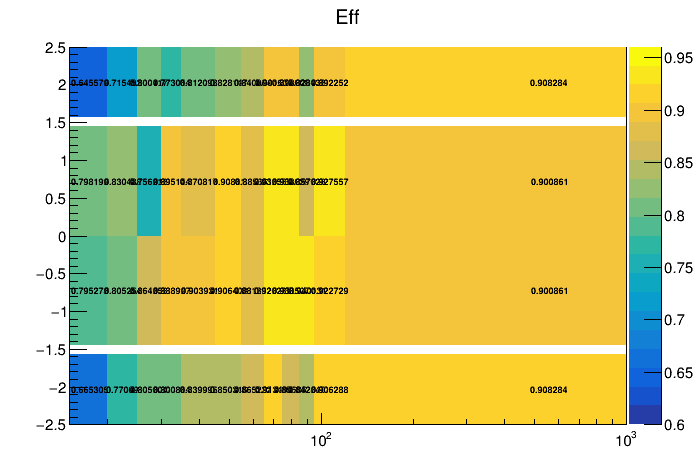

In [56]:
c = TCanvas()
if isConv:
    hist2d.GetZaxis().SetRangeUser(0.85,0.94)
else:
    hist2d.GetZaxis().SetRangeUser(0.6,0.96)
hist2d.Draw("colz text")
c.SetLogx()
c.Draw()

Info in <TCanvas::Print>: png file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_data_photonID.png has been created


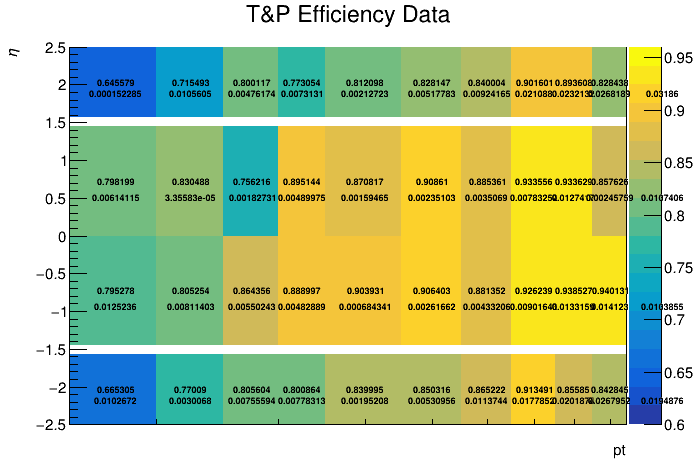

In [57]:
c = TCanvas()
histDraw.SetTitle("T&P Efficiency Data")
if isConv:
    histDraw.GetZaxis().SetRangeUser(0.85,0.94)
else:
    histDraw.GetZaxis().SetRangeUser(0.6,0.96)
histDraw.GetXaxis().SetTitle('pt')
histDraw.GetYaxis().SetTitle(r'\eta')
histDraw.Draw("colz text")

#gStyle.SetPaintTextFormat("4.3f +/-")
statDraw.SetBarOffset(-0.15)
statDraw.Draw("text same")
c.SetLogx()
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"EFF_data_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"EFF_data_photonID.png")
c.Draw()

Info in <TCanvas::Print>: png file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/EFF_UNC_data_photonID.png has been created


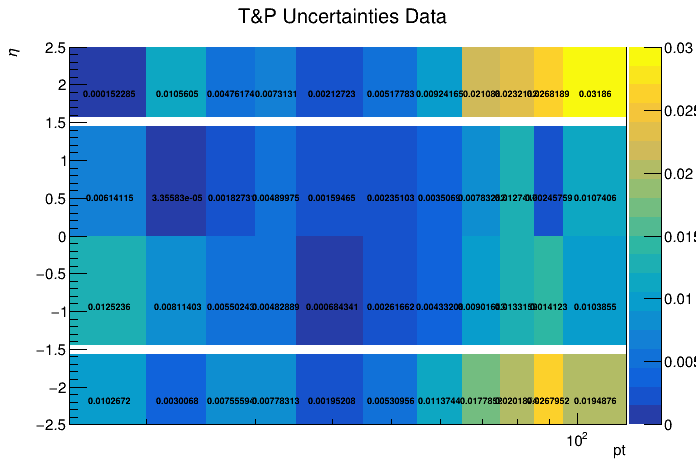

In [58]:
c = TCanvas()
statDraw.SetTitle("T&P Uncertainties Data")
#statDraw.GetZaxis().SetRangeUser(0,0.4)
if isConv:
    statDraw.GetZaxis().SetRangeUser(0,0.023)
else:
    statDraw.GetZaxis().SetRangeUser(0,0.03)
statDraw.GetXaxis().SetTitle('pt')
statDraw.GetYaxis().SetTitle(r'\eta')
statDraw.Draw("colz text")
c.SetLogx()
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"EFF_UNC_data_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"EFF_UNC_data_photonID.png")
c.Draw()

In [59]:
fileOut.Close()

In [60]:
if isConv:
    fileOut = TFile(figpath+binsSelected+"/isConv/"+"sf_photon.root","recreate")
else:
    fileOut = TFile(figpath+binsSelected+"/ID/"+"sf_photon.root","recreate")
tree = TTree("sf_photon","sf_photon")

################################################
ptBins, etaBins = BinFormat(ptBins,Type='edges'),BinFormat(etaBins,Type='edges')

ptNBins,etaNBins = len(ptBins)-2, len(etaBins)-1
histDraw = TH2F("EGamma_sf_draw","SF",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1
hist2d = TH2F("EGamma_sf","SF",
              ptNBins ,ptBins,
              etaNBins,etaBins)

ptNBins,etaNBins = len(ptBins)-2, len(etaBins)-1
statDraw = TH2F("EGamma_sf_stat_draw","SF",
              ptNBins ,ptBins,
              etaNBins,etaBins)


ptNBins,etaNBins = len(ptBins)-1, len(etaBins)-1
stat2d = TH2F("EGamma_sf_stat","SF",
              ptNBins ,ptBins,
              etaNBins,etaBins)


etaBins = BinFormat(etaBins)
################################################

tree.Branch("sf",hist2d,"TH2F")

for j in range(ptNBins):
    #hist2d.GetXaxis().SetRangeUser(0,200)
    hist2d.GetZaxis().SetRangeUser(0.6,1.2)
    if j in BinEBEE:
        etaBINS = etaBinsEBEE
    else:
        etaBINS = etaBins
        
    if len(etaBINS) > 2:
        for i in np.arange(len(etaBINS)):
            
            if effMC[j][i] == 0:
                SF = 0
                SFStat = 0
            else:
                SF = eff[j][i]/effMC[j][i]
                SFStat = SF*np.sqrt((effStat[j][i]/eff[j][i])**2 + (effMCStat[j][i]/effMC[j][i])**2)
            
            hist2d  .SetBinContent(int(j)+1, int(i)+1, SF)
            histDraw.SetBinContent(int(j)+1, int(i)+1, SF)
            
            stat2d  .SetBinContent(int(j)+1, int(i)+1, SFStat)
            statDraw.SetBinContent(int(j)+1, int(i)+1, SFStat)
            tree.Fill()
            #print(j,i,SF)
    else:
        for i in range(len(etaBins)):
            if np.abs(np.average(etaBins[i])) > 1.566:
                SF = eff[j][0]/effMC[j][0]
                SFStat = SF*np.sqrt((effStat[j][0]/eff[j][0])**2 + (effMCStat[j][0]/effMC[j][0])**2)
            elif np.abs(np.average(etaBins[i])) < 1.4442:
                SF = eff[j][1]/effMC[j][1]
                SFStat = SF*np.sqrt((effStat[j][1]/eff[j][1])**2 + (effMCStat[j][1]/effMC[j][1])**2)
                I = 2
            else:
                SF = 0
                SFStat = 0

            hist2d  .SetBinContent(int(j)+1, int(i)+1, SF)
            histDraw.SetBinContent(int(j)+1, int(i)+1, SF)
            
            
            stat2d  .SetBinContent(int(j)+1, int(i)+1, SFStat)
            statDraw.SetBinContent(int(j)+1, int(i)+1, SFStat)
            
            tree.Fill()
            #print(j,i,SF)
hist2d.GetZaxis().SetRangeUser(0.95,1.17)
hist2d.GetXaxis().SetTitle("pt")
hist2d.GetYaxis().SetTitle(r"\eta")

fileOut.Write()
#

2704

Info in <TCanvas::Print>: png file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/SF_photonID.png has been created


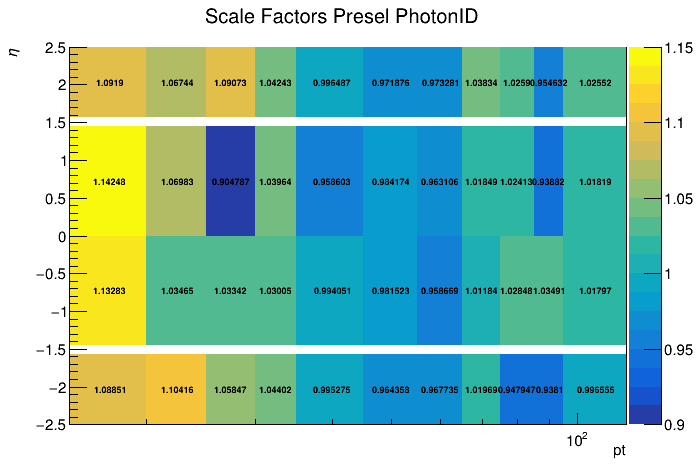

In [61]:
c = TCanvas()
histDraw.SetTitle("Scale Factors Presel PhotonID")
#histDraw.GetZaxis().SetRangeUser(0.9,1.15)
if isConv:
    histDraw.GetZaxis().SetRangeUser(0.91,1)
else:
    histDraw.GetZaxis().SetRangeUser(0.9,1.15)
histDraw.GetXaxis().SetTitle('pt')
histDraw.GetYaxis().SetTitle(r'\eta')
histDraw.Draw("colz text")
c.SetLogx()
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"SF_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"SF_photonID.png")
c.Draw()

Info in <TCanvas::Print>: png file /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/ee/Eff_SF_csv/Plots/ID/SF_UNC_photonID.png has been created


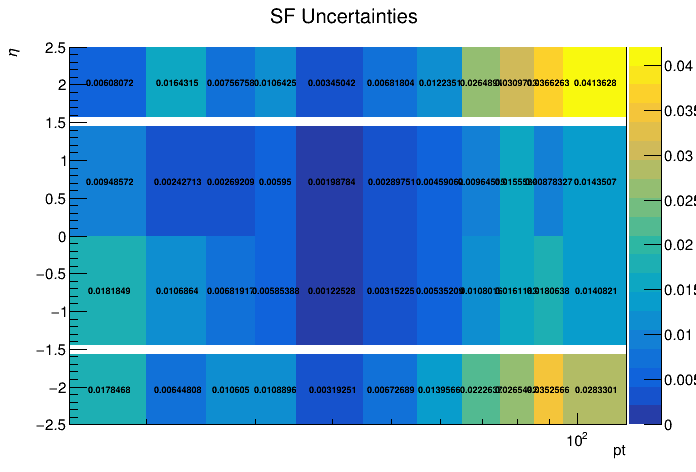

In [62]:
c = TCanvas()
statDraw.SetTitle("SF Uncertainties")
#statDraw.GetZaxis().SetRangeUser(0,0.03)
if isConv:
    statDraw.GetZaxis().SetRangeUser(0,0.052)
else:
    statDraw.GetZaxis().SetRangeUser(0,0.042)
statDraw.GetXaxis().SetTitle('pt')
statDraw.GetYaxis().SetTitle(r'\eta')
statDraw.Draw("colz text")
c.SetLogx()
if isConv:
    c.SaveAs(figpath+binsSelected+"/isConv/"+"SF_UNC_photonID.png")
else:
    c.SaveAs(figpath+binsSelected+"/ID/"+"SF_UNC_photonID.png")
c.Draw()

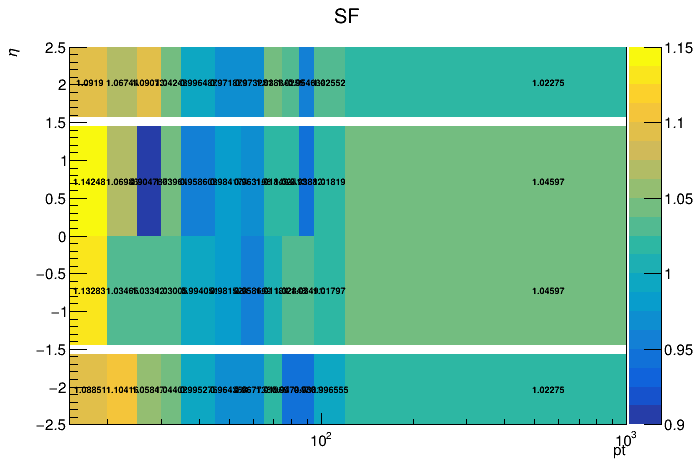

In [63]:
c = TCanvas()
if isConv:
    hist2d.GetZaxis().SetRangeUser(0.9,1.0)
else:
    hist2d.GetZaxis().SetRangeUser(0.9,1.15)
hist2d.Draw("colz text")
c.SetLogx()
c.Draw()

In [64]:
fileOut.Close()

# -------------------------------------------------------

# Projections

In [65]:
ptBins, etaBins =  BinFormat(ptBins), BinFormat(etaBins)

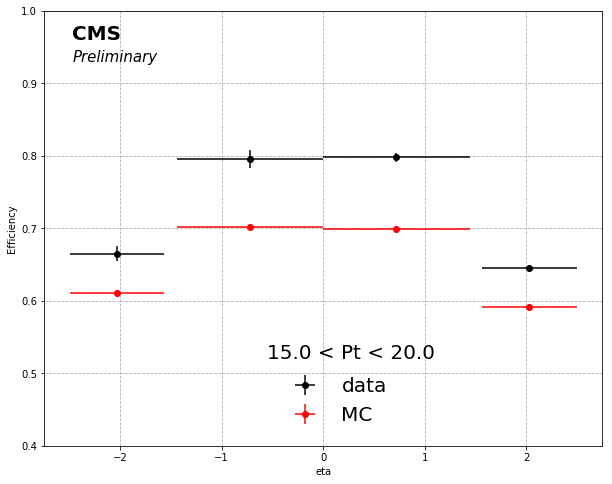

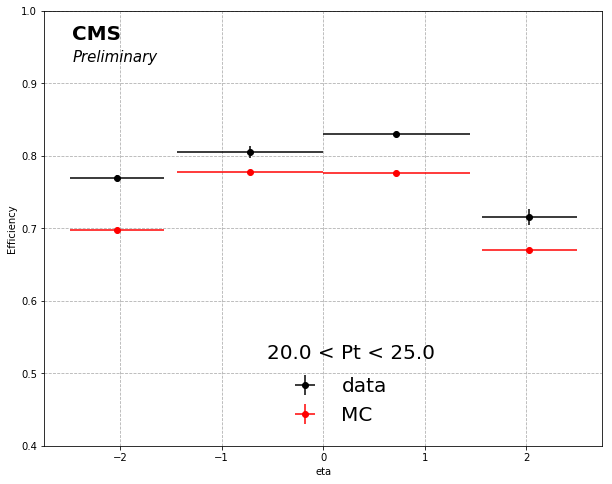

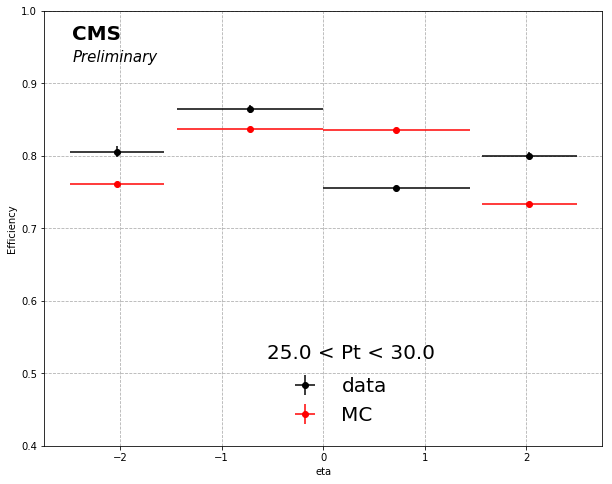

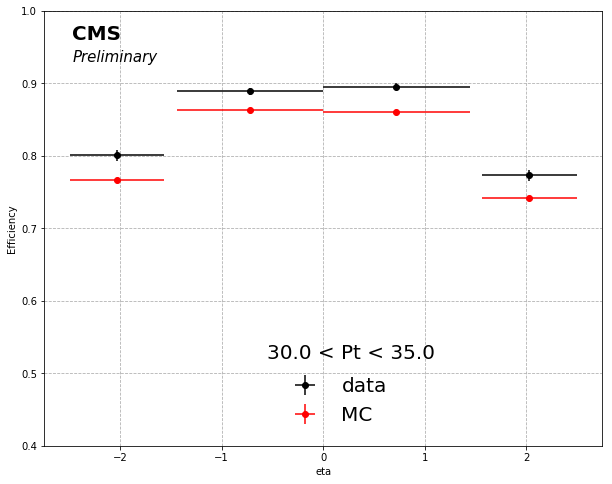

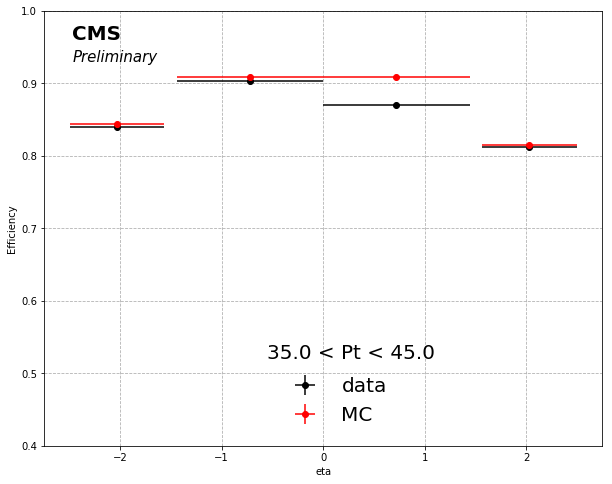

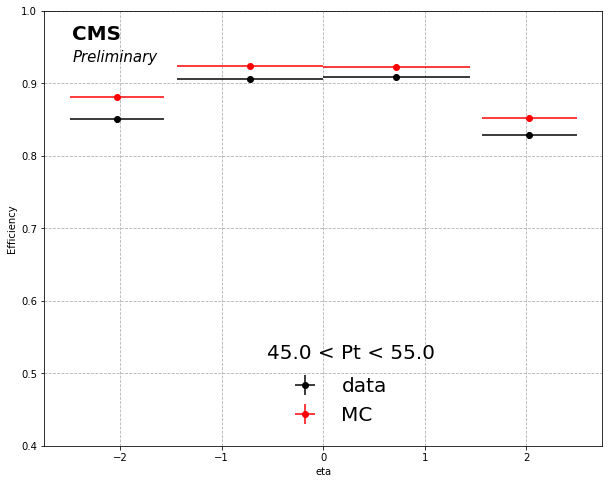

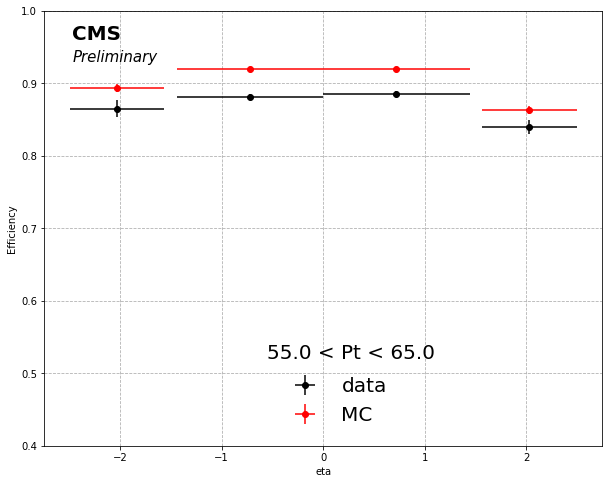

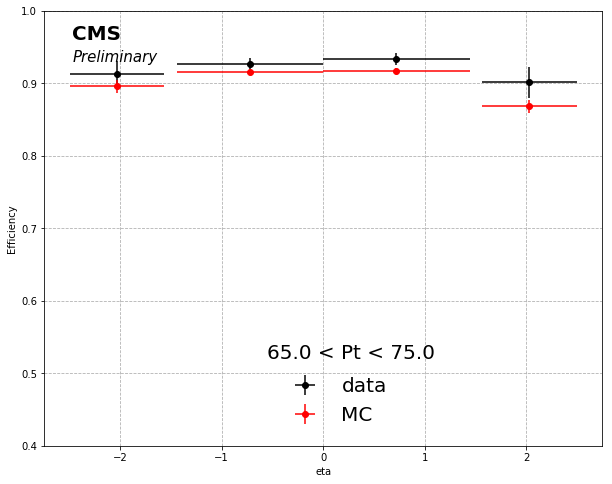

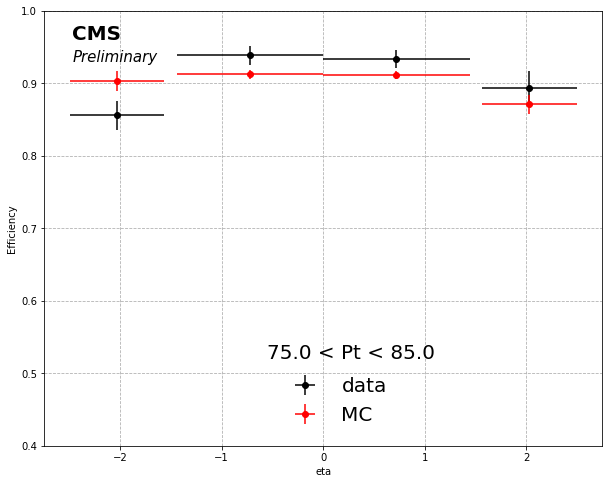

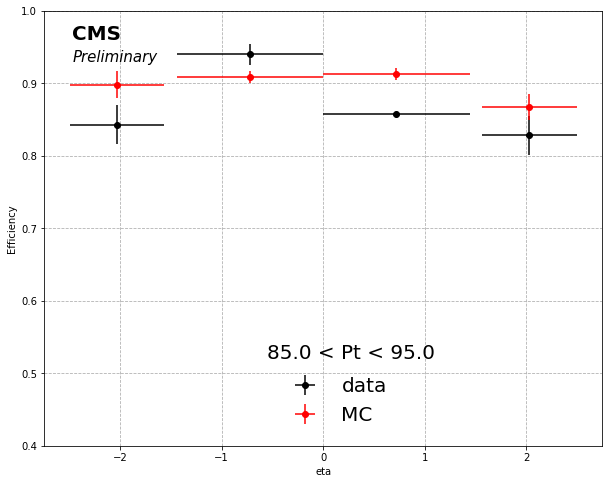

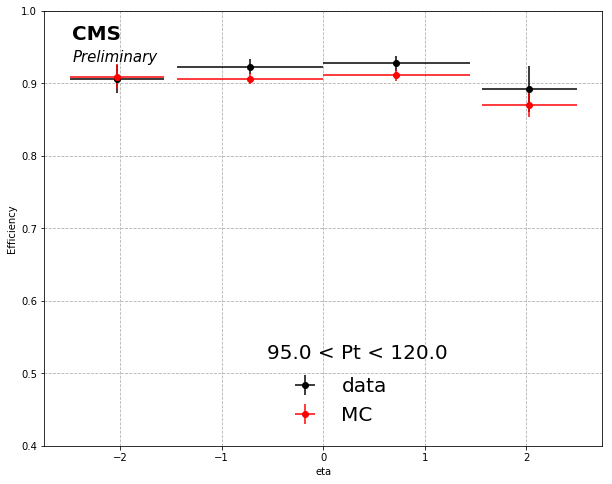

In [66]:
projVar  = etaBins
otherVar = ptBins
for j in np.arange(len(otherVar)-1):
    fig = plt.figure(figsize=(10,8))
    ###############  Data #######################
    Proj = [eff[j][i]      for i in np.arange(len(projVar))]
    yErr = [effStat[j][i]  for i in np.arange(len(projVar))]
    xErr = np.diff(projVar[:len(Proj)])/2
    Bins = np.array(BinFormat(Bins=projVar[:len(Proj)],Type='edges'))
    Bins = (Bins[:-1]+Bins[1:])/2

    plt.errorbar(Bins,Proj,
                 xerr      = xErr,
                 yerr      = yErr,
                 linestyle = '',
                 marker    = 'o',
                 color     = 'black',
                 label     = 'data',
                )

    ###############  MC #######################
    Proj = [effMC[j][i]      for i in np.arange(len(projVar))]
    yErr = [effMCStat[j][i]  for i in np.arange(len(projVar))]
    xErr = np.diff(projVar[:len(Proj)])/2
    Bins = np.array(BinFormat(Bins=projVar[:len(Proj)],Type='edges'))
    Bins = (Bins[:-1]+Bins[1:])/2
    
    plt.errorbar(Bins,Proj,
                 xerr      = xErr,
                 yerr      = yErr,
                 linestyle = '',
                 marker    = 'o',
                 color     = 'red',
                 label     = 'MC',
                )
    ##################
    ax = plt.gca()
    xlim  = ax.get_xlim()
    ylim  = ax.get_ylim()
    ax.set_ylabel('Efficiency')
    ax.set_xlabel('eta')
    #ax.set_xlabel('pt')
    ax.set_ylim([0.4,1])

    xText = 0.4*(xlim[1]-xlim[0])+xlim[0]
    yText = 0.52

    #Text = str(round(etaBins[i][0],2))+' < '+r'$\eta$'+' < '+ str(round(etaBins[i][1],2))
    Text = str(round(ptBins[j][0],2))+' < Pt < '+ str(round(ptBins[j][1],2))

    ax.text(xText, yText,
           Text,
            fontsize = 20
           )

    xText, yText = 0.05*(xlim[1]-xlim[0])+xlim[0],0.96
    Text = 'CMS'
    ax.text(xText, yText,Text,fontsize = 20,weight='bold')
    xText, yText = 0.05*(xlim[1]-xlim[0])+xlim[0],0.93
    Text = 'Preliminary'
    ax.text(xText, yText,Text,fontsize = 15,fontstyle='italic')

    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor = (0.4,0.2),
                #loc=[xText,yText+0.1],
               fontsize = 20,
               frameon = False)

    #fig.savefig(figpath+"eff_projPt_eta"+str(round(otherVar[i][0],2))+"_"+str(round(otherVar[i][1],2))+".png")
    if isConv:
        fig.savefig(figpath+binsSelected+"/isConv/"+"eff_projEta_pt"+str(round(otherVar[j][0],2))+"_"+str(round(otherVar[j][1],2))+".png")
    else:
        fig.savefig(figpath+binsSelected+"/ID/"+"eff_projEta_pt"+str(round(otherVar[j][0],2))+"_"+str(round(otherVar[j][1],2))+".png")
    plt.show()



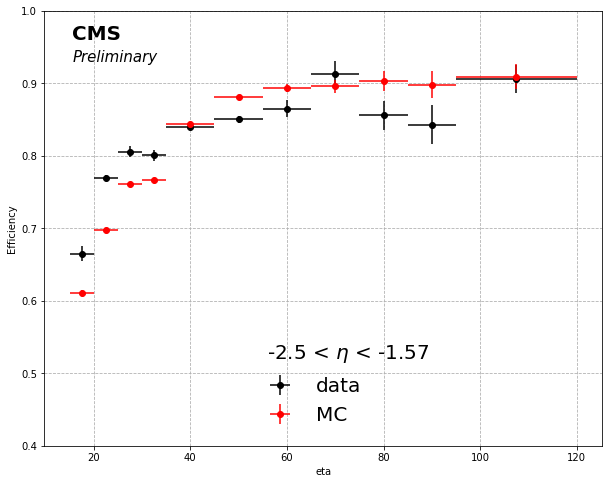

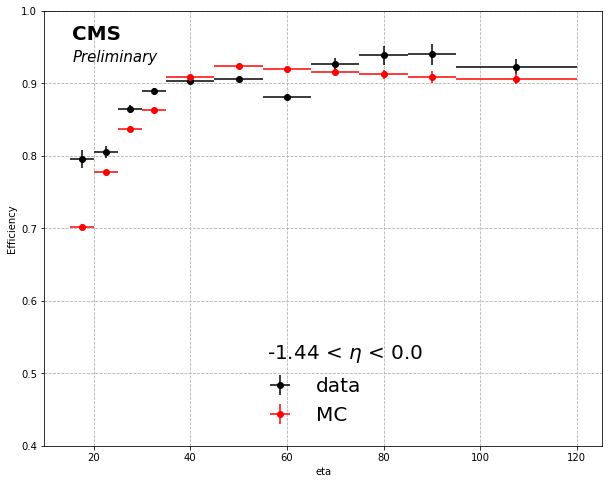

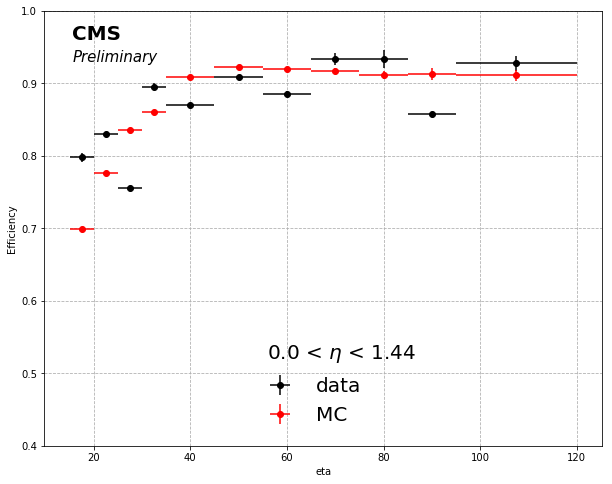

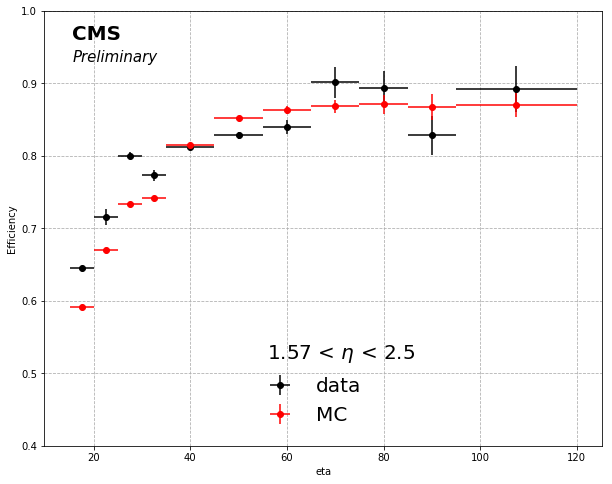

In [67]:
projVar  = ptBins
otherVar = etaBins
lastBins = False
if lastBins:
    N = 0
else:
    N = 1

for i in np.arange(len(otherVar)):
    if i == 1 or i == 4: continue
    fig = plt.figure(figsize=(10,8))
    ###############  Data #######################
    Proj = [eff[j][i]      for j in np.arange(len(projVar)-N)]
    yErr = [effStat[j][i]  for j in np.arange(len(projVar)-N)]
    xErr = np.diff(projVar[:len(Proj)])/2
    Bins = np.array(BinFormat(Bins = projVar[:len(Proj)],Type = 'edges'))
    Bins = (Bins[:-1]+Bins[1:])/2
    
    plt.errorbar(Bins,Proj,
                 xerr = xErr,
                 yerr = yErr,
                 linestyle = '',
                 marker = 'o',
                 color = 'black',
                 label = 'data',
                )

    ###############  MC #######################
    Proj = [effMC[j][i]      for j in np.arange(len(projVar)-N)]
    yErr = [effMCStat[j][i]  for j in np.arange(len(projVar)-N)]
    xErr = np.diff(projVar[:len(Proj)])/2
    Bins = np.array(BinFormat(Bins=projVar[:len(Proj)],Type = 'edges'))
    Bins = (Bins[:-1]+Bins[1:])/2
    plt.errorbar(Bins,Proj,
                 xerr = xErr,
                 yerr = yErr,
                 linestyle = '',
                 marker = 'o',
                 color = 'red',
                 label = 'MC',
                )
    ##################
    ax = plt.gca()
    xlim  = ax.get_xlim()
    ylim  = ax.get_ylim()
    ax.set_ylabel('Efficiency')
    ax.set_xlabel('eta')
    #ax.set_xlabel('pt')
    ax.set_ylim([0.4,1])

    xText = 0.4*(xlim[1]-xlim[0])+xlim[0]
    yText = 0.52

    Text = str(round(etaBins[i][0],2))+' < '+r'$\eta$'+' < '+ str(round(etaBins[i][1],2))
    #Text = str(round(ptBins[j][0],2))+' < Pt < '+ str(round(ptBins[j][1],2))

    ax.text(xText, yText,
           Text,
            fontsize = 20
           )

    xText, yText = 0.05*(xlim[1]-xlim[0])+xlim[0],0.96
    Text = 'CMS'
    ax.text(xText, yText,Text,fontsize = 20,weight='bold')
    xText, yText = 0.05*(xlim[1]-xlim[0])+xlim[0],0.93
    Text = 'Preliminary'
    ax.text(xText, yText,Text,fontsize = 15,fontstyle='italic')

    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor = (0.6,0.2),
                #loc=[xText,yText+0.1],
               fontsize = 20,
               frameon = False)

    if isConv:
        fig.savefig(figpath+binsSelected+"/isConv/"+"eff_projPt_eta"+str(round(otherVar[i][0],2))+"_"+str(round(otherVar[i][1],2))+".png")
    else:
        fig.savefig(figpath+binsSelected+"/ID/"+"eff_projPt_eta"+str(round(otherVar[i][0],2))+"_"+str(round(otherVar[i][1],2))+".png")
    #fig.savefig(figpath+"eff_projEta_pt"+str(round(otherVar[j][0],2))+"_"+str(round(otherVar[j][1],2))+".png")
    plt.show()


In [68]:
def Voigt_CMS_x(
                xc,
                NSigPass, NBkgPass, NSigFail,NBkgFail, 
                sigPass, GammaPass, meanPass,
                alphaPass, betaPass, peakPass, gammaPass,
                sigFail, GammaFail, meanFail,
                alphaFail, betaFail, peakFail, gammaFail,
                MCPass, MCFail
                ):
    #x = np.arange(0,len(MCPass))
    x = xc[:len(MCPass)]
    argPass      = alphaPass, betaPass, peakPass, gammaPass
    argVoigtPass = sigPass, GammaPass, meanPass
    Pass = list(Template(NSigPass, NBkgPass, 
                         Voigt(x,*argVoigtPass)  , RooCMSShape(x,*argPass))) 
    
    
    #x = np.arange(len(MCPass),len(MCPass)*2)
    x = xc[len(MCPass):len(MCPass)*2]
    argFail      = alphaFail, betaFail, peakFail, gammaFail
    argVoigtFail = sigFail, GammaFail, meanFail
    Fail = list(Template(NSigFail, NBkgFail, 
                         Voigt(x,*argVoigtFail) , RooCMSShape(x,*argFail)))
    
    
    Temp = np.array(Pass + Fail )
    return Temp


In [69]:
def Voigt_CMS(
                xc,
                NSig, NBkg, 
                sig, Gamma, mean,
                alpha, beta, peak, gamma,
                ):
    x = xc
    arg      = alpha, beta, peak, gamma
    argVoigt = sig, Gamma, mean
    Temp = list(Template(NSig, NBkg, 
                         Voigt(x,*argVoigt) , RooCMSShape(x,*arg)))
    
    
    return np.array(Temp)


In [70]:
PassYield = {}
FailYield = {}
FitPass = {}
FitFail = {}

In [164]:
def chiplot(plot,data):
    return np.sum(((plot-data)**2)/data)

32721.280344941137

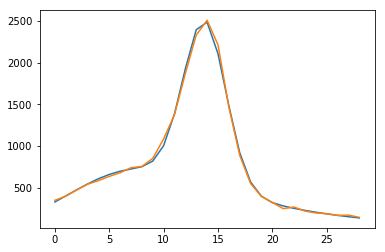

In [165]:
plt.plot(VoigtCMS(xFit,*FitsFail))
plt.plot(DATA_FAIL)

np.sum((VoigtCMS(xFit,*FitsFail)-DATA_FAIL)**2)
#plt.plot(xFit,Mass)

In [169]:
def TextLegend(FitPrams,fit,sig,massFit,mass,chi):
    massFit = np.array(massFit)
    mass = np.array(mass)
    
    i , j = len(mass)-2, 0
    m = (mass[i]-mass[j])/(massFit[i]-massFit[j])
    b = massFit[i]-massFit[j]*m
    
    ndf = len(mass) - len(FitPrams)
    text = 'Chi/ndf: '+str(round(chi/ndf,2)) + '\n'
    for i in np.arange(len(FitPrams)):
        val= fit[i]
        err = sig[i]
        
        if 'mean' in FitPrams[i]:
            val = m*val+b #+ mass[0]
            err = m*err+b
        
        val = str(round(val,2))
        err = str(round(err,2))
        
        text +=  FitPrams[i] + ': ' + val +' +/- '+ err +'\n'
    return text

In [170]:
binsSelected = "Optimized"

---------------------- i: 0 j: 2 -------------------------
[150000.0, 50000.0, 1, 1, 44, 20, 0.1, 20, 0.09] [ 4525.16761924  4288.31421001  4057.53570089  3841.04773104
  3647.2553886   3485.69311358  3368.75790696  3315.02570131
  3356.11987428  3552.53948629  4035.42813737  5136.82853692
  7844.04408261 14826.43846376 28009.10206442 36481.11559897
 27785.91186384 14378.4154217   7167.9271157   4227.79142728
  2887.17170763  2157.43702688  1705.43429171  1399.21985061
  1177.92069817  1010.10228379   878.09229389   771.26927411
   682.89312841]
--- Fitting
[35430.77702505472, 10495.57727788297, 1.6991364431919327, 0.6985877662533826, 13.97731951058216, 13.034681044218832, -0.29999999999100485, 9.999999999996044, -0.1518722863233578]  |  [367.2955487500185, 358.7162624497905, 0.01644983282232948, 0.011242169899810472, 0.008516055630192199, 0.1892426860890577, 0.0010343427731963617, 63884699.00901606, 0.0032456918863443263]
[8737.8256577392, 12510.870686261807, 2.3089769811459666, 3.524

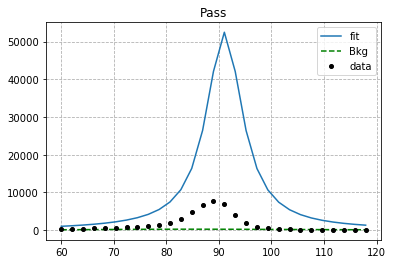

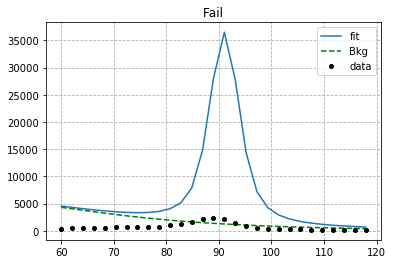

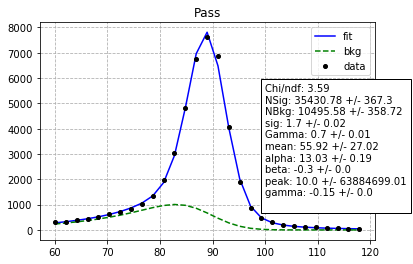

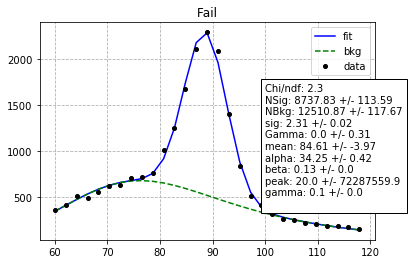

---------------------- i: 1 j: 2 -------------------------
---------------------- i: 2 j: 2 -------------------------
[150000.0, 50000.0, 1, 1, 44, 20, 0.1, 20, 0.09] [ 4525.16761924  4288.31421001  4057.53570089  3841.04773104
  3647.2553886   3485.69311358  3368.75790696  3315.02570131
  3356.11987428  3552.53948629  4035.42813737  5136.82853692
  7844.04408261 14826.43846376 28009.10206442 36481.11559897
 27785.91186384 14378.4154217   7167.9271157   4227.79142728
  2887.17170763  2157.43702688  1705.43429171  1399.21985061
  1177.92069817  1010.10228379   878.09229389   771.26927411
   682.89312841]
--- Fitting
[134254.14917411905, 45228.58430296522, 1.6040595406333762, 0.40014907601366245, 14.273824896131305, 33.34465710482404, 0.1310127317155355, 10.000000000414953, 0.899999178383735]  |  [402.2183764590445, 377.63261674406385, 0.00575049029916852, 0.007563440161627799, 0.0029091898818052186, 0.2909193334255953, 0.0006590861853820185, 1.0, 0.0060283083324293996]
[21076.4418848171

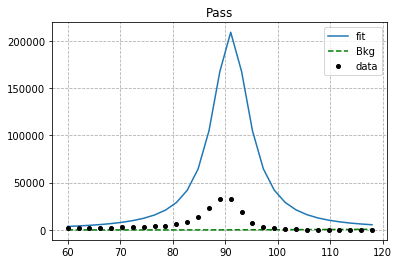

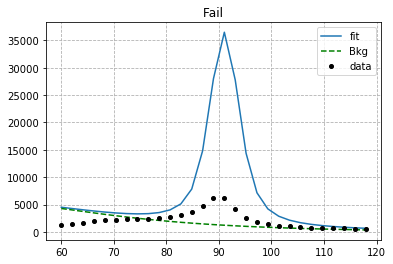

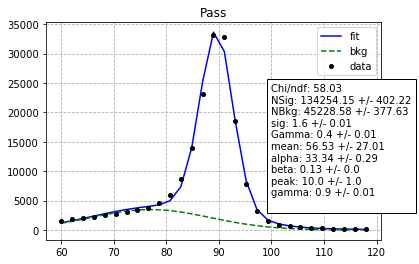

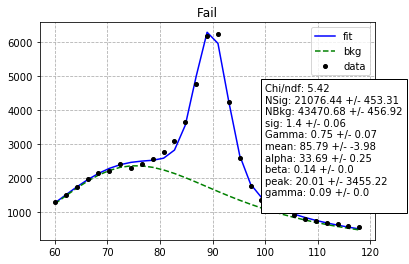

---------------------- i: 3 j: 2 -------------------------
[80000.0, 10000.0, 0.1, 1, 44, 35, 0.1, 20, 0.09] [  443.58113209   495.52181957   549.2126791    605.01035707
   664.06019258   728.76273436   803.54873319   896.2892012
  1021.10019293  1204.45378071  1499.92729199  2028.54281397
  3108.10484335  5755.07151975 13727.88298624 26743.47266787
 13680.49421356  5661.55461608  2970.94951226  1851.4027209
  1287.51829219   962.41241608   755.80109068   614.62324168
   512.66821521   435.80454582   375.86232174   327.84008473
   288.5257831 ]
--- Fitting
[151035.66441581058, 28163.213039729984, 1.6957061241913483, 0.529673746114893, 14.108274880394717, 27.757081934824527, -0.03470719338661621, 9.999999999979032, 0.08961409563960676]  |  [109.57477147881582, 185.1157335179123, 0.002470567180151262, 0.00149021329421406, 0.00272266903004148, 3.906001595978946, 0.0578551769568217, 29411814.840472214, 0.0024595578505978155]
[20292.422750479407, 45439.56353420298, 1.4306593728085566, 0.628

/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


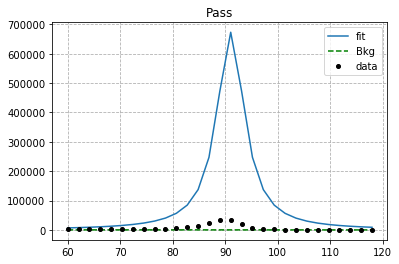

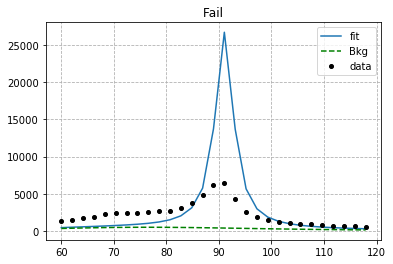

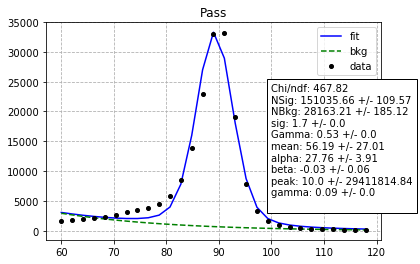

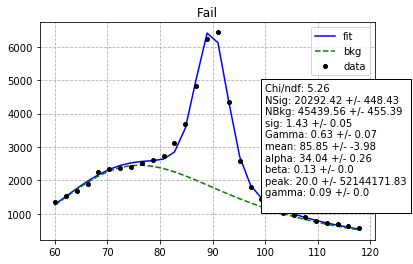

---------------------- i: 4 j: 2 -------------------------
---------------------- i: 5 j: 2 -------------------------
[150000.0, 50000.0, 1, 1, 44, 20, 0.01, 20, 0.09] [ 4513.26618319  4217.05260051  3953.72186747  3724.25598456
  3531.13117519  3379.18406818  3277.21725009  3241.15785144
  3300.75836358  3515.26263927  4015.02823787  5131.65583479
  7852.24887227 14846.13366459 28038.46626667 36518.45326608
 27829.68393589 14427.25035777  7220.61966801  4283.2942344
  2944.583115    2215.98732143  1764.47168628  1458.19698445
  1236.38205342  1067.67269211   934.46657455   826.20297148
   736.19427947]
--- Fitting
[34855.74524519212, 8325.442324653643, 1.8192783759072644, 0.5716613022650201, 13.839506478621995, 26.49081729835696, 0.14899653933460066, 10.000000000005778, 0.8585631420264735]  |  [210.62551749083286, 194.46324342708112, 0.011987795767035458, 0.012371477716938362, 0.007263690985515936, 1.297906530168559, 0.001998877166611901, 62633375.750020735, 0.04713450995282242]
[9621

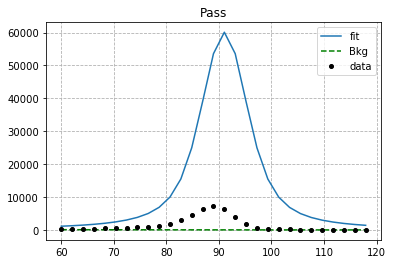

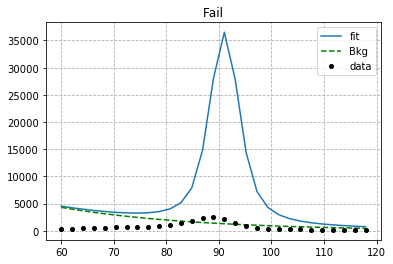

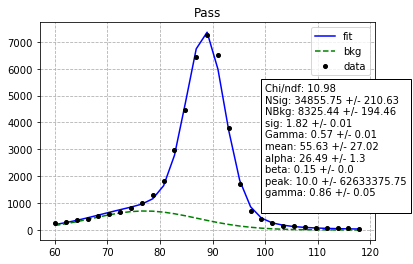

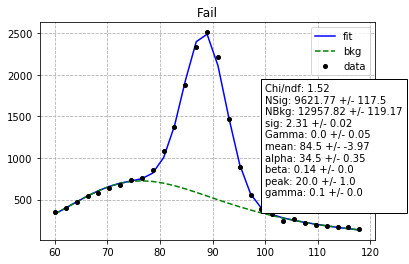

In [171]:

PlotBefore = True
#PlotBefore = False

FailPlot = True
#FailPlot = False

FitPrams = ['NSig','NBkg','sig','Gamma','mean','alpha','beta','peak','gamma']

Mass = np.arange(60,120,step=60/len(xFit))

xTestLoc,rTestLoc = 100,0.15

for j in range(len(ptBins)):
    if j != 2: continue
    PassYield[j] = {}
    FailYield[j] = {}
    FitPass[j] = {}
    FitFail[j] = {}
    for i in range(len(etaBins)):
        print('---------------------- i: '+str(i)+' j: '+str(j)+' -------------------------')
        
        MC_PASS_S = MC['Pass']['DYJets'][0][j][i]#, MC['Pass']['WJets'][0][IJ],
        MC_FAIL_S = MC['Fail']['DYJets'][0][j][i]#, MC['Fail']['WJets'][0][IJ],
        DATA_PASS = Data['Pass'][0][j][i]
        DATA_FAIL = Data['Fail'][0][j][i]
        DATA = np.array(list(DATA_PASS) + list(DATA_FAIL))

        #####################################################
        VoigtCMS = lambda x,*x0 : Voigt_CMS(
                                            x,
                                            NSig  =  x0[0], NBkg  =  x0[1],
                                            sig   =  x0[2], Gamma =  x0[3], mean =  x0[4],
                                            alpha =  x0[5], beta  =  x0[6], peak =  x0[7], gamma = x0[8], 
                                            )
        x = np.arange(0,len(DATA_PASS))


        ##########################################################################
        ##########################################################################
        
        if( SkipGap(i,j,binsSelected) ):
            continue
    
        pPass,pFail, BoundedFit = InitializeParams(i,j,binsSelected)
        ##################################
        if PlotBefore:
            xFit = np.arange(0,len(DATA_PASS))
            BKG = pPass[1]*RooCMSShape(xFit,*pPass[5:9])/np.sum(RooCMSShape(xFit,*pPass[5:9]))
            #print(pPass,VoigtCMS(xFit,*pPass))
            
            plt.figure()
            plt.plot(Mass,VoigtCMS(xFit,*pPass),label='fit')
            plt.plot(Mass, BKG,label='Bkg',color='green',linestyle='--')
            plt.plot(Mass,       DATA_PASS,label='data',color = 'k',linewidth=0,marker = 'o',markersize=4)
            plt.title('Pass')
            plt.legend()
            plt.grid(linestyle='--')
            if FailPlot:
                xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
                BKG = pFail[1]*RooCMSShape(xFit,*pFail[5:9])/np.sum(RooCMSShape(xFit,*pFail[5:9]))
                
                plt.figure()
                print(pFail,VoigtCMS(xFit,*pFail))
                plt.plot(Mass,VoigtCMS(xFit,*pFail),label='fit')
                plt.plot(Mass, BKG,label='Bkg',color = 'green',linestyle='--')
                plt.plot(Mass,         DATA_FAIL,label='data',color = 'k',linewidth=0,marker = 'o',markersize=4)
                plt.title('Fail')
                plt.legend()
                plt.grid(linestyle='--')
            

        ##---------------------------------------
        print('--- Fitting')    
        
        '''
        FitP, FitF,FitPSig, FitFSig = Fit_Curve(
                                                DATA_PASS = DATA_PASS,
                                                DATA_FAIL = DATA_FAIL,
                                                pPass = pPass,pFail = pFail,
                                                Bounded = BoundedFit,
                                                )        
        '''
        FitP, FitF,FitPSig, FitFSig,mP,mF = Fit_Curve_CHI(
                                                DATA_PASS = DATA_PASS,
                                                DATA_FAIL = DATA_FAIL,                                                
                                                pPass = pPass,pFail = pFail,
                                                Bounded = BoundedFit,
                                                )
        '''
        FitP, FitF,FitPSig, FitFSig = Fit_Curve_CHI(
                                                DATA_PASS = Data['Pass'][0][j][i],
                                                DATA_FAIL = Data['Fail'][0][j][i],
                                                pPass = pPass,pFail = pFail,
                                                )
        '''
        FitsPass = FitP
        FitsPass_NBkg,FitsPass_Bkg = FitP[1], FitP[5:9]
        
        FitsFail = FitF
        FitsFail_NBkg,FitsFail_Bkg = FitF[1], FitF[5:9]

        
        print(FitsPass," | ", FitPSig)
        print(FitsFail," | ", FitFSig)
        #for i in range(len(Fits[0])):
        #    print(Fits[0][i],sigs[i])


        ###-----------------
        xFit = np.arange(0,len(DATA_PASS))
        BKG = FitsPass_NBkg*RooCMSShape(xFit,*FitsPass_Bkg)/np.sum(RooCMSShape(xFit,*FitsPass_Bkg))
        
        plt.figure()        
        plt.plot(Mass,VoigtCMS(xFit,*FitsPass),label='fit',color = 'blue')
        plt.plot(Mass, BKG,label='bkg',color = 'green',linestyle='--')
        plt.plot(Mass, DATA_PASS,label='data',color = 'k',linewidth=0,marker = 'o',markersize=4)
        ylim = plt.gca().get_ylim()
        plt.text(xTestLoc,(ylim[1]-ylim[0])*rTestLoc + ylim[0],
                 TextLegend(FitPrams,FitsPass,FitPSig,xFit,Mass,chiplot(VoigtCMS(xFit,*FitsPass),DATA_PASS)),
                 bbox={'fc':'w'})
        
        plt.title('Pass')
        plt.legend()
        plt.grid(linestyle='--')
        if FailPlot:
            xFit = np.arange(len(DATA_PASS),len(DATA_PASS)*2)
            BKG = FitsFail_NBkg*RooCMSShape(xFit,*FitsFail_Bkg)/np.sum(RooCMSShape(xFit,*FitsFail_Bkg))
            
            plt.figure()
            plt.plot(Mass, VoigtCMS(xFit,*FitsFail),label='fit',color = 'blue')
            plt.plot(Mass, BKG,label='bkg',color = 'green',linestyle='--')
            plt.plot(Mass, DATA_FAIL,label='data',color = 'k',linewidth=0,marker = 'o',markersize=4)
            ylim = plt.gca().get_ylim()
            plt.text(xTestLoc,(ylim[1]-ylim[0])*rTestLoc + ylim[0],
                 TextLegend(FitPrams,FitsFail,FitFSig,xFit,Mass,chiplot(VoigtCMS(xFit,*FitsFail),DATA_FAIL)),
                 bbox={'fc':'w'})
            plt.title('Fail')
            plt.legend()
            plt.grid(linestyle='--')

        FitPass[j][i] = FitsPass
        FitFail[j][i] = FitsFail
        PassYield[j][i] =  FitsPass[0]
        FailYield[j][i] =  FitsFail[0]
        
        #eff[j][i] = PassYield[j][i]/(FailYield[j][i] + PassYield[j][i])
        ##########################################################################
        ##########################################################################
        plt.show()
        

In [89]:

m.matrix()

--------------------------------------------------------------------------------------------
|       |     NSig     NBkg      sig    Gamma     mean    alpha     beta     peak    gamma |
--------------------------------------------------------------------------------------------
|  NSig |  0.188E6 -0.149E6 -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6 |
|  NBkg | -0.149E6  0.161E6  0.000E6 -0.000E6  0.000E6  0.000E6 -0.000E6  0.000E6  0.000E6 |
|   sig | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6 |
| Gamma |  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6 -0.000E6 |
|  mean | -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 |
| alpha | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6  0.000E6 |
|  beta |  0.000E6 -0.000E6 -0.000E6  0.000E6  0.000E6 -0.000E6  0.000E6 -0.000E6  0.000E6 |
|  peak | -0.000E6  0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6 -0.000E6  1.000E6  0.000E6 |
| gamma | -0.000E6  0.000E6 -0.000E6 -0.000E6  0.000E6  0.000E6  0.000E6  0.000E6  0.000E6 |
--------------------------------------------------------------------------------------------

In [ ]:
def SkipGap(i,j,binsSelect):
    gapFlag = False
    
    if     binsSelected == "Optimized":
        if (i == 1 or i == 4) and j != 5:
            gapFlag = True
    elif   binsSelected == "Plots":
        if (i == 1 or i == 4) and j != 11:
            gapFlag = True
    elif   binsSelected == "Hien":
        if (i == 1 or i == 4) and j != 6:
            gapFlag = True
    
    return gapFlag

def InitializeParams(i,j,binsSelected):
    if   binsSelected == "Optimized":
        if isConv:
            if   j == 0:
                if i != 5:
                    pPass = [
                            5e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            3e3,   3e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            5e4,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            3e5,   6e4, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   4e5, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            1e6,   5e3, 
                            0.1, 1.5, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            1e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   6e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            1e5,   1e4, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            3e4,   8e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                
                elif i == 5:
                    pPass = [
                            1e4,   5e3, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            5e3,   5e3, 
                            0.5, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                        
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e2,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.5,  1, 44,  
                            49,-0.1, 10, -0.09,  # RooCMS
                            ]  
                elif i == 2:
                    pPass = [
                            7e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  5e2,  
                            0.5,  1, 44,  
                            35,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  1, 44,  
                            48,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 5:
                    pPass = [1.22435554e+03, 3.20343246e+02, 9.22998413e-12,
                             1.10974344e+00, 1.50406031e+01, 1.40180622e+01,
                             6.13551539e-01, 1.00000028e+01, 5.95495234e-01]
                    pFail = [ 4.08455718e+02,  2.34193103e+02,  1.08171908e+00,
                             9.14064665e-01, 4.39415340e+01,  5.75583581e+01, 
                             -5.13886755e-01,  3.82617111e+03,-4.43517032e-02]
                else :
                    pPass = [
                            1e3,  100,  
                            0.5,  1, 15,  
                            15,0.1, 10,-0.09,
                            ] 

                    pFail = [
                            2e2,  1e2,  
                            0.1,  1, 44,  
                            45,0.01, 10, -0.09,  # RooCMS
                            ]                                        
            elif j == 5:
                if i == 0:
                    pPass = [
                            6e4,  1e2,  
                            0.1,  2, 15,  
                            1,1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  2, 44,  
                            35,  1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            2e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e1,  1e1,  
                            0.5,  1, 44,  
                            48,  -0.1, 10,0.1,
                            ]   
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            40,  3e1,  
                            1,  1, 44,  
                            35,  0.1, 1.15814356e+02,0.1,
                            ]  
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                else :
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 43,  
                            42,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
    elif binsSelected == "Plots" :
        if isConv:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            2e5,   1e3, 
                            0.1, 1, 14,       # Voigt
                            30,0.1, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            1e4,   3e3, 
                            1, 1, 44,           # Voigt
                            50,0.1, 20, -0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e5,  5e2,  
                            1,  1, 14,  
                            14,-0.01, 10,1,
                            ] 

                    pFail = [
                            1e4,  2e3,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            8e5,  5e3,
                            0.1,  1, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            9e4,  2e3,
                            0.1,  1, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            4e5,  1e4,
                            0.1,  1, 15,  
                            15,-0.1, 100,-1,
                            ] 

                    pFail = [
                            4e4,  7e3,
                            0.1,  1, 44,  
                            60,0.1, 100,-1,
                            ] 
                elif i == 5 :
                    pPass = [
                            2e5,  4e3,
                            0.1,  2, 15,  
                            15,-0.1, 100,-1,
                            ] 

                    pFail = [
                            2e4,  3e3,  
                            0.1,  2, 44,  
                            65,-0.1, 100,-1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            6e4,  9e2,  
                            0.2,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            3e3,  3e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            9e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e5,  6e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            4e3,  6e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            1e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 6:
                if i == 0:
                    pPass = [
                            8e3,  3e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.2,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            3e4,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            8e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e4,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            3e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e3,  3e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 7:
                if i == 0:
                    pPass = [
                            3e3,  5e1,
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  5e1,
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            2e4,  2e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [8e2, 2e2,
                             1, 1, 44, 
                             60, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                elif i == 3:
                    pPass = [
                            1e4,  3e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [2e3, 3e2,
                             1, 1, 44, 
                             0.7044642032043633, 0.0038985980209962634, 1557.2502065025765, -0.015222050465143688
                            ]
                elif i == 5:
                    pPass = [
                            2e3,  6e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,-0.1,
                            ] 

                    pFail = [2e2, 7e1,
                             1, 1, 44, 
                             70, 0.0038985980209962634, 700, -0.015222050465143688
                            ]
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 8:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  6e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            9e2,  7e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  7e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02, -0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 9:
                if i == 0:
                    pPass = [
                            5e2,  5e1,
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e1,  2e1,
                            0.1,  1, 44,  
                            50,-0.1, 1.15814356e+02,-0.1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            3e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            7e1,  1e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 10:
                if i == 0:
                    pPass = [
                            1e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.1,  1, 44,  
                            50,-0.1, 1.15814356e+02,0.1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            3e2,  1e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            3e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            3e2,  5e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 11:
                if   i == 0:
                    pPass = [
                            4e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,-0.05,
                            ] 

                    pFail = [
                            3e2,  5e1,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,-0.05,
                            ] 
                elif i == 1:
                    pPass = [
                            8e2,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e1,  1e1,  
                            0.1,  1, 44,  
                            10,  0.1, 40,-0.1,
                            ]  
                elif i == 2:
                    pPass = [
                            4e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e2,  
                            1,  1, 44,  
                            40,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]                      
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e5,  4e3,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            8e3,  4e3,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e5,  2e4,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e4,  1e4,
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e5,  2e4,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e4,  1e4,
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                elif i == 5 :
                    pPass = [
                            1e5,  4e3,
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            1e4,  3e3,  
                            0.1,  2, 44,  
                            65,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            9e3,  3e2,  
                            0.2,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            3e3,  3e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            9e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e5,  6e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            4e3,  6e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            1e4,  3e3,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e4,  3e3,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 6:
                if i == 0:
                    pPass = [
                            5e3,  1e2,  
                            0.1,  1, 15,  
                            10,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.2,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e3,  3e2,
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 7:
                if i == 0:
                    pPass = [
                            3e3,  5e1,
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  5e1,
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            3e4,  5e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [8e2, 8e2,
                             1, 1, 44, 
                             60, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                elif i == 3:
                    pPass = [
                            9e3,  3e2,
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [2e3, 7e2,
                             1, 1, 44, 
                             0.7044642032043633, 0.0038985980209962634, 1557.2502065025765, 0.015222050465143688
                            ]
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [200, 70,
                             1, 1, 44, 
                             70, 0.0038985980209962634, -700, 0.015222050465143688
                            ]
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,-0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 8:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            1e3,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  6e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            9e2,  7e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e2,  2e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02, -0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 9:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 10:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 2:
                    pPass = [
                            6e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            6e2,  3e2,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            5e2,  3e2,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            100,  8e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
            elif j == 11:
                if   i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            2e2,  5e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            8e2,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            8e1,  1e2,  
                            0.1,  1, 44,  
                            40,  0.1, 1.15814356e+02,-0.1,
                            ]  
                elif i == 2:
                    pPass = [
                            4e3,  3e2,
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e2,  3e2,  
                            1,  1, 44,  
                            40,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 3:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            1e3,  3e1,  
                            1,  1, 44,  
                            60,  0.1, 1.15814356e+02,0.1,
                            ]  
                elif i == 5:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]                      
    elif binsSelected == "Hien":
        if isConv:
            if   j == 0:
                if i != 5:
                    pPass = [
                            5e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e3,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            3e3,   3e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            5e4,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            3e5,   6e4, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   4e5, 
                            0.1, 2, 14,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 42,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            1e6,   5e3, 
                            0.1, 1.5, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            1e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            1e5,   1e4, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            3e4,   8e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                
                elif i == 5:
                    pPass = [
                            1e4,   5e3, 
                            0.5, 1, 14,       # Voigt
                            15,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            5e3,   5e3, 
                            0.5, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            6e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            45,0.01, 20, -0.09,  # RooCMS
                            ]                        
            elif j == 4:
                if i == 0:
                    pPass = [
                            1e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            1e2,  3e1,  
                            0.5,  1, 44,  
                            49,-0.1, 10, -0.09,  # RooCMS
                            ]  
                elif i == 2:
                    pPass = [
                            7e3,  200,  
                            0.5,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  5e2,  
                            0.5,  1, 44,  
                            35,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  1, 15,  
                            15,1, 10,-0.09,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  1, 44,  
                            48,-0.1, 10, -0.09,  # RooCMS
                            ] 
                elif i == 5:
                    pPass = [1.22435554e+03, 3.20343246e+02, 9.22998413e-12,
                             1.10974344e+00, 1.50406031e+01, 1.40180622e+01,
                             6.13551539e-01, 1.00000028e+01, 5.95495234e-01]
                    pFail = [ 4.08455718e+02,  2.34193103e+02,  1.08171908e+00,
                             9.14064665e-01, 4.39415340e+01,  5.75583581e+01, 
                             -5.13886755e-01,  3.82617111e+03,-4.43517032e-02]
                else :
                    pPass = [
                            1e3,  100,  
                            0.5,  1, 15,  
                            15,0.1, 10,-0.09,
                            ] 

                    pFail = [
                            2e2,  1e2,  
                            0.1,  1, 44,  
                            45,0.01, 10, -0.09,  # RooCMS
                            ]                                        
            elif j == 5:
                if i == 0:
                    pPass = [
                            6e4,  1e2,  
                            0.1,  2, 15,  
                            1,1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  2, 44,  
                            35,  1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            2e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            2e1,  1e1,  
                            0.5,  1, 44,  
                            48,  -0.1, 10,0.1,
                            ]   
                else:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            40,  3e1,  
                            1,  1, 44,  
                            35,  0.1, 1.15814356e+02,0.1,
                            ]  
        else:
            if   j == 0:
                if  i == 0:
                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i != 5:

                    pPass = [
                            1e4,   5e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e3,   5e4, 
                            1, 1.2, 43,       # Voigt
                            30,0.1, 0.01, 0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            5e4,   2e3, 
                            0.1, 1, 14,       # Voigt
                            1,0.1, 0.01, 0.09,  # RooCMS
                            ]

                    pFail = [
                            4e3,   2e4, 
                            1, 1.2, 43,       # Voigt
                            10,0.1, 0.01, 0.09,  # RooCMS
                            ]
            elif j == 1:
                if i == 0:
                    pPass = [
                            1e5,   7e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e5,   6e4, 
                            0.1, 2, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             2e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e5,   1e5, 
                            0.1, 2, 14,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             3e4, 5e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            1e5,   8e4, 
                            0.1, 2, 15,       # Voigt
                            30,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                             1e4, 1e4,
                             2, 0.01, 43,        # Voigt
                             33, 0.1, 200, 0.09  # RooCMS
                            ]
            elif j == 2:
                if i == 0:
                    pPass = [
                            3e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            10,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 2:
                    pPass = [
                            12e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            30,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 3:
                    pPass = [
                            3e6,   5e3, 
                            0.2, 1.5, 15,       # Voigt
                            5,0.1, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            8e4,   1e4, 
                            0.1, 1, 44,           # Voigt
                            35,0.1, 20, 0.09,  # RooCMS
                            ]
                if i == 5:
                    pPass = [
                            4e5,   1e3, 
                            1.5, 1.7, 15,       # Voigt
                            3,0.01, 10, 0.09,  # RooCMS
                            ]

                    pFail = [
                            1.5e5,   5e4, 
                            1, 1, 44,           # Voigt
                            20,0.01, 20, 0.09,  # RooCMS
                            ]
            elif j == 3:
                if i == 0:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 2:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 3:
                    pPass = [
                            5e4,   9e3, 
                            #0.1, 2, 15,       # Voigt
                            1, 1, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                elif i == 5:
                    pPass = [
                            7e4,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
                else:
                    pPass = [
                            2e5,   5e3, 
                            0.1, 2, 15,       # Voigt
                            13,0.01, 10, -0.09,  # RooCMS
                            ]

                    pFail = [
                            9e3,   4e3, 
                            1, 1, 44,           # Voigt
                            40,0.01, 20, -0.09,  # RooCMS
                            ]
            elif j == 4:
                if i == 0:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            42,-0.1, 100,1,
                            ] 
                elif i == 2:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            4e2,  1e2,  
                            0.1,  2, 44,  
                            60,-0.1, 100,1,
                            ] 
                elif i == 3:
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 44,  
                            60,0.1, 100,1,
                            ] 
                else :
                    pPass = [
                            5e3,  200,  
                            0.1,  2, 15,  
                            15,-0.1, 100,1,
                            ] 

                    pFail = [
                            5e2,  1e2,  
                            0.1,  2, 43,  
                            42,-0.1, 100,1,
                            ] 
            elif j == 5:
                if i == 0:
                    pPass = [
                            3e3,  1e2,  
                            0.1,  1, 15,  
                            1,0.1, 1.15814356e+02,1,
                            ] 

                    pFail = [
                            1e3,  1e2,  
                            0.1,  1, 44,  
                            70,-0.1, 1.15814356e+02,1,
                            ] 
                elif i == 1:
                    pPass = [
                            6e2,  3e1,  
                            0.5,  1, 15,  
                            10,0.1, 1.15814356e+02,0.1,
                            ] 

                    pFail = [
                            200,  3e1,  
                            1,  1, 44,  
                            10,  0.1, 1.15814356e+02,0.1,
                            ]  

    #################################
    
    BoundedFit = [
                   [0,0,
                    0,0,10,
                    #0,-np.inf,-np.inf,-1],
                    #0,-0.9,-np.inf,-0.9],
                    0,-0.3,-np.inf,-0.9],
                   [np.inf,np.inf,
                    3,3,48,
                    #70,np.inf,np.inf,1,
                    #70, 0.9, np.inf,0.9,
                    70, 0.3, np.inf,0.9,
                   ]
                    ]
        
    return pPass, pFail, BoundedFit